In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Somy RNA

- data is made of 3 conditions (infantum, tarentolae, and bybrid) with 3 replicates each.
- data was analysed with sequana_rnaseq pipeline. 

In [66]:
from sequana import *
from pylab import *
import pandas as pd
import seaborn as sns

from matplotlib import rcParams
rcParams['figure.figsize'] = (12,8)
from scipy.interpolate import griddata


In [85]:
def savefig(tag):
    for ext in ['png', 'pdf', 'eps']:
        plt.savefig(f"images_and_results/{tag}.{ext}", dpi=200)


# Get chromosome lengths of all contigs for both genomes

In [86]:
ginf = GFF3("references/infantum.gff")
lengths = ginf.df.query("genetic_type=='region'")[['seqid', 'stop']].set_index('seqid').to_dict()['stop']

gtar = GFF3("references/tarentolae.gff")
lengths.update(gtar.df.query("genetic_type=='region'")[['seqid', 'stop']].set_index('seqid').to_dict()['stop'])


# Expression level 

We mapped the transcriptomic in 3 different ways:
- all data on infantum genome only
- all data on tarentolae only
- all data hybrid genome


## infantum data on infantum genome only

In [87]:

# from rnaseq_infantum
fc = FeatureCount("data/RNA/inf/all_features.out")
df_inf = fc.df.reset_index().copy()

# figure out to which chrom each gene does belong
X = []
from tqdm import tqdm
for x in tqdm(df_inf['Geneid'].values):
    X.append(ginf.df.query("ID==@x").seqid.values[0])
df_inf['chrom'] = X

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8683/8683 [00:24<00:00, 349.15it/s]


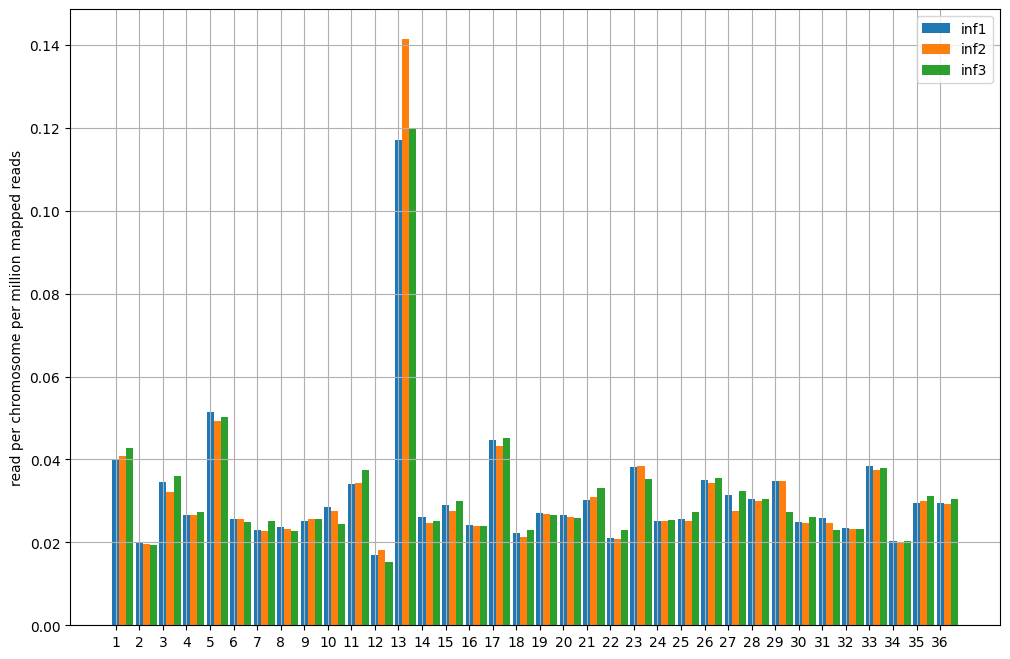

In [88]:
# a naive normalisation per chromosome to compare the replicates
X = np.arange(36)
for i,item in enumerate(['inf1','inf2','inf3']):
    S = df_inf[item].sum()
    dd = df_inf.groupby('chrom')[item].sum().reset_index()
    dd['L'] = [lengths[x] for x in dd['chrom']]  # add length for convenience
    dd[item] /= S                              # normalised by all read counts
    dd = dd[item].divide(dd['L']) * 1e6        # normalised sum on a chromosome by length of the chromosome and multiply by 1e6
    X1 = dd.values
    bar(X+i*0.3, X1, width=0.3, label=item)
    #bar(X+0.3, X2, width=0.3)
    #bar(X+0.6, X3, width=0.3)
legend()
ylabel("read per chromosome per million mapped reads")
grid()
_=xticks(range(0,36), range(1,37))

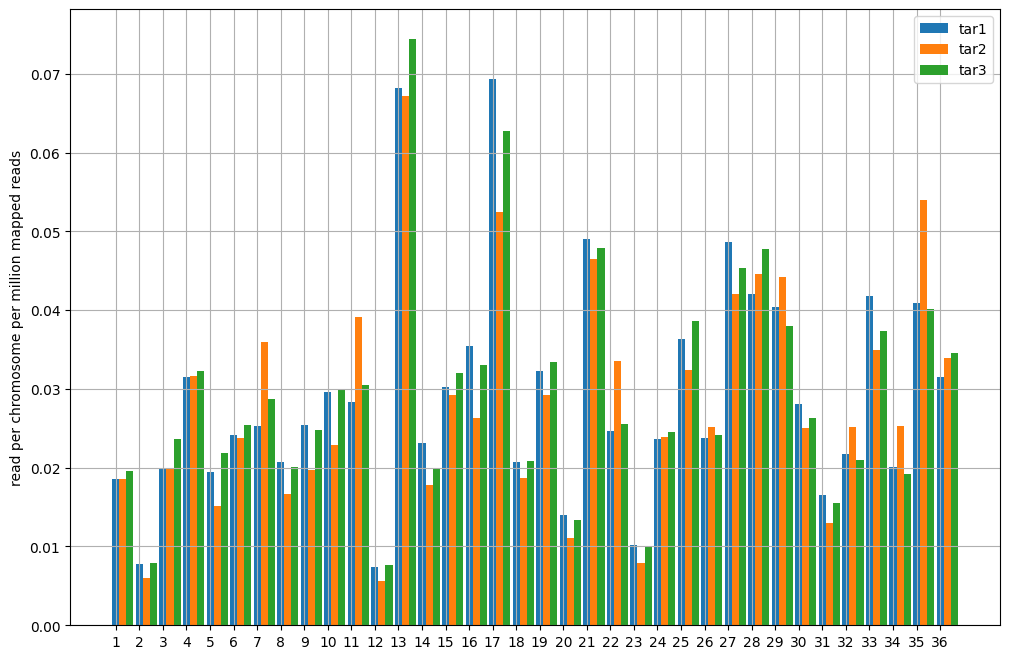

In [89]:
# a naive normalisation per chromosome to compare the replicates
X = np.arange(36)
for i,item in enumerate(['tar1','tar2','tar3']):
    S = df_inf[item].sum()
    dd = df_inf.groupby('chrom')[item].sum().reset_index()
    dd['L'] = [lengths[x] for x in dd['chrom']]  # add length for convenience
    dd[item] /= S                              # normalised by all read counts
    dd = dd[item].divide(dd['L']) * 1e6        # normalised sum on a chromosome by length of the chromosome and multiply by 1e6
    X1 = dd.values
    bar(X+i*0.3, X1, width=0.3, label=item)
    #bar(X+0.3, X2, width=0.3)
    #bar(X+0.6, X3, width=0.3)
legend()
ylabel("read per chromosome per million mapped reads")
grid()
_=xticks(range(0,36), range(1,37))

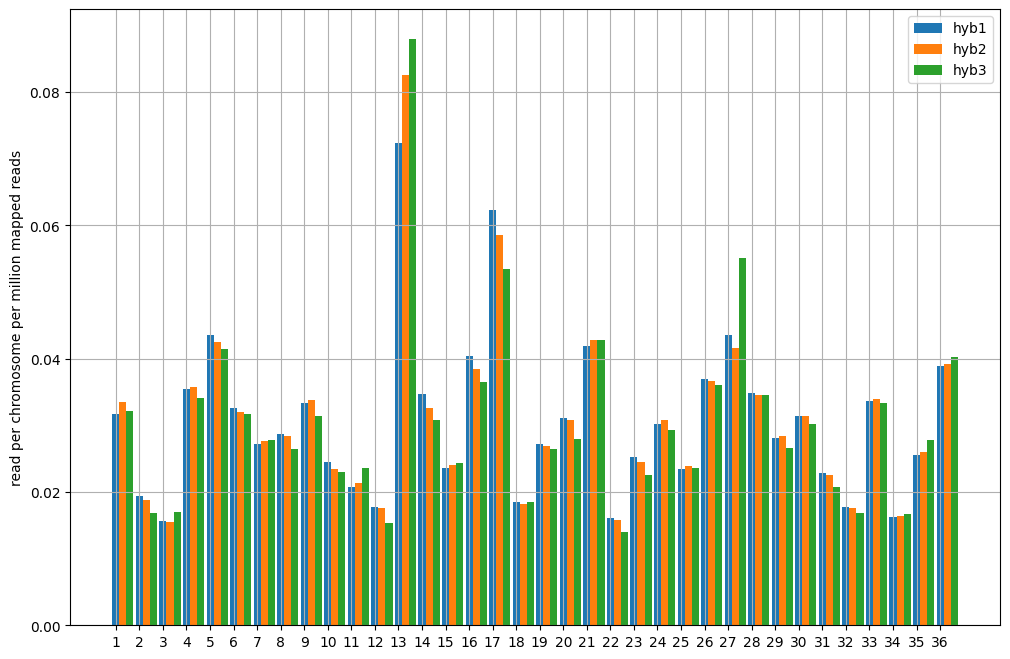

In [90]:


# a naive normalisation per chromosome to compare the replicates
X = np.arange(36)
for i,item in enumerate(['hyb1','hyb2','hyb3']):
    S = df_inf[item].sum()
    dd = df_inf.groupby('chrom')[item].sum().reset_index()
    dd['L'] = [lengths[x] for x in dd['chrom']]  # add length for convenience
    dd[item] /= S                              # normalised by all read counts
    dd = dd[item].divide(dd['L']) * 1e6        # normalised sum on a chromosome by length of the chromosome and multiply by 1e6
    X1 = dd.values
    bar(X+i*0.3, X1, width=0.3, label=item)
    #bar(X+0.3, X2, width=0.3)
    #bar(X+0.6, X3, width=0.3)
legend()
ylabel("read per chromosome per million mapped reads")
grid()
_=xticks(range(0,36), range(1,37))

## TARINF reference

## RNAseq data mapped on hybrid genome (tarentolae + infantum) transcriptome

In [91]:
# from rnaseq_infantum
fc = FeatureCount("data/RNA/tarinf/all_features.out")
# this version uses the -O -M options . this version has no infantum but we only use the hybrid columns anyway
fc = FeatureCount("data/RNA/tarinf/corrected_all_features.out")


df = fc.df.reset_index().copy()
df

Geneid  hyb2  tar3  hyb1  tar2  hyb3  tar1
0       gene-LtaPh_0100100   392   235   701   181    60   420
1       gene-LtaPh_0100200  2914  2262  4451  1089   603  2978
2       gene-LtaPh_0100400   129   266   233   170    39   378
3       gene-LtaPh_0100451     0     0     6     0     1     0
4       gene-LtaPh_0100500   672   627  1116   417    99  1158
...                    ...   ...   ...   ...   ...   ...   ...
17381  gene-LINF_360082000   131     0   229     0    40     0
17382  gene-LINF_360082100    91     0   201     0    23     0
17383  gene-LINF_360082200   537     0   950     0   186     0
17384  gene-LINF_360082300   705     0  1324     0   312     0
17385  gene-LINF_360082400  1055     0  1318     0   282     0

[17386 rows x 7 columns]

In [92]:
def annotate_features_with_seqid_and_chromosome(df):
    # figure out to which chrom each gene does belong
    ginf = GFF3("references/infantum.gff")
    gtar = GFF3("references/tarentolae.gff")
    X = []
    Names = []
    from tqdm import tqdm
    for x in tqdm(df['Geneid'].values):
        try:
            seqid = ginf.df.query("ID==@x").seqid.values[0]
            X.append(seqid)
            name = ginf.df.query("genetic_type=='region' and seqid==@seqid")['Name'].values[0]
            Names.append(name)
        except:
            seqid = gtar.df.query("ID==@x").seqid.values[0]
            X.append(seqid)
            name = gtar.df.query("genetic_type=='region' and seqid==@seqid")['Name'].values[0]
            Names.append(name)
    df['seqid'] = X
    df['chromosome'] = Names
    return df
df = annotate_features_with_seqid_and_chromosome(df)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17386/17386 [02:45<00:00, 105.08it/s]


# estimate proportions of gene from tarentolae that are not associated with a valid chromosome.

we are going to ignore them

In [93]:
to_be_used = df[['BLB'in x and pd.isna(y) is False for x,y in zip(df.seqid, df.chromosome)]][['hyb1','hyb2', 'hyb3']].sum()

In [94]:
to_remove = df[['BLB' in x and pd.isna(y) is True for x,y in zip(df.seqid, df.chromosome)]][['hyb1','hyb2', 'hyb3']].sum()

In [95]:
to_remove /  (to_be_used + to_remove) * 100

hyb1    1.794531
hyb2    1.872227
hyb3    1.885852
dtype: float64

So, there is 2% of the data that should be tarentolae will be removed.

Let us remove contig with no associated chromosomes (1.9% if entries) and add a tag (tar/inf)

In [96]:
def remove_small_contigs(df):
    
    df = df[df['chromosome'].isnull() == False].copy()
    df['chromosome'] = [int(x) for x in df['chromosome']]
    df['tag'] = ['tar' if 'LtaPh' in x else 'inf' for x in df['Geneid']]
    return df
df = remove_small_contigs(df)
df
assert len(df) == 17147, len(df)

# Somies estimate versus measured on the genomic data

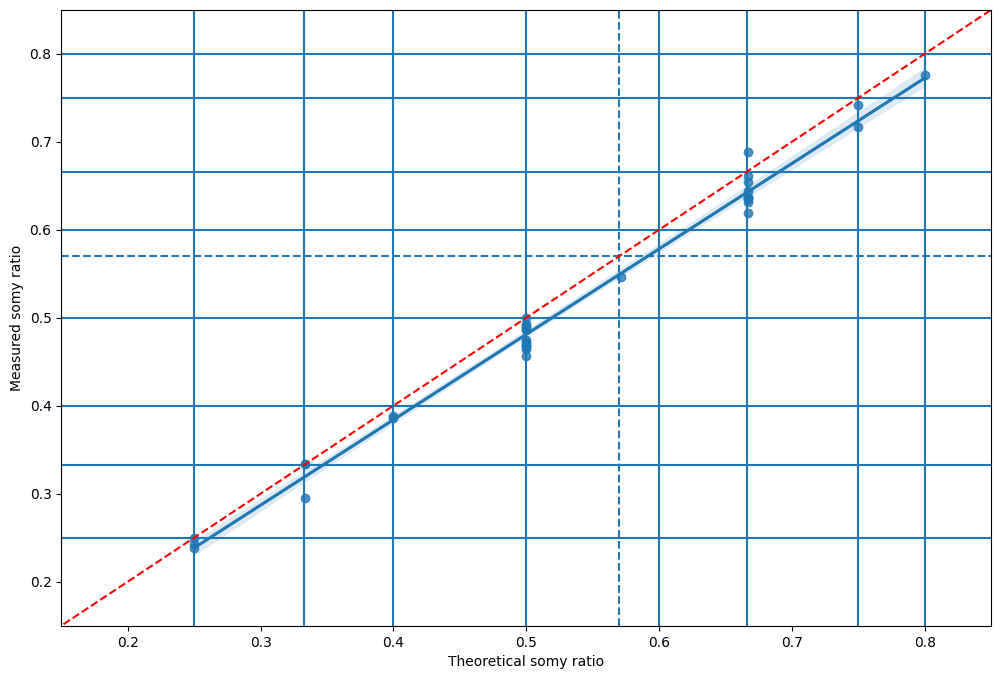

In [97]:

# somies_hyb.csv is the CSV file as saved by the sequana somy tool with estimated and measured somies
# generated with somy notebook.

somies_inf = pd.read_csv("images_and_results/somies_hyb.csv").query("tag=='inf'").measured_somies.values
somies_tar = pd.read_csv("images_and_results/somies_hyb.csv").query("tag=='tar'").measured_somies.values

somies = [(round(x),round(y)) for x,y in zip(somies_tar, somies_inf)]
somies_measured = [(x,y) for x,y in zip(somies_tar, somies_inf)]
somies = pd.DataFrame( {'somies_ratio': [x/(x+y) for x,y in somies], 'measured_ratio': [x/(x+y) for x,y in somies_measured]})
somies['theo_somy_tar'] = [round(x) for x in somies_tar]
somies['theo_somy_inf'] = [round(x) for x in somies_inf]

somies['measured_somy_tar'] = [x for x in somies_tar]
somies['measured_somy_inf'] = [x for x in somies_inf]
somies['chromosome'] = range(1,37)
sns.regplot(x="somies_ratio", y="measured_ratio", data=somies, x_jitter=0.0);
for x in [0.5,0.75,0.25,0.333,0.666,0.8,0.4,0.6]:
    axvline(x)
axvline(0.57, ls='--')
for x in [0.5,0.75,0.25,0.333,0.666,0.8,0.4,0.6]:
    axhline(x)
axhline(0.57, ls='--')
xlim([0.15,0.85])
ylim([0.15,0.85])
xlabel("Theoretical somy ratio")
ylabel("Measured somy ratio")

plot([0,1],[0,1],ls='--', color='r')


# Choice Ltar / (Linf + Ltar)  over Ltar/Linf

Ltar/Ltar+Linf is normalised

(0.15, 0.85)

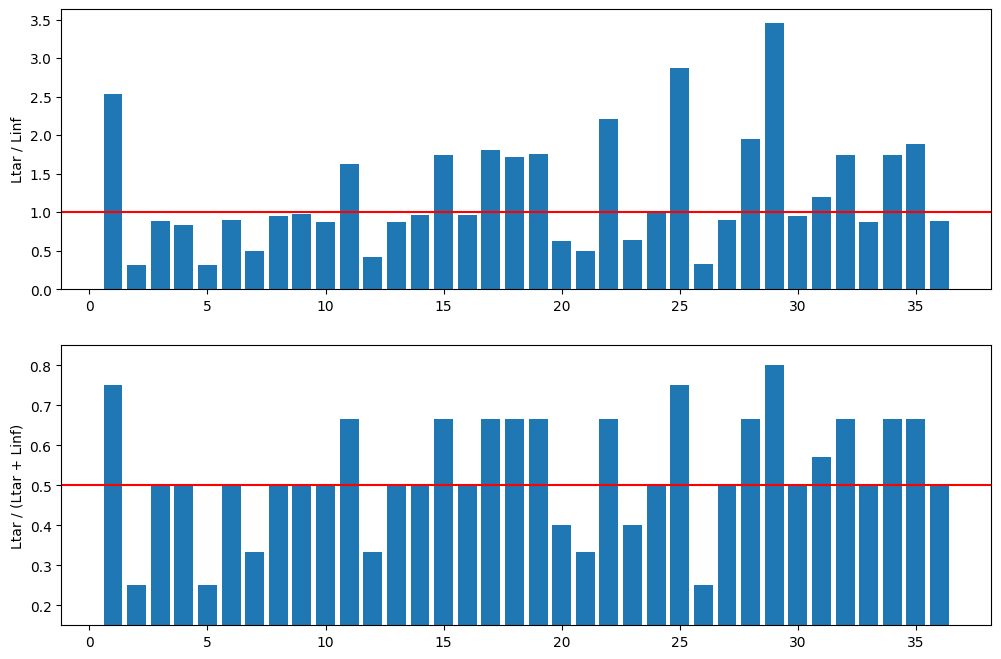

In [98]:
subplot(2,1,1)
bar(height = somies["measured_somy_tar"] / somies["measured_somy_inf"], x=range(1,37))
ylabel("Ltar / Linf")
axhline(1, color='r')

subplot(2,1,2)
bar(height = somies["somies_ratio"] , x=range(1,37))
ylabel("Ltar / (Ltar + Linf)")
axhline(0.5, color='r')
ylim([0.15,0.85])

# Ratio Transcriptomic data

In [99]:
def add_hlines(zorder=-1):
    ylim([0,1])
    axhline(0.5, color='r', lw=2, label="disomic ratio", zorder=zorder)
    axhline(0.25, color='r', ls="--", zorder=zorder)
    axhline(0.33, color='b', ls='--', label="trisomic ratios", zorder=zorder)
    axhline(0.66, color='b', ls='--', zorder=zorder)
    axhline(0.75, color='r', ls="--",label="tetrasomic ratios", zorder=zorder)
    axhline(0.8, color='grey', ls='--', label="pentasomic ratios", zorder=zorder)
    axhline(0.2, color='grey', ls='--', zorder=zorder)
    axhline(0.4, color='grey', ls='--', zorder=zorder)
    axhline(0.6, color='grey', ls='--', zorder=zorder)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


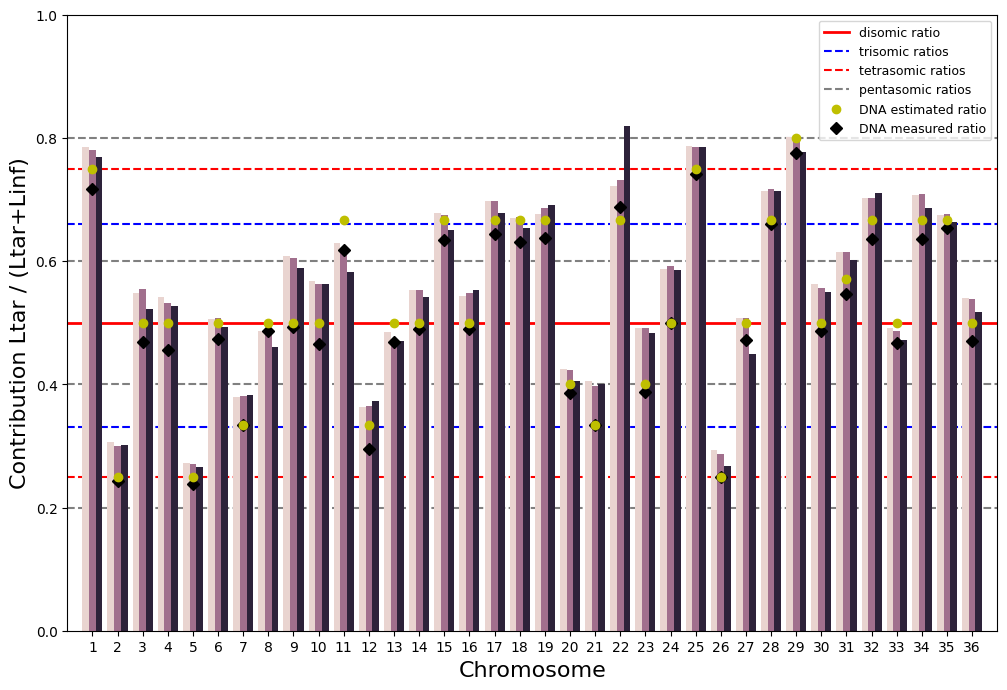

In [100]:
# we focus on reads that hit on a peculiar gene but using the hybrid genome hence [hyb1], [hyb2] etc. 
# columns with tarX and infX should be ignore, there are the parents. 
X1 = []
for x in range(1,37):
    T = df.query("chromosome==@x and tag=='tar'")['hyb1'].sum()
    I = df.query("chromosome==@x and tag=='inf'")['hyb1'].sum()
    X1.append(T/(T+I))

X2 = []
for x in range(1,37):
    T = df.query("chromosome==@x and tag=='tar'")['hyb2'].sum()
    I = df.query("chromosome==@x and tag=='inf'")['hyb2'].sum()
    X2.append(T/(T+I))

X3 = []
for x in range(1,37):
    T = df.query("chromosome==@x and tag=='tar'")['hyb3'].sum()
    I = df.query("chromosome==@x and tag=='inf'")['hyb3'].sum()
    X3.append(T/(T+I))
import pandas as pd

data = pd.DataFrame([X1, X2, X3]).T
data['chromosome'] = [str(x) for x in range(1,37)]
data = pd.melt(data, value_vars=[0,1,2], id_vars=['chromosome'])
data['replicate'] = data['variable']



X = np.arange(1,37)
import seaborn  as sns
#sns.stripplot(data=data, x='chromosome', y="value", dodge=True)
#sns.pointplot(data=data, x='chromosome', y="value", hue="replicate",  capsize=0.3,  lw=2, linestyles='')
sns.barplot(data=data, x='chromosome', y="value", hue="replicate",  capsize=0.3,  lw=2, legend=False)

add_hlines()

legend()
ylabel("Contribution Ltar / (Ltar+Linf)", fontsize=16)
xlabel("Chromosome", fontsize=16)
savefig("rna_contribution_hybrid")
plot(range(0,36), somies['somies_ratio'], 'oy', label='DNA estimated ratio', zorder=20)

xlim([-1,36.])
legend(fontsize=9)
savefig("rna_contribution_hybrid_somy")

plot(range(0,36), somies['measured_ratio'], 'Dk', label='DNA measured ratio', zorder=10)


legend(fontsize=9)
savefig("rna_contribution_hybrid_measured_somy")
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


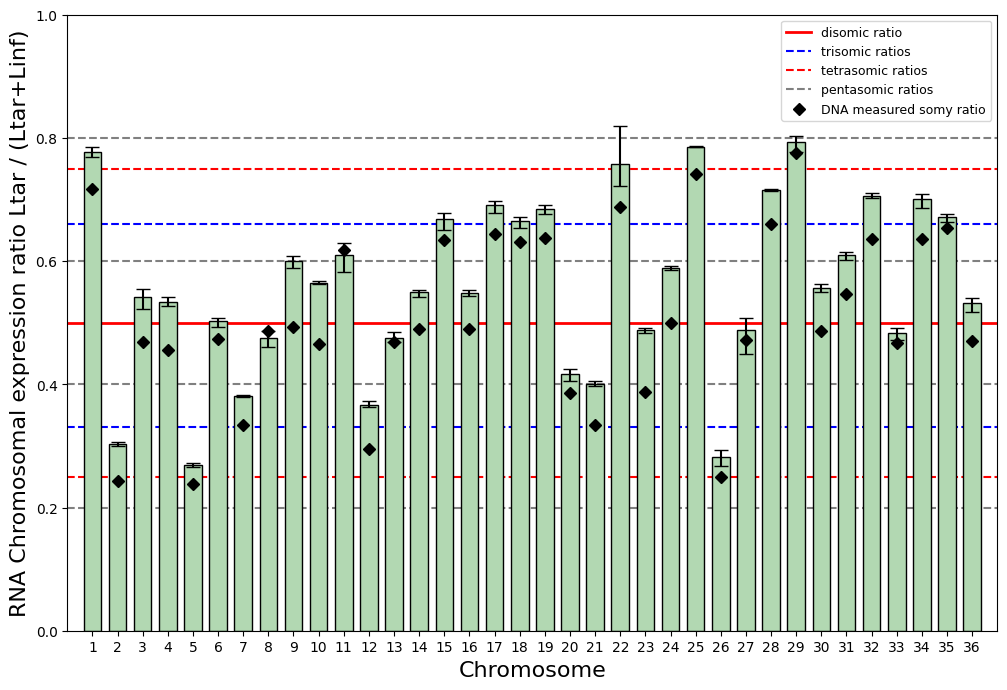

In [102]:
# we focus on reads that hit on a peculiar gene but using the hybrid genome hence [hyb1], [hyb2] etc. 
# columns with tarX and infX should be ignore, there are the parents. 

X1 = []
for x in range(1,37):
    T = df.query("chromosome==@x and tag=='tar'")['hyb1'].sum()
    I = df.query("chromosome==@x and tag=='inf'")['hyb1'].sum()
    X1.append(T/(T+I))

X2 = []
for x in range(1,37):
    T = df.query("chromosome==@x and tag=='tar'")['hyb2'].sum()
    I = df.query("chromosome==@x and tag=='inf'")['hyb2'].sum()
    X2.append(T/(T+I))

X3 = []
for x in range(1,37):
    T = df.query("chromosome==@x and tag=='tar'")['hyb3'].sum()
    I = df.query("chromosome==@x and tag=='inf'")['hyb3'].sum()
    X3.append(T/(T+I))
import pandas as pd

data = pd.DataFrame([X1, X2, X3]).T
data['chromosome'] = [str(x) for x in range(1,37)]
data['mean'] = data[[0,1,2]].mean(axis=1)
data['min'] = data[[0,1,2]].min(axis=1)
data['max'] = data[[0,1,2]].max(axis=1)

X = np.arange(1,37)


#norm = plt.Normalize(data['mean'].min(), data['mean'].max())
#colors = cm.viridis(norm(data['mean']))  # 

plt.bar(data['chromosome'], data['mean'], color="#B2D8B2", edgecolor='black', width=0.7)
plt.errorbar(data['chromosome'], data['mean'], 
             yerr=[data['mean'] - data['min'], data['max'] - data['mean']], 
             fmt='none', ecolor='black', capsize=5) #, label='Min-Max Range')

add_hlines()

legend()
ylabel("RNA Chromosomal expression ratio Ltar / (Ltar+Linf)", fontsize=16)
xlabel("Chromosome", fontsize=16)
savefig("rna_contribution_hybrid")


xlim([-1,36.])
#legend(fontsize=9)
#savefig("rna_contribution_hybrid_somy.png")
plot(range(0,36), somies['measured_ratio'], 'Dk', label='DNA measured somy ratio', zorder=10)

legend(fontsize=9)
savefig("fig_4B_rna_contribution_hybrid_measured_somy")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Slope: 0.9731839661590855
Intercept: 0.06390263662958623
R-squared: 0.9593643733253674


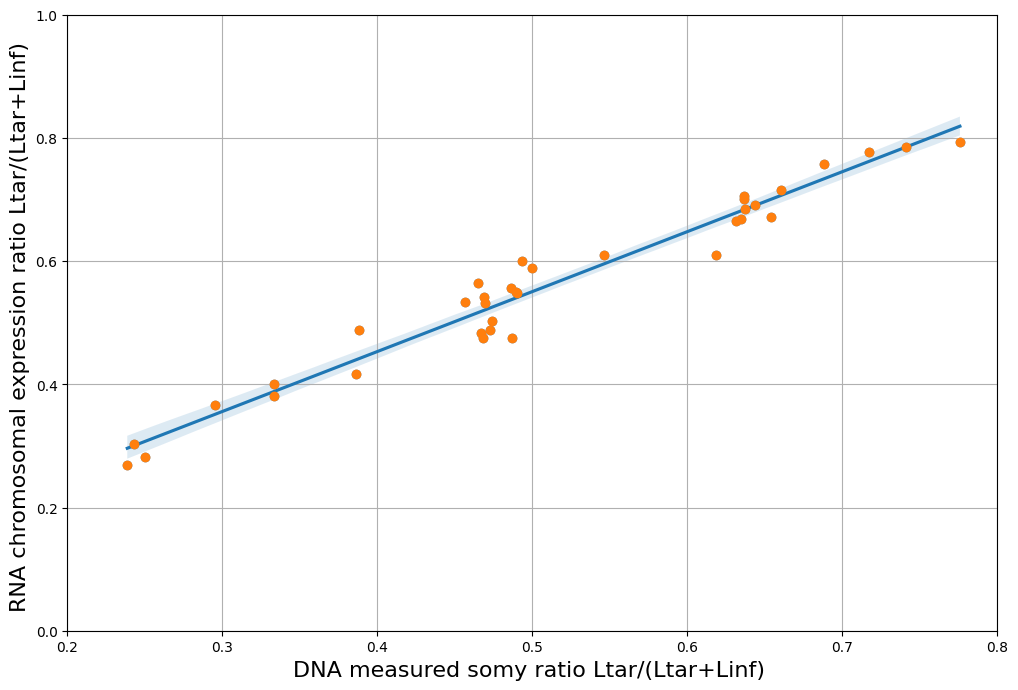

In [103]:
Y = []
for chrom in range(1,36+1):
    chrom = str(chrom)
    Y.append(data.query("chromosome == @chrom")[[0,1,2]].mean(axis=1).values[0])
X = somies["measured_ratio"]


from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)

data_regression = pd.DataFrame({'measured_somies': X, 'RNA': Y})
sns.regplot(x="measured_somies", y="RNA", data=data_regression, x_jitter=0.0);

# Print results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
plot(X, Y, "o")


xlim([0.2,0.8])
ylim([0.,1])
#plot([0,1],[0,1],ls='--', color='r')
from pylab import grid
grid()
R2 = round(r_value**2, 3)
#text(0.2,0.7 ,f"$R^2$={R2}", fontsize=16)
ylabel("RNA chromosomal expression ratio Ltar/(Ltar+Linf) ", fontsize=16)
xlabel("DNA measured somy ratio Ltar/(Ltar+Linf) ", fontsize=16)
savefig("fig_4C_regression_dna_rna_ratio")



# Analysis expression ratio at gene level

Before, we look at each chromosome, and for each chromosome, we compute the expression ratio between Ltar and Linf.
It looks quite coherent wrt DNA expected/measured ratio. One question that we may ask ourself is whether we have fluctuations at the gene level. In particular, 
we would like to identify genes that depart from the expected ratio.

One difficulty is that genes in Linf and Ltar are not associated (from the GFF files). We first need to build some orthologs. We use orthofinder and we will use the orthogroups.
See the orthogroups notebook for details. 

In [104]:
ortho_groups = pd.read_csv("analysis/Orthogroups_cleaned.tsv", sep="\t")
assert len(ortho_groups) == 7317
ortho_groups

Orthogroup                                           infantum  \
0     OG0000000  gene-LINF_280035000, gene-LINF_280035100, gene...   
1     OG0000001  gene-LINF_130007700, gene-LINF_130007800, gene...   
2     OG0000008  gene-LINF_360072800, gene-LINF_360072900, gene...   
3     OG0000011  gene-LINF_080014700, gene-LINF_080014800, gene...   
4     OG0000015  gene-LINF_350023700, gene-LINF_350023800, gene...   
...         ...                                                ...   
7312  OG0007579                                gene-LINF_360082000   
7313  OG0007580                                gene-LINF_360082100   
7314  OG0007581                                gene-LINF_360082200   
7315  OG0007582                                gene-LINF_360082300   
7316  OG0007583                                gene-LINF_360082400   

                                             tarentolae  chr_name_inf  \
0     gene-LtaPh_2828011, gene-LtaPh_2828031, gene-L...            28   
1     gene-LtaPh_1302611, gene-LtaPh_1302621, gene-L...            13   
2     gene-LtaPh_3664381, gene-LtaPh_3664461, gene-L...            36   
3     gene-LtaPh_0808101, gene-LtaPh_0808151, gene-L...             8   
4     gene-LtaPh_3501000, gene-LtaPh_3502861, gene-L...            35   
...                                                 ...           ...   
7312                                 gene-LtaPh_3672600            36   
7313                                 gene-LtaPh_3672700            36   
7314                                 gene-LtaPh_3672800            36   
7315                                 gene-LtaPh_3672900            36   
7316                                 gene-LtaPh_3673000            36   

      chr_name_tar  
0               28  
1               13  
2               36  
3                8  
4               35  
...            ...  
7312            36  
7313            36  
7314            36  
7315            36  
7316            36  

[7317 rows x 5 columns]

In [105]:
import pandas as pd
from sequana import GFF3
from collections import defaultdict
from sequana.somy import SomyScore
import pandas as pad

mapper = {}
for x in range(179):
    dftemp = gtar.df.query("genetic_type=='region'")
    Name = dftemp.iloc[x].Name
    if pd.isna(Name):
        mapper[dftemp.iloc[x].seqid] = 0
    else:
        mapper[dftemp.iloc[x].seqid] = int(Name)

g = GFF3("references/infantum.gff")
names = g.df.query("genetic_type=='region'").seqid.values
chrnames = list(range(1,36+1))
for i,name in enumerate(names):
    mapper[name] = i+1


In [106]:
X1 = []
for x in range(1,37):
    T = df.query("chromosome==@x and tag=='tar'")['hyb1'].sum()
    I = df.query("chromosome==@x and tag=='inf'")['hyb1'].sum()
    X1.append(T/(T+I))

X2 = []
for x in range(1,37):
    T = df.query("chromosome==@x and tag=='tar'")['hyb2'].sum()
    I = df.query("chromosome==@x and tag=='inf'")['hyb2'].sum()
    X2.append(T/(T+I))

X3 = []
for x in range(1,37):
    T = df.query("chromosome==@x and tag=='tar'")['hyb3'].sum()
    I = df.query("chromosome==@x and tag=='inf'")['hyb3'].sum()
    X3.append(T/(T+I))
import pandas as pd

data2 = pd.DataFrame([X1, X2, X3]).T
data2['chromosome'] = [str(x) for x in range(1,37)]
data2 = pd.melt(data2, value_vars=[0,1,2], id_vars=['chromosome'])
data2['replicate'] = data2['variable']
data2

chromosome variable     value replicate
0            1        0  0.785169         0
1            2        0  0.306456         0
2            3        0  0.548752         0
3            4        0  0.541840         0
4            5        0  0.272447         0
..         ...      ...       ...       ...
103         32        2  0.711081         2
104         33        2  0.471822         2
105         34        2  0.685542         2
106         35        2  0.663404         2
107         36        2  0.517889         2

[108 rows x 4 columns]

In [107]:

# we focus on reads that hit on a peculiar gene but using the hybrid genome hence [hyb1], [hyb2] etc. 
# columns with tarX and infX should be ignore, there are the parents. 

all_ratios = {}
all_Is = {}
all_Ts = {}
for chrom in tqdm(range(1,37)):
    ratios = []
    Is = []
    Ts = []
    
    subdf = ortho_groups.query("chr_name_inf == @chrom")
    for _, row in subdf.iterrows():
        group = row['Orthogroup']
        if "," in row['infantum']:
            genes = [x.strip() for x in row['infantum'].split(",")]
        else:
            genes = [row['infantum']]
        #print(genes)
        I = df.query("Geneid in @genes")[['hyb1','hyb2','hyb3']].sum().sum()    
    
        if "," in row['tarentolae']:
            genes = [x.strip() for x in row['tarentolae'].split(",")]
        else:
            genes = [row['tarentolae']]
        #print(genes)
        T = df.query("Geneid in @genes")[['hyb1','hyb2','hyb3']].sum().sum()    
        
        all_ratios[group] = T / (T+I)
        all_Is[group] = I
        all_Ts[group] = T
        
   
ortho_groups['all_ratios'] = [all_ratios[k] for k in ortho_groups["Orthogroup"].values]
ortho_groups['Linf_expression'] = [all_Is[k] for k in ortho_groups["Orthogroup"].values]
ortho_groups['Ltar_expression'] = [all_Ts[k] for k in ortho_groups["Orthogroup"].values]



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:34<00:00,  1.06it/s]


In [108]:
all_ratios = [ortho_groups.query("chr_name_inf == @chrom_name")['all_ratios'].values for chrom_name in range(1,37)]
all_Is = [ortho_groups.query("chr_name_inf == @chrom_name")['Linf_expression'].values for chrom_name in range(1,37)]
all_Ts = [ortho_groups.query("chr_name_inf == @chrom_name")['Ltar_expression'].values for chrom_name in range(1,37)]

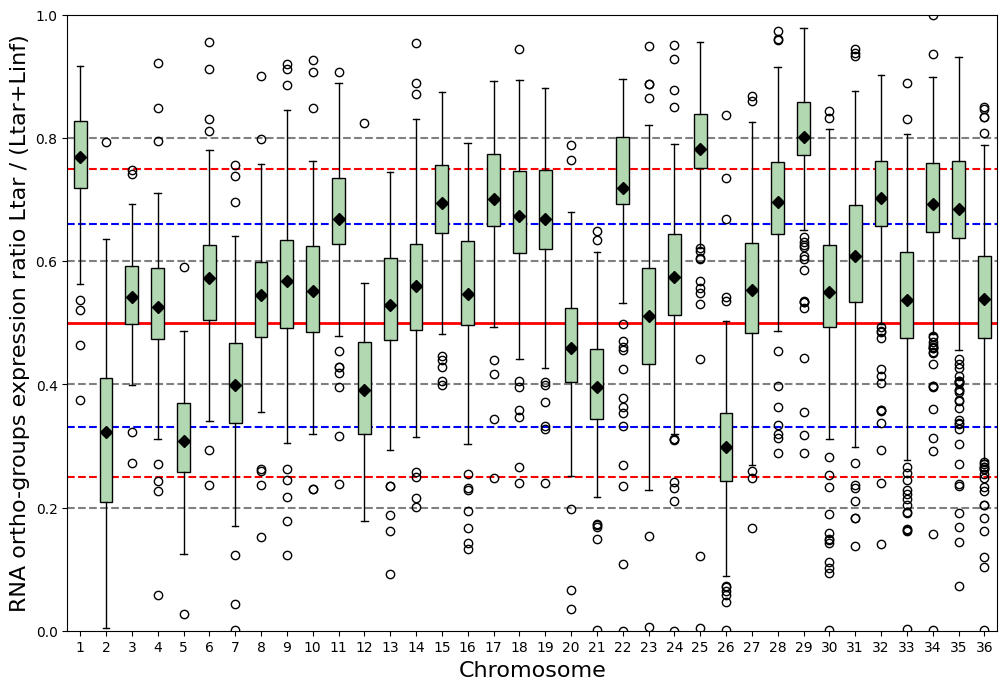

In [109]:
color = "#B2D8B2"
bplot = boxplot(all_ratios, patch_artist=True,
        medianprops=dict(color='orange', linewidth=0)
           )

# fill with colors
for patch in bplot['boxes']:
    patch.set_facecolor(color)
           
for i, ratios in enumerate(all_ratios):
    plot(i+1, mean(ratios), "Dk")
add_hlines()


ylabel("RNA ortho-groups expression ratio Ltar / (Ltar+Linf)", fontsize=16)
xlabel("Chromosome", fontsize=16)
savefig("rna_contribution_hybrid_gene_level")

# Regression of all gene expression ratios versus measured DNA somies

In [110]:
somies

somies_ratio  measured_ratio  theo_somy_tar  theo_somy_inf  \
0       0.750000        0.717286              3              1   
1       0.250000        0.243320              1              3   
2       0.500000        0.469114              1              1   
3       0.500000        0.456505              2              2   
4       0.250000        0.238708              1              3   
5       0.500000        0.474310              2              2   
6       0.333333        0.333234              1              2   
7       0.500000        0.486701              2              2   
8       0.500000        0.493167              2              2   
9       0.500000        0.464761              1              1   
10      0.666667        0.618624              2              1   
11      0.333333        0.295181              1              2   
12      0.500000        0.468028              2              2   
13      0.500000        0.489762              2              2   
14      0.666667        0.634814              2              1   
15      0.500000        0.490032              2              2   
16      0.666667        0.643531              2              1   
17      0.666667        0.631563              2              1   
18      0.666667        0.637237              2              1   
19      0.400000        0.386074              2              3   
20      0.333333        0.333436              1              2   
21      0.666667        0.688182              2              1   
22      0.400000        0.388310              2              3   
23      0.500000        0.500000              2              2   
24      0.750000        0.741429              3              1   
25      0.250000        0.250058              1              3   
26      0.500000        0.472549              2              2   
27      0.666667        0.660625              2              1   
28      0.800000        0.775900              4              1   
29      0.500000        0.486145              2              2   
30      0.571429        0.546170              4              3   
31      0.666667        0.636335              2              1   
32      0.500000        0.466636              2              2   
33      0.666667        0.636335              2              1   
34      0.666667        0.654236              2              1   
35      0.500000        0.469814              2              2   

    measured_somy_tar  measured_somy_inf  chromosome  
0               2.971              1.171           1  
1               1.029              3.200           2  
2               1.086              1.229           3  
3               1.800              2.143           4  
4               1.057              3.371           5  
5               2.114              2.343           6  
6               1.114              2.229           7  
7               2.086              2.200           8  
8               2.057              2.114           9  
9               0.943              1.086          10  
10              2.086              1.286          11  
11              1.029              2.457          12  
12              2.086              2.371          13  
13              2.057              2.143          14  
14              2.086              1.200          15  
15              2.114              2.200          16  
16              2.114              1.171          17  
17              2.057              1.200          18  
18              2.057              1.171          19  
19              2.057              3.271          20  
20              1.086              2.171          21  
21              2.143              0.971          22  
22              2.086              3.286          23  
23              2.114              2.114          24  
24              3.114              1.086          25  
25              1.086              3.257          26  
26              1.971              2.200          27  
27              2.114

Slope: 0.9069973167830044
Intercept: 0.10951500102185152
R-squared: 0.5238330903449813


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


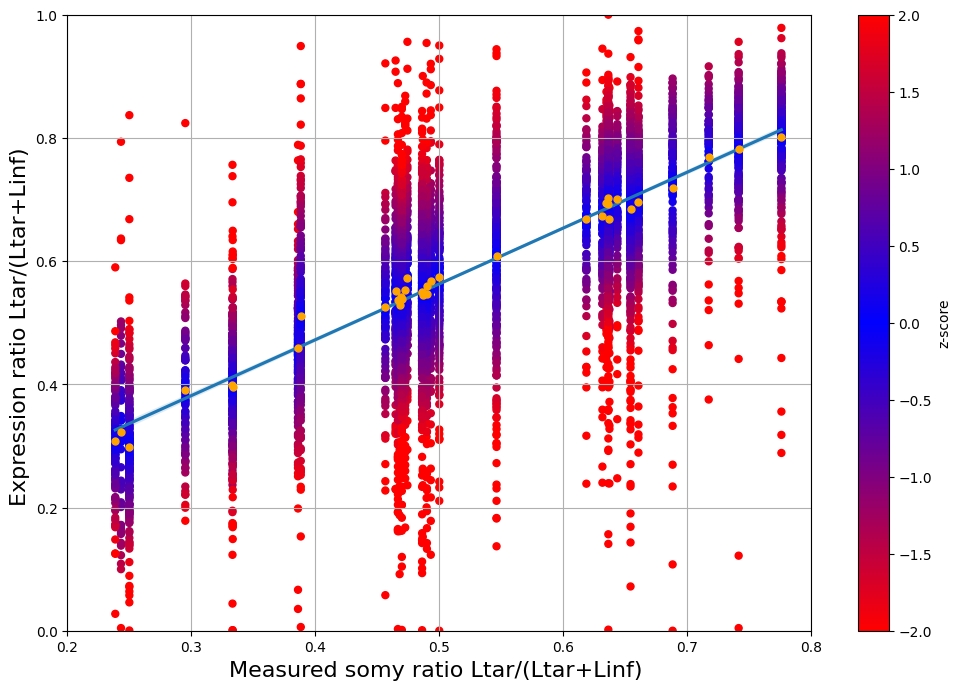

In [111]:
Y = []
X = []

for i, chrom in enumerate(range(1,36+1)):    
    data = all_ratios[i]
    Y.extend(data)
    X.extend( [somies["measured_ratio"].values[i]]  * len(data))

from scipy import stats

data_regression = pd.DataFrame({'measured_somies': X, 'RNA': Y})
sns.regplot(x="measured_somies", y="RNA", data=data_regression, x_jitter=0.0, scatter=False);

# Print results
slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
#plot(X, Y, "o")
xlim([0.2,0.8])
ylim([0.,1])

from colormap import Colormap
cmap2 = Colormap().cmap_linear(color1="red", color2="blue", color3="red", reverse=False)

for i, ratios in enumerate(all_ratios):
    N = len(ratios)
    somy = [somies["measured_ratio"].values[i]] * N
    subdf = somies["measured_ratio"].values[i]
    mu = mean(ratios)
    sigma = std(ratios)
    colors = (ratios - mu)/sigma 
    scatter(somy, ratios, alpha=1, c=colors, s=25, cmap=cmap2, vmin=-2, vmax=2);
cb = colorbar()
cb.set_label("z-score")

for i, chrom in enumerate(range(1,36+1)):    
    data = all_ratios[i]
    plot(somies["measured_ratio"].values[i], mean(data), 'o', color='orange', markersize=5)
        
grid(True)
R2 = round(r_value**2, 3)
#text(0.2,0.7 ,f"$R^2$={R2}", fontsize=16)
ylabel("Expression ratio Ltar/(Ltar+Linf) ", fontsize=16)
xlabel("Measured somy ratio Ltar/(Ltar+Linf) ", fontsize=16)
savefig("regression_gene_level")

In [112]:
# identify groups where the ratio is above a zscore of 1
chromosomes = range(1,37)
chrom_name = 10
subdf = ortho_groups.query("chr_name_inf == @chrom_name").copy()
subdf['ratios'] = all_ratios[chromosomes.index(chrom_name)]
subdf['Texp'] = all_Ts[chromosomes.index(chrom_name)]
subdf['Iexp'] = all_Is[chromosomes.index(chrom_name)]
T = subdf[abs((subdf['ratios'] - subdf.ratios.mean())/subdf.ratios.std()) >  1]
Ids_inf = list(flatten([x.split(",") for x in T.infantum]))
Ids_inf = [x.strip() for x in Ids_inf]
#T
#print(Tinfantum)
Ids_inf

['gene-LINF_100008900',
 'gene-LINF_100015600',
 'gene-LINF_100005800',
 'gene-LINF_100006100',
 'gene-LINF_100006400',
 'gene-LINF_100006900',
 'gene-LINF_100008000',
 'gene-LINF_100008300',
 'gene-LINF_100009900',
 'gene-LINF_100011600',
 'gene-LINF_100011700',
 'gene-LINF_100012200',
 'gene-LINF_100012900',
 'gene-LINF_100014000',
 'gene-LINF_100014400',
 'gene-LINF_100015100',
 'gene-LINF_100015500',
 'gene-LINF_100016300',
 'gene-LINF_100017100',
 'gene-LINF_100017200',
 'gene-LINF_100018200',
 'gene-LINF_100018700',
 'gene-LINF_100019000',
 'gene-LINF_100019300',
 'gene-LINF_100020300',
 'gene-LINF_100020800',
 'gene-LINF_100020900',
 'gene-LINF_100021000',
 'gene-LINF_100021200']

In [113]:
# identify groups where the ratio is above a zscore of 1
chromosomes = range(1,37)
chrom_name = 10
subdf = ortho_groups.query("chr_name_inf == @chrom_name").copy()
subdf['ratios'] = all_ratios[chromosomes.index(chrom_name)]
subdf['Texp'] = all_Ts[chromosomes.index(chrom_name)]
subdf['Iexp'] = all_Is[chromosomes.index(chrom_name)]
T = subdf[abs((subdf['ratios'] - subdf.ratios.mean())/subdf.ratios.std()) >  1]
Ids_inf = list(flatten([x.split(",") for x in T.infantum]))
Ids_inf = [x.strip() for x in Ids_inf]
#T
#print(Tinfantum)
Ids_inf
print(Ids_inf)

Ids_tar = list(flatten([x.split(",") for x in T.tarentolae]))
Ids_tar = [x.strip() for x in Ids_tar]
#T
print(Ids_tar)

['gene-LINF_100008900', 'gene-LINF_100015600', 'gene-LINF_100005800', 'gene-LINF_100006100', 'gene-LINF_100006400', 'gene-LINF_100006900', 'gene-LINF_100008000', 'gene-LINF_100008300', 'gene-LINF_100009900', 'gene-LINF_100011600', 'gene-LINF_100011700', 'gene-LINF_100012200', 'gene-LINF_100012900', 'gene-LINF_100014000', 'gene-LINF_100014400', 'gene-LINF_100015100', 'gene-LINF_100015500', 'gene-LINF_100016300', 'gene-LINF_100017100', 'gene-LINF_100017200', 'gene-LINF_100018200', 'gene-LINF_100018700', 'gene-LINF_100019000', 'gene-LINF_100019300', 'gene-LINF_100020300', 'gene-LINF_100020800', 'gene-LINF_100020900', 'gene-LINF_100021000', 'gene-LINF_100021200']
['gene-LtaPh_1003381', 'gene-LtaPh_1003461', 'gene-LtaPh_1003541', 'gene-LtaPh_1003621', 'gene-LtaPh_1003701', 'gene-LtaPh_1003861', 'gene-LtaPh_1004021', 'gene-LtaPh_1012751', 'gene-LtaPh_1012800', 'gene-LtaPh_1000600', 'gene-LtaPh_1000900', 'gene-LtaPh_1001200', 'gene-LtaPh_1001600', 'gene-LtaPh_1002500', 'gene-LtaPh_1002800', '

In [114]:
# identify groups where the ratio is above a zscore of 1
def get_outlier_genes(ortho_groups, threshold=2):
    
    chromosomes = range(1,37)
    Ids_inf = {}
    Ids_tar = {}
    for chrom_name in tqdm(chromosomes):
        subdf = ortho_groups.query("chr_name_inf == @chrom_name").copy()
        subdf['ratios'] = all_ratios[chromosomes.index(chrom_name)]
        subdf['Texp'] = all_Ts[chromosomes.index(chrom_name)]
        subdf['Iexp'] = all_Is[chromosomes.index(chrom_name)]
        if threshold > 0:
            T = subdf[(subdf['ratios'] - subdf.ratios.mean())/subdf.ratios.std() > threshold]
        else:
            T = subdf[(subdf['ratios'] - subdf.ratios.mean())/subdf.ratios.std() < threshold]    
        temp = list(flatten([x.split(",") for x in T.infantum]))
        Ids_inf[chrom_name] = [x.strip() for x in temp]
        
        temp = list(flatten([x.split(",") for x in T.tarentolae]))
        Ids_tar[chrom_name] = [x.strip() for x in temp]
    return Ids_inf, Ids_tar

# outliers are uniformly distributed along chromosomes

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 406.10it/s]


303 324 627


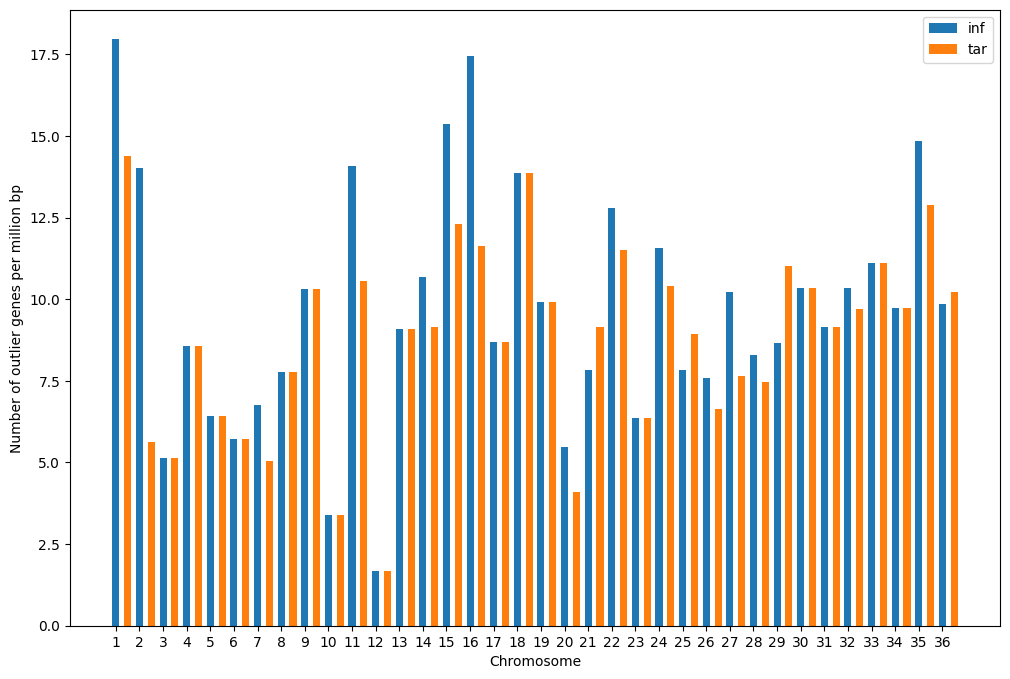

In [115]:
# we will normalise the data to see whether a chromosome is different
Ls = ginf.df.query('genetic_type=="region"')[['Name', 'stop']].stop.values

# let us get the number of genes in Linf and Ltar (should be coherent since we work with orthogroup)
inf, tar = get_outlier_genes(ortho_groups, threshold=-2)
Ninf = sum([len(v) for k,v in inf.items()])
Ntar = sum([len(v) for k,v in tar.items()])
print(Ntar, Ninf, Ntar+Ninf)

bar(sorted(inf.keys()), [len(inf[k])/Ls[i]*1e6 for i,k in enumerate(sorted(inf.keys()))], width=0.3 ,label="inf")
bar([x+0.5 for x in sorted(tar.keys())], [len(tar[k])/Ls[i]*1e6 for i,k in enumerate(sorted(tar.keys()))], width=0.3, label="tar")
_=xticks(range(1,37), range(1,37))
_=legend()
_=ylabel("Number of outlier genes per million bp")
_=xlabel("Chromosome")

# reuse DNA covering

use feature counts on dna data
see data/BAMs/feature_counts/runme.sh

In [116]:
dna = FeatureCount("data/BAMs/feature_counts/hyb_on_hyb.out")
dna = dna.df.reset_index()
dna

Geneid  hyb_on_hyb
0       gene-LtaPh_0100100         429
1       gene-LtaPh_0100200         678
2       gene-LtaPh_0100400         354
3       gene-LtaPh_0100451         349
4       gene-LtaPh_0100500         731
...                    ...         ...
17381  gene-LINF_360082000         207
17382  gene-LINF_360082100         199
17383  gene-LINF_360082200         289
17384  gene-LINF_360082300         146
17385  gene-LINF_360082400         248

[17386 rows x 2 columns]

In [117]:
all_ratios_dna = {}
all_Is_dna = {}
all_Ts_dna = {}
for chrom in tqdm(range(1,37)):
    ratios = []
    Is = []
    Ts = []
    
    subdf = ortho_groups.query("chr_name_inf == @chrom")
    for _, row in subdf.iterrows():
        group = row['Orthogroup']
        if "," in row['infantum']:
            genes = [x.strip() for x in row['infantum'].split(",")]
        else:
            genes = [row['infantum']]
    
        I = dna.query("Geneid in @genes")[['hyb_on_hyb']].sum().sum()    
    
        if "," in row['tarentolae']:
            genes = [x.strip() for x in row['tarentolae'].split(",")]
        else:
            genes = [row['tarentolae']]
    
        T = dna.query("Geneid in @genes")[['hyb_on_hyb']].sum().sum()    
    
        all_ratios_dna[group] = T / (T+I)
        all_Is_dna[group] = I
        all_Ts_dna[group] = T


ortho_groups['all_ratios_dna'] = [all_ratios_dna[k] for k in ortho_groups["Orthogroup"].values]
ortho_groups['Linf_coverage_dna'] = [all_Is_dna[k] for k in ortho_groups["Orthogroup"].values]
ortho_groups['Ltar_coverage_dna'] = [all_Ts_dna[k] for k in ortho_groups["Orthogroup"].values]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:25<00:00,  1.41it/s]


In [118]:
def get_2D_zscore(data, Y=None):

    #data = ortho_groups.query("chr_name_inf==26")
    if Y:
        DD = pd.DataFrame({'X':data,'Y':Y})
    else:
        DD = data[["all_ratios", "all_ratios_dna"]].copy()
    mus = np.mean(DD, axis=0)
    #covariance = np.cov(DD, rowvar=False)
    #z_scores = np.array([np.sqrt((point - mus).T @ np.linalg.inv(covariance) @ (point - mus)) for point in DD.values])

    
    # to avoid the normalisation issue, we can simply use the entire data set and build a matrix where off diagonal is zero
    variances = np.var(DD, axis=0, ddof=1)  # Use full dataset variances
    fixed_covariance = np.diag(variances)

     # Recompute z-scores using fixed covariance matrix
    z_scores = np.array([
        np.sqrt((point - mus).T @ np.linalg.inv(fixed_covariance) @ (point - mus)) 
        for point in DD.values
    ])


    return z_scores

from scipy.stats import zscore

In [119]:
import numpy as np
import pandas as pd

def _get_2D_zscore_with_outlier_removal(X, Y, percentile=95):
    # Create a DataFrame from the input data
    data = pd.DataFrame({'X': X, 'Y': Y})
    
    # Step 1: Compute initial z-scores
    means = np.mean(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    initial_z_scores = np.array([
        np.sqrt((point - means).T @ np.linalg.inv(covariance) @ (point - means)) 
        for point in data.values
    ])
    # Step 2: Determine the outlier threshold
    threshold = np.percentile(initial_z_scores, percentile)
    
    # Step 3: Filter out outliers
    filtered_data = data[initial_z_scores <= threshold]
    
    # Step 4: Recompute z-scores using the filtered data
    filtered_means = np.mean(filtered_data, axis=0)
    filtered_covariance = np.cov(filtered_data, rowvar=False)


    # Here, we set diagonal to zero on purpose because we do not expect diagonal from a biological point of view.
    # issue is that covariance is not normalised since input data changes. 
    filtered_covariance[0,1]=0
    filtered_covariance[1,0]=0

    final_z_scores = np.array([
        np.sqrt((point - filtered_means).T @ np.linalg.inv(filtered_covariance) @ (point - filtered_means)) 
        for point in data.values
    ])
    
    # to avoid the normalisation issue, we can simply use the entire data set and build a matrix where off diagonal is zero
    fixed_variances = np.var(data, axis=0, ddof=1)  # Use full dataset variances
    fixed_covariance = np.diag(fixed_variances)

     # Step 5: Recompute z-scores using fixed covariance matrix
    final_z_scores = np.array([
        np.sqrt((point - means).T @ np.linalg.inv(fixed_covariance) @ (point - means)) 
        for point in data.values
    ])
        
    
    return final_z_scores, filtered_data, threshold


Slope: 0.8988477216396087
Intercept: 0.10996509681481714
R-squared: 0.5795727848292409


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

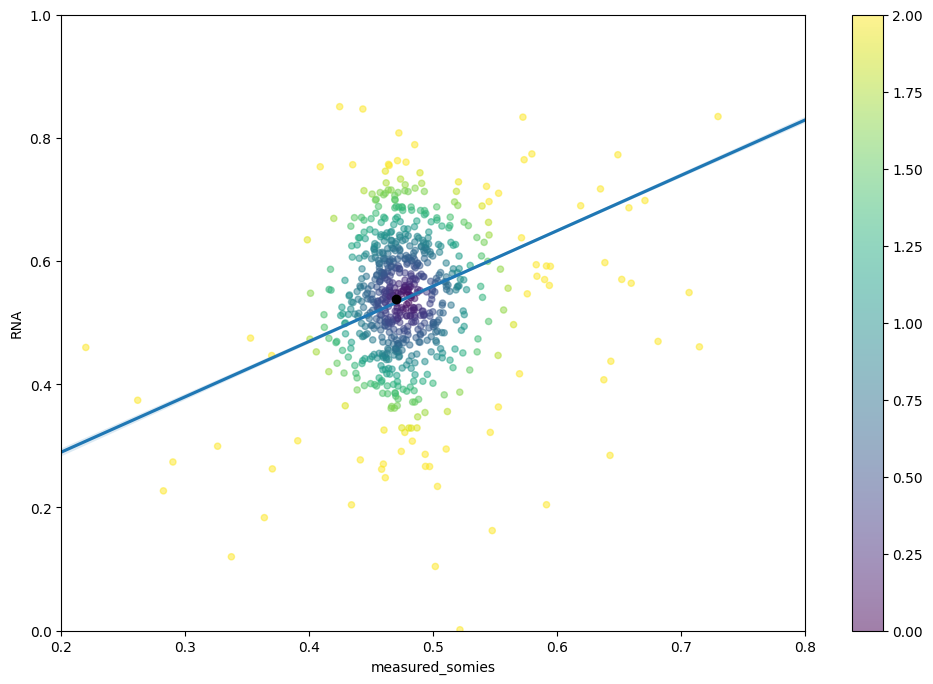

In [120]:
Y = ortho_groups["all_ratios"]
X = ortho_groups["all_ratios_dna"]


data_regression = pd.DataFrame({'measured_somies': X, 'RNA': Y})


sns.regplot(x="measured_somies", y="RNA", data=data_regression, x_jitter=0.0, scatter=False);
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
#plot(X, Y, "o")
xlim([0.2,0.8])
ylim([0.,1])


for i, chrom in enumerate(range(1,36+1)):    
    data = all_ratios[i]
    plot(somies["measured_ratio"].values[i], mean(data), 'o', color='orange', markersize=5)



plot_individuals = True
for i, chrom in enumerate(range(1,36+1)):
    if plot_individuals:
        clf()    
        sns.regplot(x="measured_somies", y="RNA", data=data_regression, x_jitter=0.0, scatter=False);
        xlim([0.2,0.8])
        ylim([0.,1])

    data = ortho_groups.query("chr_name_inf==@chrom")
    
    Y = data["all_ratios"]
    X = data["all_ratios_dna"]

    # zscore on the RNA  direction only
    ratios=Y
    mu = mean(ratios)
    sigma = std(ratios)
    colors = (ratios - mu)/sigma 

    # 2D zscore
    colors = get_2D_zscore(data)
        
    # Interpolate Z values onto the 2D grid

    #contour = plt.contour(xi, yi, zi, levels=4, linewidths=0.5, colors='k')
    #plt.contourf(xi, yi, zi, levels=5, cmap='viridis', alpha=0.7, zorder=-1)
    cmap='viridis'
    scatter(X, Y, c=colors, vmin=0, vmax=2, cmap=cmap, zorder=1, alpha=0.5, s=20)

    data = all_ratios[i]
    plot(somies["measured_ratio"].values[i], mean(Y), 'o', color='black', markersize=6)
    if plot_individuals:
        colorbar()
        savefig(f"double_ratio_{chrom}.png")
        
if not plot_individuals:
    colorbar()
    savefig(f"double_ratio_all")


In [121]:
def somy_ratio_transform(ortho_groups):
    count = 0
    newX = []
    newY = []
    for _, row in ortho_groups[["Ltar_expression", "Linf_expression", "Ltar_coverage_dna", "Linf_coverage_dna", "chr_name_inf"]].iterrows():
        a, b, x,y,z = row
        # somies
        dd = somies.query("chromosome==@z")
        star = dd['theo_somy_tar'].values[0]
        sinf = dd['theo_somy_inf'].values[0]
        count+=1
        R=(x/star) / (x/star+y/sinf)
        RR=(a/star)/(a/star+b/sinf) 
        newX.append(R)
        newY.append(RR)
    return newX, newY


In [122]:
newX, newY = somy_ratio_transform(ortho_groups)
#plot(newX, newY,  "o", color="orange", alpha=0.5)

In [123]:
# compute zscores
BlOrRe = Colormap().cmap_linear(color1="blue", color2="orange", color3="red", reverse=False)

def add_colored_area(angle_start=0, angle=30):
    import matplotlib.patches as patches
    # Define the original triangle vertices (before rotation)
    triangle = np.array([
        [0., 0.],   # First vertex
        [1, 0.], # Second vertex
        [cos(np.radians(angle)), sin(np.radians(angle))] # Third vertex
    ])

    # Define rotation matrix for 30 degrees
    theta = np.radians(angle_start)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    # Rotate the triangle
    rotated_triangle = np.dot(triangle, rotation_matrix.T)

    # Translate to (0.5, 0.5)
    translated_triangle = rotated_triangle + [X0, Y0]
    ax = gca()
    polygon = patches.Polygon(translated_triangle, closed=True, color='green', alpha=0.1)
    ax.add_patch(polygon)



def plot_dna_rna_plot(newX, newY, vmax=3, alpha=1, cmap=BlOrRe, angles=None):
    try:
        zscores
    except:
        zscores = get_2D_zscore(newX, newY)
    scatter(newX, newY, c=zscores, cmap=cmap, vmin=0, vmax=vmax, alpha=alpha)
    colorbar()

    xi = np.linspace(0, 1, 100)
    yi = np.linspace(0, 1, 100)
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((newX, newY), zscores, (xi, yi), method='cubic')  # Interpolate Z values on the grid

    # Contour plot
    levels = [1, 2, 3, 4, 6, 8, 10]
    contour = plt.contour(xi, yi, zi, levels=levels, colors='black', linewidths=1.2)
    plt.clabel(contour, inline=True, fontsize=10) #, fmt="%.1f")
    #plt.contourf(xi, yi, zi, levels=10, cmap='viridis', alpha=0.5)
    
    plot([mean(newX)],[mean(newY)],'ko')

    if angles:
        add_colored_area(angles[0], angles[1]-angles[0])
    
    #print(f"meanX:{mean(newX)} meanY:{mean(newY)}")
    xlabel("DNA reads ratio Ltar / (Ltar + Linf)")
    ylabel("RNA reads ratio Ltar / (Ltar + Linf)")
    grid()

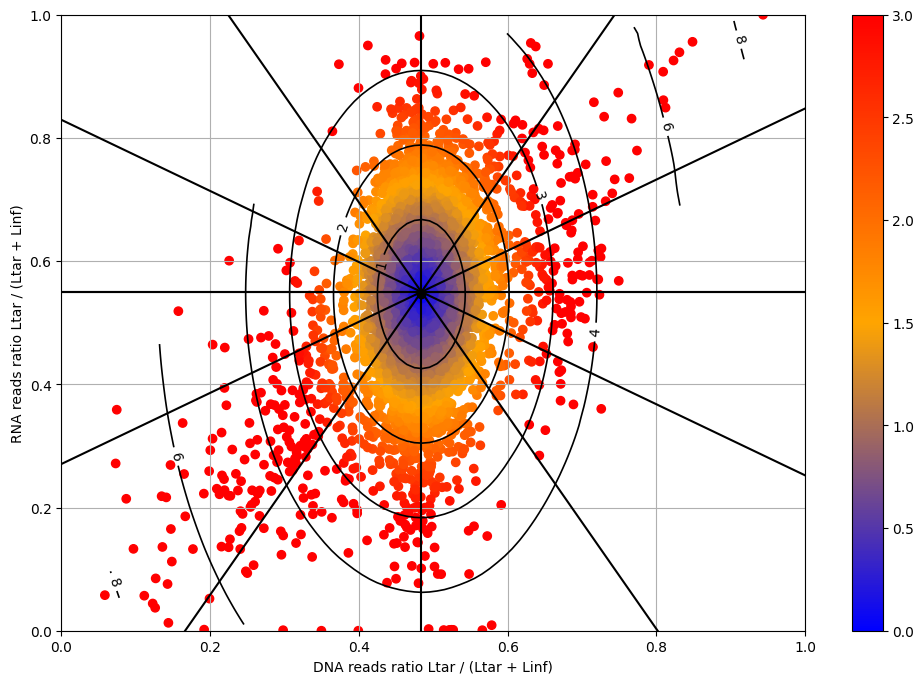

In [124]:

plot_dna_rna_plot(newX, newY)
savefig(f"figure_4D_dna_rna_plot")
X0 = 0.484
Y0 = 0.55
for x in [0,30,60,90,120,150,180]:
    plot([0.484,0.484+cos(pi*x/180)], [0.55,0.55+sin(pi*x/180)], "k-")
    plot([0.484,0.484+cos(pi*-x/180)], [0.55,0.55+sin(pi*-x/180)], "k-")
xlim([0,1])
ylim([0,1])   
savefig("dna_rna_plot_wih_grid")


The angle is between 0,180 on top and -180,0 in the bottom

In [125]:
ortho_groups['zscore_2d'] = get_2D_zscore(newX, newY)
ortho_groups['Xnormed'] = newX
ortho_groups['Ynormed'] = newY
ortho_groups
X = ortho_groups['Xnormed'] - mean(ortho_groups['Xnormed'])
Y=  ortho_groups['Ynormed'] - mean(ortho_groups['Ynormed'])

# just to help us later in selecting data
angles = np.degrees(np.arctan2(Y, X))
ortho_groups['angles'] = angles
min(angles), max(angles)

(-179.96908164927268, 179.87607319804695)

In [126]:
def get_outliers_normed(ortho_groups, threshold=2):
    data = ortho_groups[ortho_groups["zscore_2d"] > threshold]
  
    IDs=[]
    for x in data.infantum:
        IDs.extend(x.split(","))
    IDs = sorted([x.strip() for x in IDs])
    print(f"Found {len(IDs)} genes and  {len(data)} ortho groups")
    print(",".join([x.replace("gene-", "") for x in IDs]))
    return IDs


# Correspondance zscore 1D and 2D gaussian

In [127]:
import numpy as np
from scipy.stats import norm

# Define z-score or Mahalanobis distance
z_1d = 1.5  # Z-score in 1D
d_2d = 2  # Mahalanobis distance in 2D

# 1D Gaussian cumulative probability
p_1d = norm.cdf(z_1d) - norm.cdf(-z_1d)

# 2D Gaussian cumulative probability
p_2d = 1 - np.exp(-d_2d**2 / 2)

print(f"1D probability within ±{z_1d} z-score: {p_1d:.6f}")
print(f"2D probability within {d_2d} Mahalanobis distance: {p_2d:.6f}")


1D probability within ±1.5 z-score: 0.866386
2D probability within 2 Mahalanobis distance: 0.864665


In [128]:
# for various 1D zscore, estimate the 2D zscore
for z in [1,1.5, 2,2.54, 3,4,5]:
    # what is the PDF?
    p_1d = norm.cdf(z) - norm.cdf(-z)

    # from that PDF, what would be the zscore in 2D ?
    #p_2d = 1 - np.exp(-z**2 / 2)
    z_2d_values = np.sqrt(-2 * np.log(1 - p_1d))
    p_2d = 1 - np.exp(-z_2d_values**2 / 2)
    print(z, z_2d_values, p_2d, p_1d)
   

1 1.5151729039613386 0.6826894921370859 0.6826894921370859
1.5 2.006388407195349 0.8663855974622838 0.8663855974622838
2 2.4859755240637775 0.9544997361036416 0.9544997361036416
2.54 3.00071330322228 0.9889147531138347 0.9889147531138347
3 3.43935431177144 0.9973002039367398 0.9973002039367398
4 4.397034069908338 0.9999366575163338 0.9999366575163338
5 5.361315363467083 0.9999994266968562 0.9999994266968562


In [129]:
# the inverse. From 2D zscore, estimate 1D zscore
for z_2d_values in [1,2, 3, 4]:
    # what is the PDF?
    p_2d = 1 - np.exp(-z_2d_values**2 / 2)

    # here to account for 2-taisl proba, we divide by 2
    z = norm.ppf(1-(1-p_2d)/2)

    #
    p_1d = norm.cdf(z) - norm.cdf(-z)
    print(z, z_2d_values, p_2d, p_1d)
    

0.515031998812217 1 0.3934693402873666 0.3934693402873666
1.493389410657259 2 0.8646647167633873 0.8646647167633872
2.5392513972634996 3 0.9888910034617577 0.9888910034617577
3.5862536854618257 4 0.9996645373720975 0.9996645373720976


# GO map

## enrichment quadrant top right (zone_30_60_2)

- CC: nothing
- BP: nothing
- MF: nothing

In [147]:
# utility functions


def plot_genes(genes):
    found = []
    genes = set(genes)
    for _, row in ortho_groups.iterrows():
        group_genes = set([x.strip().replace('gene-','') for x in row.infantum.split(",")])
        found.append(True if genes.intersection(group_genes) else False)
                     
    for _, row in ortho_groups[found].iterrows():
        plot(row.Xnormed, row.Ynormed, 'og')
        
def plot_go_enrichment(go):
    go = go.copy()
    go = go.query("Bonferroni<0.05").sort_values('Odds ratio', ascending=False).reset_index()
    go['size'] = go['Result count']
    
    scatter = sns.scatterplot(
        data=go,
        x='Odds ratio',
        y='Name',
        size='size',
        hue='Bonferroni',
        sizes=(50, 500),
        palette='viridis',
        edgecolor='black',
        #hue_norm=(0,0.05),
        legend="brief",
        #size_norm=(5,20)\n",
        zorder=20
        )  

    grid(zorder=-20)
    handles, labels = scatter.get_legend_handles_labels()
    size_legend_idx = labels.index("size")
    legend(handles[size_legend_idx:], labels[size_legend_idx:],title="Size", loc="lower right")

    norm = plt.Normalize(go['Bonferroni'].min(), go['Bonferroni'].max())
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])  # Dummy array for the colorbar,
    cbar = plt.colorbar(sm, ax=gca())
    cbar.set_label('Combined Score', fontsize=12)
   
   
def plot_go_terms(tag):
    go = pd.concat([pd.read_csv(f"data/GO/BP_{tag}.tsv", sep="\t"), 
                    pd.read_csv(f"data/GO/MF_{tag}.tsv", sep="\t"), 
                    pd.read_csv(f"data/GO/CC_{tag}.tsv", sep="\t")])
    # remove obsolet terms
    IDs = [x for x in go.query("Bonferroni<0.05")["ID"] if x not in ["GO:0005355", "GO:0031224" ,"GO:0097159"]]
    from sequana.enrichment.quickgo import QuickGOGraph
    gr = QuickGOGraph()
    gr.save_chart(IDs, f"images_and_results/chart_{tag}.png")


    # identify max ignoring inf
    M = go.query("Bonferroni<0.05")['Odds ratio'][ go.query("Bonferroni<0.05").replace([np.inf, -np.inf], -1)['Odds ratio']!= -1].max()
    go.replace([np.inf, -np.inf], M+1, inplace=True)

    plot_go_enrichment(go)
    tight_layout()
    savefig(f"GO_{tag}")
    return  go.query("Bonferroni<0.05")



## enrichment quadrant top right (zone_30_60_2)

- CC: nothing
- BP: nothing
- MF: nothing

Found 87 genes and  80 ortho groups
LINF_020008900,LINF_020012430,LINF_060006300,LINF_060008200,LINF_060012800,LINF_070006900,LINF_070007000,LINF_070007100,LINF_080007600,LINF_080010000,LINF_080013400,LINF_080014600,LINF_080017100,LINF_090014800,LINF_100008900,LINF_100015600,LINF_100016300,LINF_100018500,LINF_100019300,LINF_100021200,LINF_120015500,LINF_140017150,LINF_150022750,LINF_160016600,LINF_160016700,LINF_160016900,LINF_170020300,LINF_190021600,LINF_200022000,LINF_200022100,LINF_200022200,LINF_210008900,LINF_210014900,LINF_210015900,LINF_210016000,LINF_210027500,LINF_220019100,LINF_220019500,LINF_220021500,LINF_220021700,LINF_230016500,LINF_230017200,LINF_230021200,LINF_240017700,LINF_240018000,LINF_260010300,LINF_260011300,LINF_260013400,LINF_260020900,LINF_260028800,LINF_260028900,LINF_260029800,LINF_270011100,LINF_270011200,LINF_270027400,LINF_290023400,LINF_300009600,LINF_300020000,LINF_300020200,LINF_300022100,LINF_300029600,LINF_310014700,LINF_310033500,LINF_310033550,LINF

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


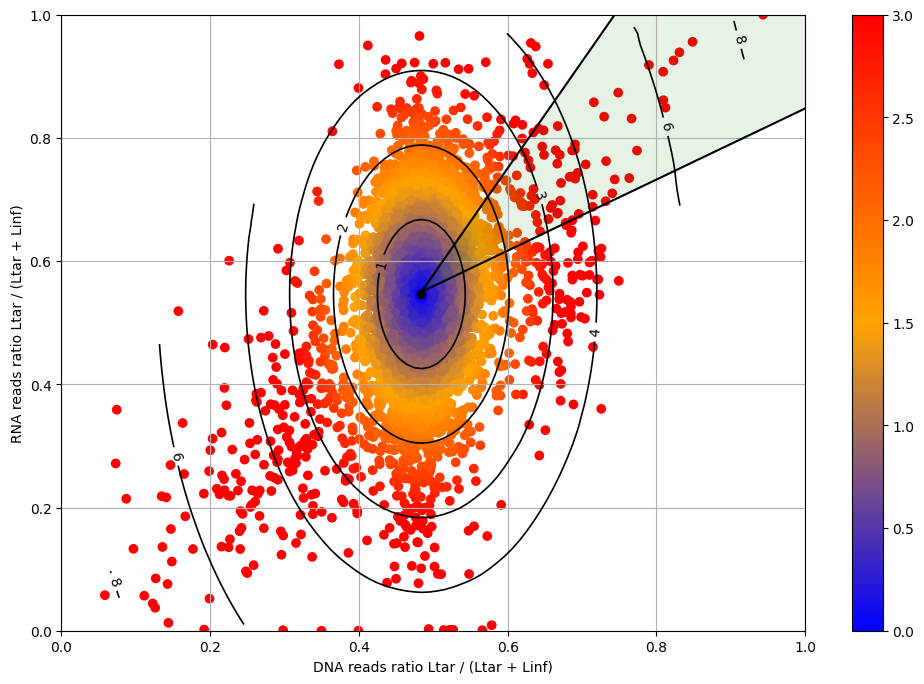

In [148]:
threshold = 2
plot_dna_rna_plot(newX, newY, angles=[30,60])
zone1 = ortho_groups.query("angles>30 and angles<60 and zscore_2d>@threshold")
#plot(zone1.Xnormed, zone1.Ynormed, "ok")
_ = get_outliers_normed(zone1, threshold)

plot([0.484,0.484+cos(pi*30/180)], [0.55,0.55+sin(pi*30/180)], "k-")
plot([0.484,0.484+cos(pi*60/180)], [0.55,0.55+sin(pi*60/180)], "k-") 
xlim([0,1])
ylim([0,1])
savefig('zone_30_60_2')

## enrichment quadrant top right (zone_60_70_2)

- CC: nothing
- BP: nothing
- MF: nothing

Found 41 genes and  40 ortho groups
LINF_010007500,LINF_010011200,LINF_020008000,LINF_060018500,LINF_090008800,LINF_090009600,LINF_090011700,LINF_110012300,LINF_120008400,LINF_140005600,LINF_140010200,LINF_140010300,LINF_160009400,LINF_220005500,LINF_220010300,LINF_220016600,LINF_220021600,LINF_230007500,LINF_230008300,LINF_230013700,LINF_240011900,LINF_250008600,LINF_250024700,LINF_250026500,LINF_270006200,LINF_270027200,LINF_270030800,LINF_280016100,LINF_280017800,LINF_280028500,LINF_280034400,LINF_290035300,LINF_310005700,LINF_310038000,LINF_320030500,LINF_330032600,LINF_350026200,LINF_350030400,LINF_350032700,LINF_360009000,LINF_360033900


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


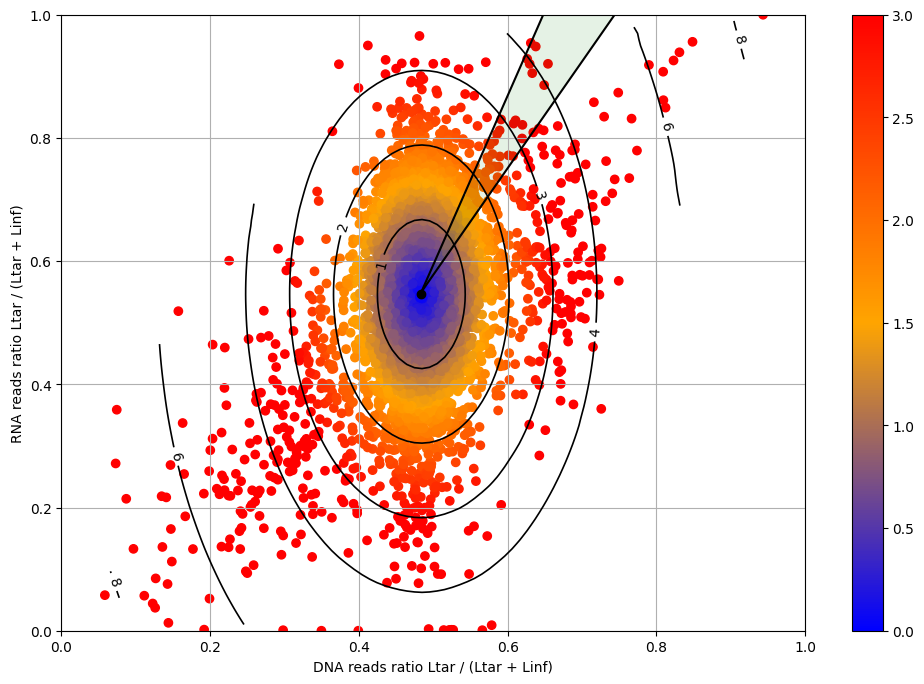

In [149]:
threshold = 2
plot_dna_rna_plot(newX, newY, angles=[60,70])
zone = ortho_groups.query("angles>60 and angles<70 and zscore_2d>@threshold")
#plot(zone.Xnormed, zone.Ynormed, "ok")
_=get_outliers_normed(zone, threshold)

plot([0.484,0.484+cos(pi*60/180)], [0.55,0.55+sin(pi*60/180)], "k-")
plot([0.484,0.484+cos(pi*70/180)], [0.55,0.55+sin(pi*70/180)], "k-") 
xlim([0,1])
ylim([0,1])
savefig("zone_60_70_2")

## enrichment zone 60-120 z=2

- CC: NA
- BP: NA
- MF: NA

Found 159 genes and  151 ortho groups
LINF_010007500,LINF_010011200,LINF_020008000,LINF_020008100,LINF_020010300,LINF_040006600,LINF_040006700,LINF_040006800,LINF_040007400,LINF_040011100,LINF_050009600,LINF_060016300,LINF_060016600,LINF_060018500,LINF_060019100,LINF_070006300,LINF_070009800,LINF_080006700,LINF_080011300,LINF_090005700,LINF_090008800,LINF_090009500,LINF_090009600,LINF_090010100,LINF_090011700,LINF_090012800,LINF_090017000,LINF_090019000,LINF_100009900,LINF_110012200,LINF_110012300,LINF_120008400,LINF_120009900,LINF_140005600,LINF_140010000,LINF_140010100,LINF_140010200,LINF_140010300,LINF_140015800,LINF_160009400,LINF_160012200,LINF_170009900,LINF_180007900,LINF_180008500,LINF_190010200,LINF_200008800,LINF_200011200,LINF_210025700,LINF_220005500,LINF_220006800,LINF_220008300,LINF_220010300,LINF_220011800,LINF_220016600,LINF_220018200,LINF_220020000,LINF_220021600,LINF_220022800,LINF_230007500,LINF_230008300,LINF_230012700,LINF_230012900,LINF_230013700,LINF_230014200,LI

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


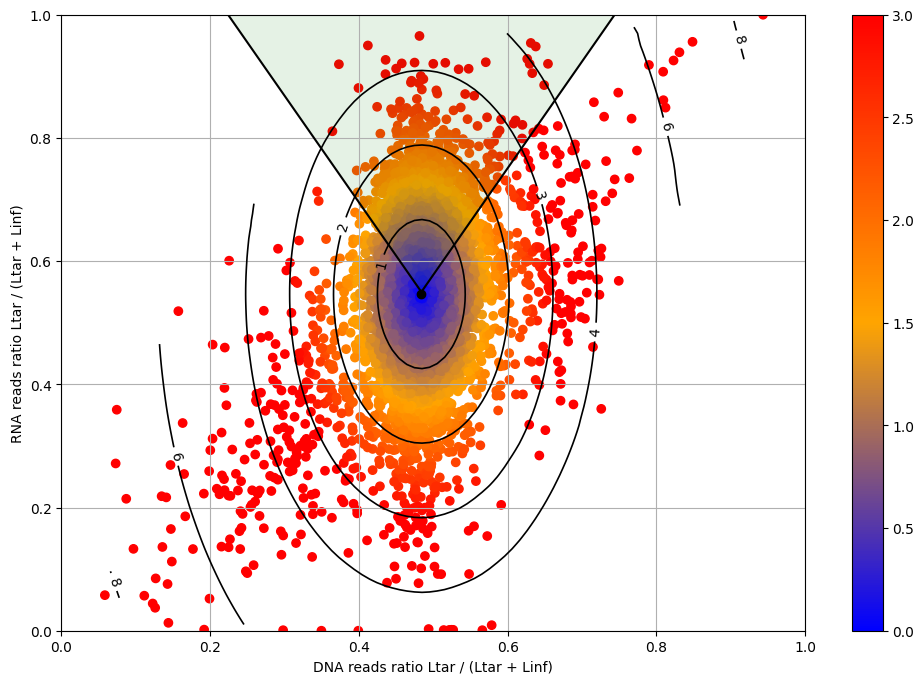

In [150]:
threshold = 2
plot_dna_rna_plot(newX, newY, angles=[60,120])

zone2 = ortho_groups.query("angles>60 and angles<120 and zscore_2d>@threshold")
#plot(zone2.Xnormed, zone2.Ynormed, "ok")
_=get_outliers_normed(zone2, threshold)

plot([0.484,0.484+cos(pi*60/180)], [0.55,0.55+sin(pi*60/180)], "k-")
plot([0.484,0.484+cos(pi*120/180)], [0.55,0.55+sin(pi*120/180)], "k-") 
xlim([0,1])
ylim([0,1])
savefig("zone_60_120_2")

#
#genes = list(flatten([x.split(",") for x in go['Result gene list'].values]))
#plot_genes(set([x.strip() for x in genes if x.strip()]))

In [151]:
go = plot_go_terms("zone_60_120_2")
go
#go.query("Bonferroni<0.05").sort_values('Bonferroni')

FileNotFoundError: [Errno 2] No such file or directory: 'data/GO/BP_zone_60_120_2.tsv'

## enrichment zone 150-210 z=2

- CC: NA
- BP: NA
- MF: NA

Found 74 genes and  41 ortho groups
LINF_030008650,LINF_030008700,LINF_060019200,LINF_070014400,LINF_070015700,LINF_080014700,LINF_080014800,LINF_080014900,LINF_080015000,LINF_080015100,LINF_080015200,LINF_080015300,LINF_080015400,LINF_080015500,LINF_090009900,LINF_090010000,LINF_090011600,LINF_090019700,LINF_090019800,LINF_130020500,LINF_130021200,LINF_160014600,LINF_170011100,LINF_170011200,LINF_180012400,LINF_190017700,LINF_190017800,LINF_200018500,LINF_200018600,LINF_210005500,LINF_210005600,LINF_210014400,LINF_230013600,LINF_230019800,LINF_230019900,LINF_240018100,LINF_260005800,LINF_260006100,LINF_270007100,LINF_270007300,LINF_270020900,LINF_270021100,LINF_270021300,LINF_290013900,LINF_290014000,LINF_290014100,LINF_290014500,LINF_290021500,LINF_290021600,LINF_290021700,LINF_290021800,LINF_310027000,LINF_310028900,LINF_310031200,LINF_310031300,LINF_320007900,LINF_330039800,LINF_340018000,LINF_340021100,LINF_340021200,LINF_340021300,LINF_350024200,LINF_350024300,LINF_350025400,LINF

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


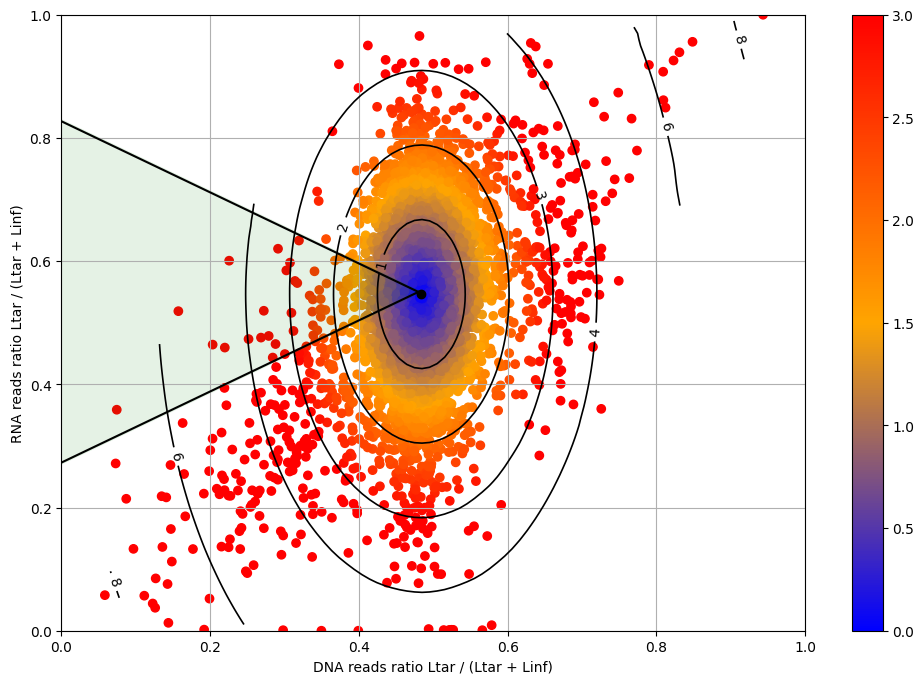

In [152]:
threshold = 2
plot_dna_rna_plot(newX, newY, angles=[150,210])
zone = ortho_groups.query("(angles>150 or angles<-150) and zscore_2d>@threshold")
#plot(zone.Xnormed, zone.Ynormed, "ok")
_=get_outliers_normed(zone, threshold)

plot([0.48,0.48+cos(pi*150/180)], [0.55,0.55+sin(pi*150/180)], "k-")
plot([0.48,0.48+cos(pi*+150/180)], [0.55,0.55+sin(pi*-150/180)], "k-") 
xlim([0,1])
ylim([0,1])
savefig("zone_150_210_2")


#genes = list(flatten([x.split(",") for x in go['Result gene list'].values]))
#plot_genes(set([x.strip() for x in genes if x.strip()]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ID                                               Name  Bgd count  \
0   GO:0015749             monosaccharide transmembrane transport          3   
1   GO:0034219               carbohydrate transmembrane transport          3   
2   GO:0008645                     hexose transmembrane transport          3   
3   GO:1904659                    glucose transmembrane transport          3   
4   GO:0055085                            transmembrane transport        192   
5   GO:0008643                             carbohydrate transport          4   
6   GO:0006508                                        proteolysis        165   
7   GO:0006810                                          transport        440   
8   GO:0015752                   D-ribose transmembrane transport          2   
9   GO:0015750                    pentose transmembrane transport          2   
10  GO:0051234                      establishment of localization        441   
11  GO:0051179                                       localization        462   
12  GO:0007034                                 vacuolar transport         12   
13  GO:0072523       purine-containing compound catabolic process          3   
0   GO:0008234                   cysteine-type peptidase activity         69   
1   GO:0004197               cysteine-type endopeptidase activity         42   
2   GO:0015149          hexose transmembrane transporter activity          3   
3   GO:0005353        fructose transmembrane transporter activity          3   
4   GO:0005354       galactose transmembrane transporter activity          3   
5   GO:0005355         glucose transmembrane transporter activity          3   
6   GO:0051119           sugar transmembrane transporter activity          3   
7   GO:0015578         mannose transmembrane transporter activity          3   
8   GO:0015145  monosaccharide transmembrane transporter activity          3   
9   GO:0022857                 transmembrane transporter activity        207   
10  GO:0005215                               transporter activity        213   
11  GO:0015144    carbohydrate transmembrane transporter activity          4   
12  GO:0008233                                 peptidase activity        154   
13  GO:0004175                             endopeptidase activity         94   
14  GO:0015591        D-ribose transmembrane transporter activity          2   
15  GO:0055056       D-glucose transmembrane transporter activity          2   
16  GO:0015146         pentose transmembrane transporter activity          2   
0   GO:0051286                                           cell tip         36   
1   GO:0060187                                          cell pole         37   
2   GO:0070258                    inner membrane pellicle complex          2   
3   GO:0016021                     integral component of membrane        252   
4   GO:0031224                    intrinsic component of membrane        254   
5   GO:0020039                                           pellicle          3   

    Result count                                   Result gene list  \
0              3      LINF_360072800,LINF_360073200,LINF_360073600,   
1              3      LINF_360072800,LINF_360073200,LINF_360073600,   
2              3      LINF_360072800,LINF_360073200,LINF_360073600,   
3              3      LINF_360072800,LINF_360073200,LINF_360073600,   
4             12  LINF_290021500,LINF_290021600,LINF_290021700,L...   
5              3      LINF_360072800,LINF_360073200,LINF_360073600,   
6              9  LINF_080014700,LINF_080014800,LINF_080014900,L...   
7             15  LINF_270020900,LINF_270021100,LINF_270021300,L...   
8              2                     LINF_360072800,LINF_360073200,   
9              2                     LINF_360072800,LINF_360073200,   
10            15  LINF_270020900,LINF_270021100,LINF_270021300,L...   
11            15  LINF_270020900,LINF_270021100,LINF_270021300,L...   
12             3      LINF_270020900,LINF_270021

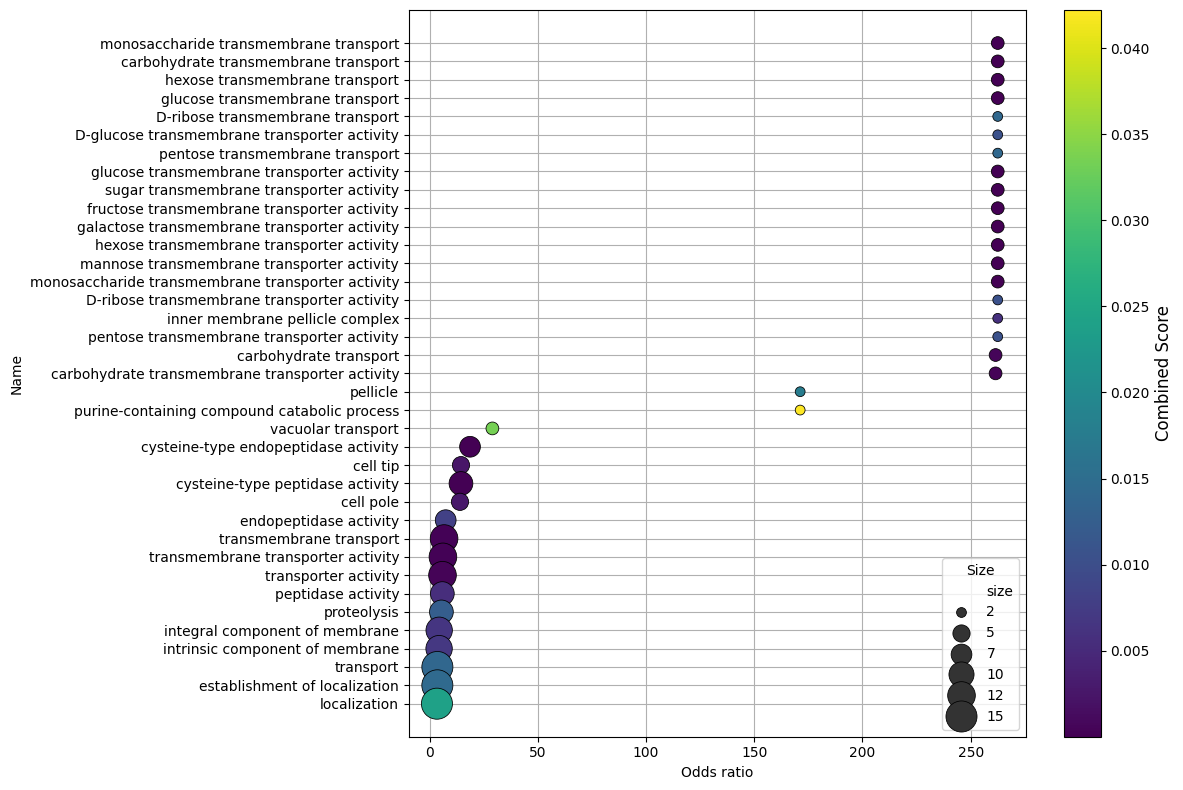

In [153]:
go = plot_go_terms("zone_150_210_2")
go


## enrichment zone 210-260 z=2

- CC: 
- BP: 
- MF: 

Found 269 genes and  207 ortho groups
LINF_010010000,LINF_010010300,LINF_020006700,LINF_020006800,LINF_020006900,LINF_020007000,LINF_020007100,LINF_020007600,LINF_040006200,LINF_040006400,LINF_040007600,LINF_040008600,LINF_040009300,LINF_040010000,LINF_040014000,LINF_040017100,LINF_050013200,LINF_060008400,LINF_070009100,LINF_070012600,LINF_070013900,LINF_080011100,LINF_080013800,LINF_090006400,LINF_090006500,LINF_090011500,LINF_090011800,LINF_090011900,LINF_090012000,LINF_100013400,LINF_100017100,LINF_100019000,LINF_110007500,LINF_110007800,LINF_110008700,LINF_110009400,LINF_110010800,LINF_110012400,LINF_110012500,LINF_110012700,LINF_110018150,LINF_110018200,LINF_110018300,LINF_110018350,LINF_110018400,LINF_110018700,LINF_130006900,LINF_140008900,LINF_140009000,LINF_140009100,LINF_140009200,LINF_140012900,LINF_140013000,LINF_140017400,LINF_140017500,LINF_150008400,LINF_150009100,LINF_150009200,LINF_150012400,LINF_150017200,LINF_150019500,LINF_150019600,LINF_150021700,LINF_160006300,LI

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


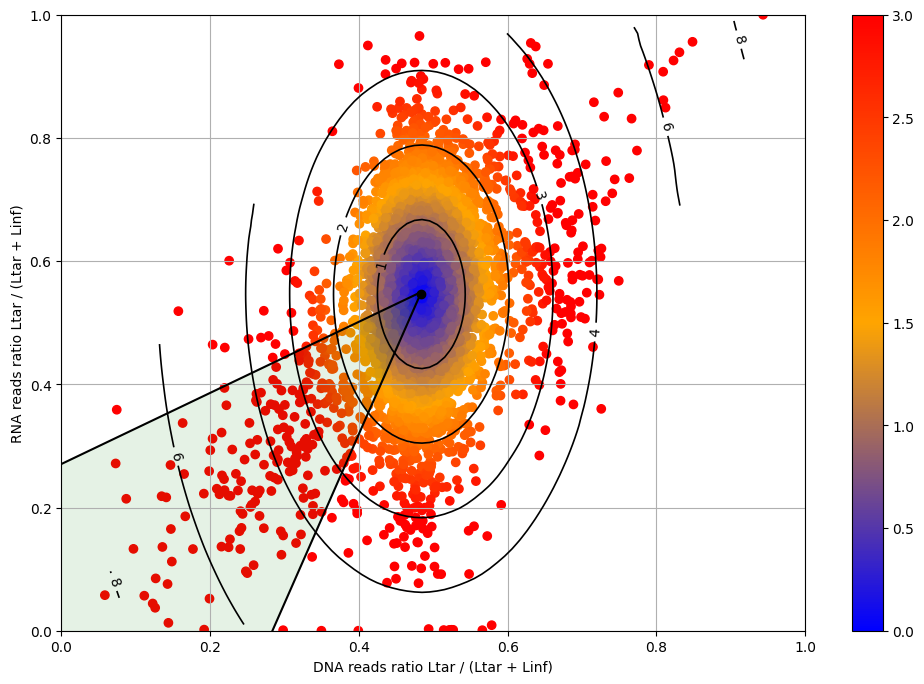

In [154]:
threshold = 2
plot_dna_rna_plot(newX, newY, angles=[210, 250])
zone = ortho_groups.query("angles>-150 and angles<-110 and zscore_2d>@threshold")
#plot(zone.Xnormed, zone.Ynormed, "ok")
_=get_outliers_normed(zone, threshold)


plot([0.484,0.484+cos(pi*-150/180)], [0.55,0.55+sin(pi*-150/180)], "k-")
plot([0.484,0.484+cos(pi*-110/180)], [0.55,0.55+sin(pi*-110/180)], "k-") 
xlim([0,1])
ylim([0,1])
savefig("zone_210_260_2")
#plot ribosome genes
#plot_genes(['LINF_150009100', 'LINF_150009200', 'LINF_150019500', 'LINF_150019600', 'LINF_220009800', 'LINF_220010100', 'LINF_260021300', 'LINF_260021400', 'LINF_260021500', 'LINF_300011800', 'LINF_300011900', 'LINF_300012000', 'LINF_350023700', 'LINF_350023800', 'LINF_350023900', 'LINF_350024100', 'LINF_360015100', 'LINF_360015200'])


#genes = list(flatten([x.split(",") for x in go['Result gene list'].values]))
#plot_genes(set([x.strip() for x in genes if x.strip()]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ID                                               Name  Bgd count  \
0  GO:0042127        regulation of cell population proliferation          4   
1  GO:0006952                                   defense response          3   
2  GO:0008284  positive regulation of cell population prolife...          3   
3  GO:0055085                            transmembrane transport        192   
0  GO:0042626  ATPase-coupled transmembrane transporter activity         56   
1  GO:0022804          active transmembrane transporter activity         87   
2  GO:0008097                                    5S rRNA binding          3   
3  GO:0003735                 structural constituent of ribosome        184   
4  GO:0005198                       structural molecule activity        223   
5  GO:0015399  primary active transmembrane transporter activity         68   
6  GO:0005215                               transporter activity        213   
0  GO:0005840                                           ribosome        186   

   Result count                                   Result gene list  \
0             4  LINF_250019700,LINF_350027300,LINF_350027400,L...   
1             3      LINF_350027300,LINF_350027400,LINF_350027500,   
2             3      LINF_350027300,LINF_350027400,LINF_350027500,   
3            18  LINF_110018150,LINF_110018200,LINF_110018300,L...   
0            10  LINF_110018150,LINF_110018200,LINF_110018300,L...   
1            12  LINF_110018150,LINF_110018200,LINF_110018300,L...   
2             3      LINF_350023700,LINF_350023800,LINF_350023900,   
3            18  LINF_150009100,LINF_150009200,LINF_150019500,L...   
4            20  LINF_100017100,LINF_150009100,LINF_150009200,L...   
5            10  LINF_110018150,LINF_110018200,LINF_110018300,L...   
6            19  LINF_110018150,LINF_110018200,LINF_110018300,L...   
0            18  LINF_150009100,LINF_150009200,LINF_150019500,L...   

   Pct of bgd  Fold enrichment  Odds ratio   P-value  Benjamini  Bonferroni  
0       100.0            29.23        7.47  0.000001   0.000459    0.000459  
1       100.0            29.23        7.47  0.000039   0.004549    0.013646  
2       100.0            29.23        7.47  0.000039   0.004549    0.013646  
3         9.4             2.74        3.15  0.000081   0.006985    0.027939  
0        17.9             5.22        6.47  0.000015   0.001958    0.002611  
1        13.8             4.03        4.79  0.000033   0.001958    0.005620  
2       100.0            29.23        7.47  0.000039   0.001958    0.006725  
3         9.8             2.86        3.31  0.000046   0.001958    0.007832  
4         9.0             2.62        3.03  0.000060   0.002041    0.010206  
5        14.7             4.30        5.12  0.000087   0.002430    0.014954  
6         8.9             2.61        2.99  0.000099   0.002430    0.017013  
0         9.7             2.83        3.27  0.000053   0.005239    0.005239

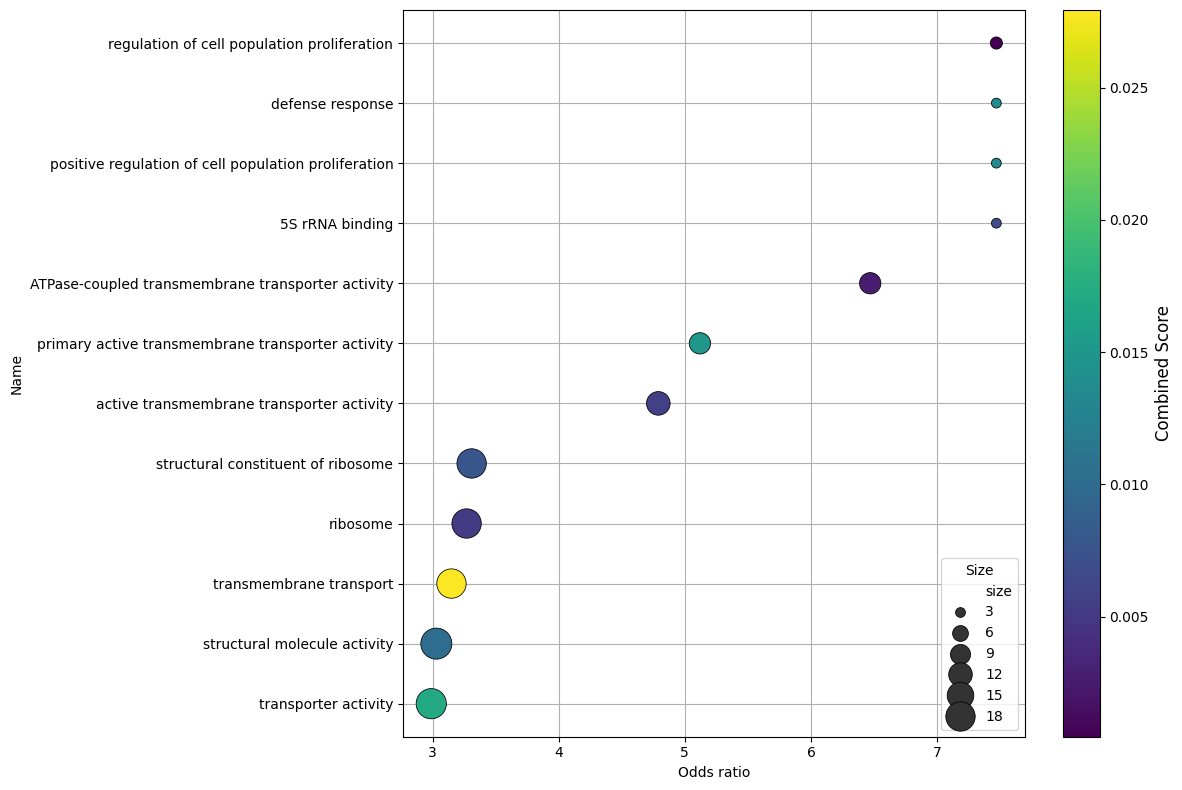

In [157]:
go = plot_go_terms("zone_210_260_2")
go

## enrichment zone 250 - 290

- CC: 
- BP: phospho
- MF: kinase

Found 212 genes and  201 ortho groups
LINF_010005000,LINF_010005300,LINF_010005600,LINF_010005700,LINF_020005600,LINF_020006000,LINF_020006200,LINF_030009300,LINF_040006300,LINF_050012800,LINF_050014200,LINF_050015100,LINF_060010000,LINF_060011200,LINF_070015200,LINF_070016100,LINF_070016200,LINF_070018400,LINF_080006600,LINF_080011600,LINF_080013100,LINF_090005900,LINF_090006000,LINF_090015000,LINF_100005800,LINF_100012200,LINF_110009500,LINF_110012900,LINF_110016000,LINF_120010200,LINF_120010700,LINF_130012000,LINF_130017100,LINF_130018300,LINF_130019000,LINF_130021100,LINF_140009900,LINF_140015200,LINF_150008600,LINF_150015400,LINF_150015500,LINF_150016000,LINF_150016300,LINF_150017800,LINF_160006800,LINF_160008800,LINF_170007300,LINF_170010400,LINF_170016000,LINF_170018300,LINF_180006700,LINF_180006800,LINF_180011700,LINF_180018700,LINF_180018900,LINF_180019600,LINF_180019900,LINF_180020600,LINF_180020700,LINF_180020800,LINF_190007500,LINF_190008900,LINF_190010800,LINF_190018400,LI

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


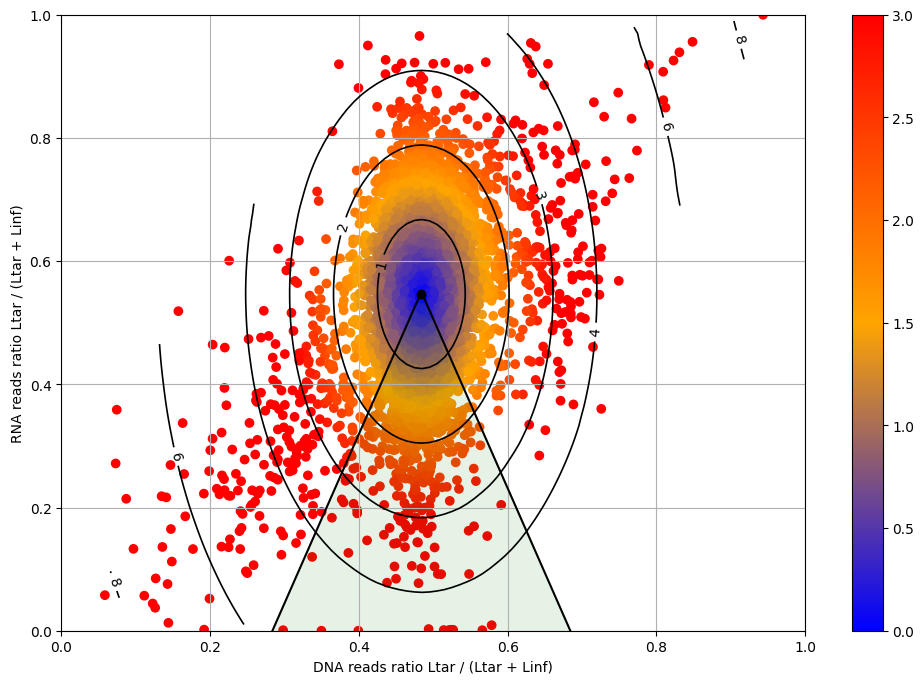

In [158]:
threshold = 2
plot_dna_rna_plot(newX, newY, angles=[250,290])
zone = ortho_groups.query("angles>-110 and angles<-70 and zscore_2d>@threshold")
#plot(zone.Xnormed, zone.Ynormed, "ok")
_=get_outliers_normed(zone, threshold)


plot([0.484,0.484+cos(pi*-110/180)], [0.55,0.55+sin(pi*-110/180)], "k-")
plot([0.484,0.484+cos(pi*-70/180)], [0.55,0.55+sin(pi*-70/180)], "k-") 
xlim([0,1])
ylim([0,1])
ax = gca()
savefig("zone_250_290_2")

#genes = list(flatten([x.split(",") for x in go['Result gene list'].values]))
#plot_genes(set([x.strip() for x in genes if x.strip()]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ID                                               Name  Bgd count  \
0  GO:0016310                                    phosphorylation        231   
1  GO:0006468                            protein phosphorylation        205   
2  GO:0140115                      export across plasma membrane          3   
3  GO:0120029               proton export across plasma membrane          3   
0  GO:0004672                            protein kinase activity        210   
1  GO:0008553       P-type proton-exporting transporter activity          3   
2  GO:0016773  phosphotransferase activity, alcohol group as ...        257   
3  GO:0043167                                        ion binding       1143   
4  GO:1901363                      heterocyclic compound binding       1368   
5  GO:0097159                    organic cyclic compound binding       1368   
6  GO:0016301                                    kinase activity        290   
7  GO:0015662                    P-type ion transporter activity          6   
8  GO:0140358          P-type transmembrane transporter activity          6   

   Result count                                   Result gene list  \
0            20  LINF_020006200,LINF_070015200,LINF_110016000,L...   
1            18  LINF_020006200,LINF_070015200,LINF_150015500,L...   
2             3      LINF_180020600,LINF_180020700,LINF_180020800,   
3             3      LINF_180020600,LINF_180020700,LINF_180020800,   
0            18  LINF_020006200,LINF_070015200,LINF_150015500,L...   
1             3      LINF_180020600,LINF_180020700,LINF_180020800,   
2            19  LINF_020006200,LINF_070015200,LINF_110016000,L...   
3            50  LINF_020006000,LINF_050012800,LINF_070015200,L...   
4            55  LINF_040006300,LINF_050012800,LINF_070015200,L...   
5            55  LINF_040006300,LINF_050012800,LINF_070015200,L...   
6            19  LINF_020006200,LINF_070015200,LINF_110016000,L...   
7             3      LINF_180020600,LINF_180020700,LINF_180020800,   
8             3      LINF_180020600,LINF_180020700,LINF_180020800,   

   Pct of bgd  Fold enrichment  Odds ratio   P-value  Benjamini  Bonferroni  
0         8.7             3.33        4.04  0.000001   0.000448    0.000448  
1         8.8             3.38        4.05  0.000004   0.000654    0.001308  
2       100.0            38.52       39.41  0.000017   0.001304    0.005215  
3       100.0            38.52       39.41  0.000017   0.001304    0.005215  
0         8.6             3.30        3.94  0.000006   0.000918    0.000918  
1       100.0            38.52       39.41  0.000017   0.001220    0.002599  
2         7.4             2.85        3.35  0.000028   0.001220    0.004218  
3         4.4             1.68        2.19  0.000032   0.001220    0.004878  
4         4.0             1.55        2.01  0.000122   0.003089    0.018534  
5         4.0             1.55        2.01  0.000122   0.003089    0.018534  
6         6.6             2.52        2.92  0.000145   0.003139    0.021976  
7        50.0            19.26       38.41  0.000323   0.005452    0.049071  
8        50.0            19.26       38.41  0.000323   0.005452    0.049071

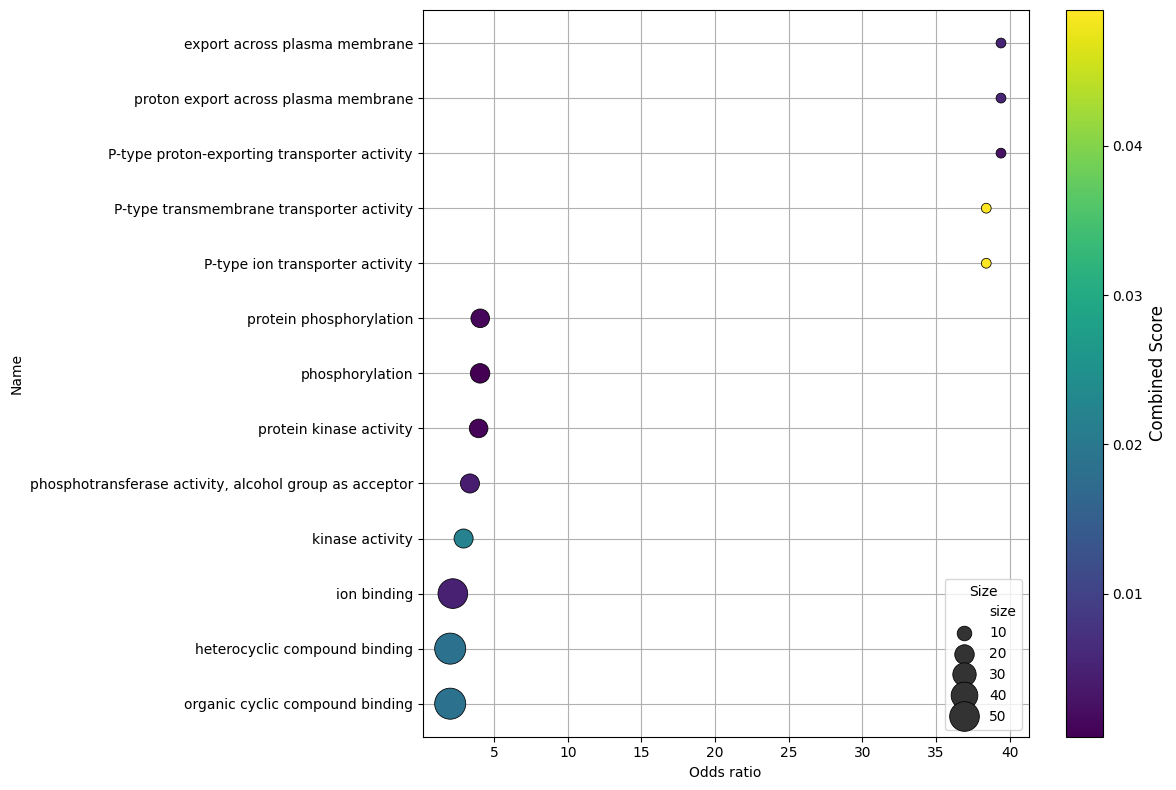

In [160]:
go = plot_go_terms("zone_250_290_2")
go

## enrichment zone 300 - 30

- CC: 
- BP: 
- MF: 

Found 149 genes and  119 ortho groups
LINF_010009200,LINF_010009300,LINF_010012000,LINF_020005800,LINF_020007700,LINF_020010800,LINF_030008500,LINF_030012400,LINF_030014900,LINF_040008500,LINF_050017100,LINF_070013200,LINF_070013400,LINF_070013700,LINF_080009700,LINF_080017300,LINF_090005600,LINF_100007000,LINF_100007900,LINF_100013200,LINF_120011100,LINF_120016900,LINF_130007700,LINF_130007800,LINF_130007900,LINF_130008000,LINF_130008100,LINF_130008200,LINF_130008300,LINF_130008400,LINF_130008500,LINF_130008600,LINF_130008700,LINF_130008800,LINF_130017000,LINF_130017200,LINF_130017300,LINF_140012800,LINF_150008100,LINF_150008200,LINF_150009600,LINF_150012100,LINF_160008000,LINF_160010000,LINF_160011100,LINF_160016000,LINF_160017200,LINF_170015700,LINF_170020800,LINF_180012600,LINF_180017000,LINF_180017600,LINF_180017700,LINF_190005100,LINF_190009100,LINF_200008100,LINF_210006400,LINF_210023000,LINF_220007200,LINF_220007700,LINF_220012900,LINF_230007100,LINF_230008700,LINF_230023000,LI

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


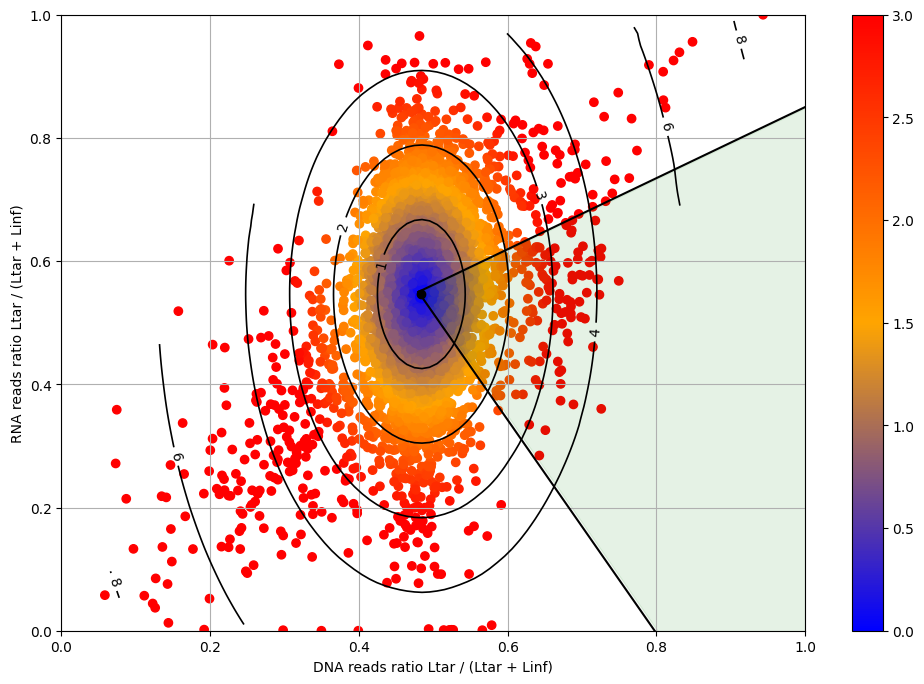

In [161]:
threshold = 2
plot_dna_rna_plot(newX, newY, angles=[300,30])
zone = ortho_groups.query("angles>-60 and angles<30 and zscore_2d>@threshold")
#plot(zone.Xnormed, zone.Ynormed, "ok")
_=get_outliers_normed(zone, threshold)
plot([0.48,0.48+cos(pi*30/180)], [0.55,0.55+sin(pi*30/180)], "k-")
plot([0.48,0.48+cos(pi*60/180)], [0.55,0.55-sin(pi*60/180)], "k-") 
xlim([0,1])
ylim([0,1])
savefig("zone_300_30")
#genes = list(flatten([x.split(",") for x in go['Result gene list'].values]))
#plot_genes(set([x.strip() for x in genes if x.strip()]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ID                                               Name  Bgd count  \
0   GO:0007017                          microtubule-based process        163   
0   GO:0005200             structural constituent of cytoskeleton         21   
1   GO:0005198                       structural molecule activity        223   
2   GO:0003924                                    GTPase activity         92   
3   GO:0019001                          guanyl nucleotide binding        130   
4   GO:0005525                                        GTP binding        130   
5   GO:0032561                      guanyl ribonucleotide binding        130   
6   GO:0017111                 nucleoside-triphosphatase activity        192   
7   GO:0016462                           pyrophosphatase activity        200   
8   GO:0016818  hydrolase activity, acting on acid anhydrides,...        206   
9   GO:0016817      hydrolase activity, acting on acid anhydrides        209   
0   GO:0099512                               supramolecular fiber         27   
1   GO:0099081                             supramolecular polymer         27   
2   GO:0005874                                        microtubule         27   
3   GO:0099513                       polymeric cytoskeletal fiber         27   
4   GO:0099080                             supramolecular complex         57   
5   GO:0015630                           microtubule cytoskeleton        176   
6   GO:0043232       intracellular non-membrane-bounded organelle        800   
7   GO:0043228                     non-membrane-bounded organelle        801   
8   GO:0005856                                       cytoskeleton        351   
9   GO:0005622                 intracellular anatomical structure       2696   
10  GO:0043229                            intracellular organelle       1818   
11  GO:0043226                                          organelle       1996   

    Result count                                   Result gene list  \
0             14  LINF_130007700,LINF_130007800,LINF_130007900,L...   
0             12  LINF_130007700,LINF_130007800,LINF_130007900,L...   
1             21  LINF_010009200,LINF_010009300,LINF_130007700,L...   
2             14  LINF_130007700,LINF_130007800,LINF_130007900,L...   
3             15  LINF_040008500,LINF_130007700,LINF_130007800,L...   
4             15  LINF_040008500,LINF_130007700,LINF_130007800,L...   
5             15  LINF_040008500,LINF_130007700,LINF_130007800,L...   
6             15  LINF_130007700,LINF_130007800,LINF_130007900,L...   
7             15  LINF_130007700,LINF_130007800,LINF_130007900,L...   
8             15  LINF_130007700,LINF_130007800,LINF_130007900,L...   
9             15  LINF_130007700,LINF_130007800,LINF_130007900,L...   
0             12  LINF_130007700,LINF_130007800,LINF_130007900,L...   
1             12  LINF_130007700,LINF_130007800,LINF_130007900,L...   
2             12  LINF_130007700,LINF_130007800,LINF_130007900,L...   
3             12  LINF_130007700,LINF_130007800,LINF_130007900,L...   
4             12  LINF_130007700,LINF_130007800,LINF_130007900,L...   
5             15  LINF_130007700,LINF_130007800,LINF_130007900,L...   
6             32  LINF_010009200,LINF_010009300,LINF_030014900,L...   
7             32  LINF_010009200,LINF_010009300,LINF_030014900,L...   
8             19  LINF_100007000,LINF_130007700,LINF_130007800,L...   
9             69  LINF_010009200,LINF_010009300,LINF_030012400,L...   
10            52  LINF_010009200,LINF_010009300,LINF_030012400,L...   
11            54  LINF_010009200,LINF_010009300,LINF_030012400,L...   

    Pct of bgd  Fold enrichment  Odds ratio       P-value     Benjamini  \
0          8.6             4.58        5.63  1.502925e-06  4.268307e-04   
0         57.1            30.47       80.22  2.301550e-16  3.659465e-14   
1          9.4             5.02        6.77  4.042056e-10  3.213434e-08   
2         15.2             8.12       10.92  9.207082e-10  4.879753e-08   
3         1

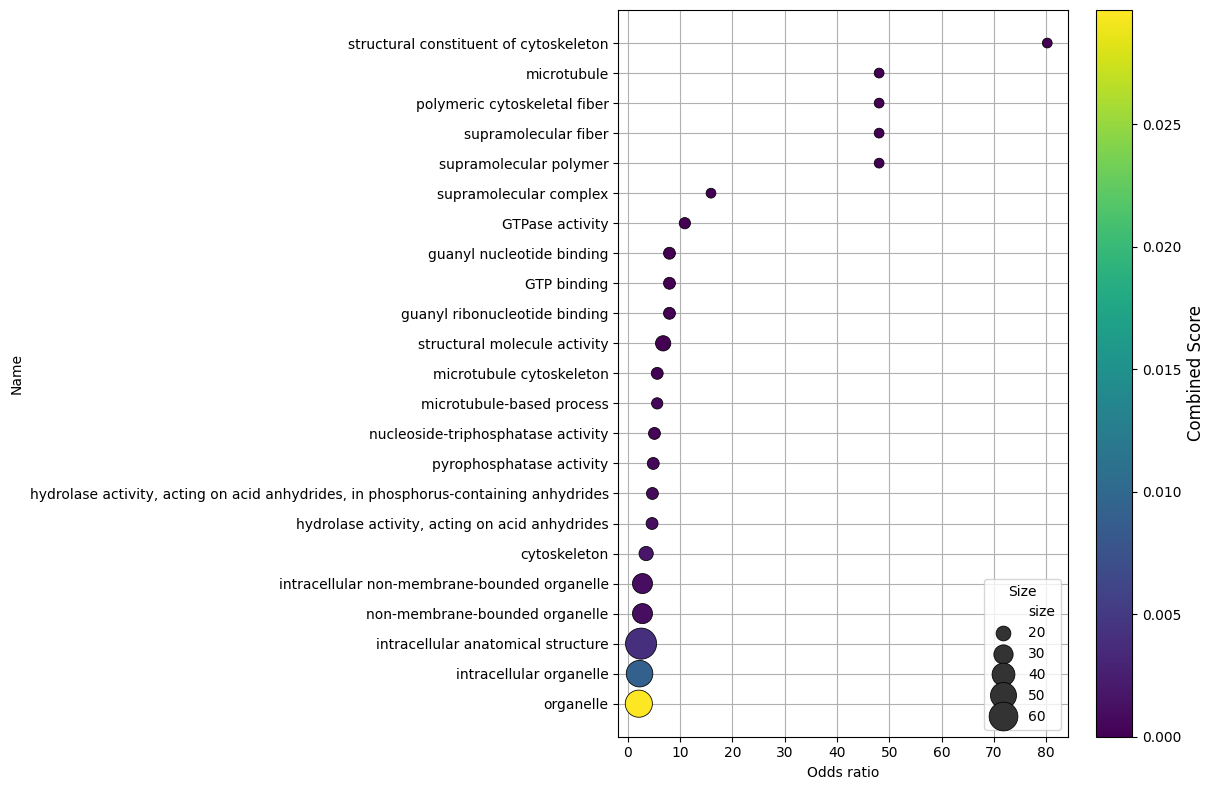

In [163]:
go = plot_go_terms("zone_300_30_2")
go

# zone 5: all zscore >2

Found 956 genes and  803 ortho groups
LINF_010005000,LINF_010005300,LINF_010005600,LINF_010005700,LINF_010007500,LINF_010009200,LINF_010009300,LINF_010010000,LINF_010010300,LINF_010011200,LINF_010012000,LINF_020005600,LINF_020005800,LINF_020006000,LINF_020006200,LINF_020006700,LINF_020006800,LINF_020006900,LINF_020007000,LINF_020007100,LINF_020007600,LINF_020007700,LINF_020008000,LINF_020008100,LINF_020008900,LINF_020010300,LINF_020010800,LINF_020012430,LINF_030008500,LINF_030008650,LINF_030008700,LINF_030009300,LINF_030012400,LINF_030014900,LINF_040006200,LINF_040006300,LINF_040006400,LINF_040006600,LINF_040006700,LINF_040006800,LINF_040007400,LINF_040007600,LINF_040008500,LINF_040008600,LINF_040009300,LINF_040010000,LINF_040011100,LINF_040014000,LINF_040017100,LINF_050009600,LINF_050012800,LINF_050013200,LINF_050014200,LINF_050015100,LINF_050017100,LINF_060006300,LINF_060008200,LINF_060008400,LINF_060010000,LINF_060011200,LINF_060012800,LINF_060016300,LINF_060016600,LINF_060018500,LI

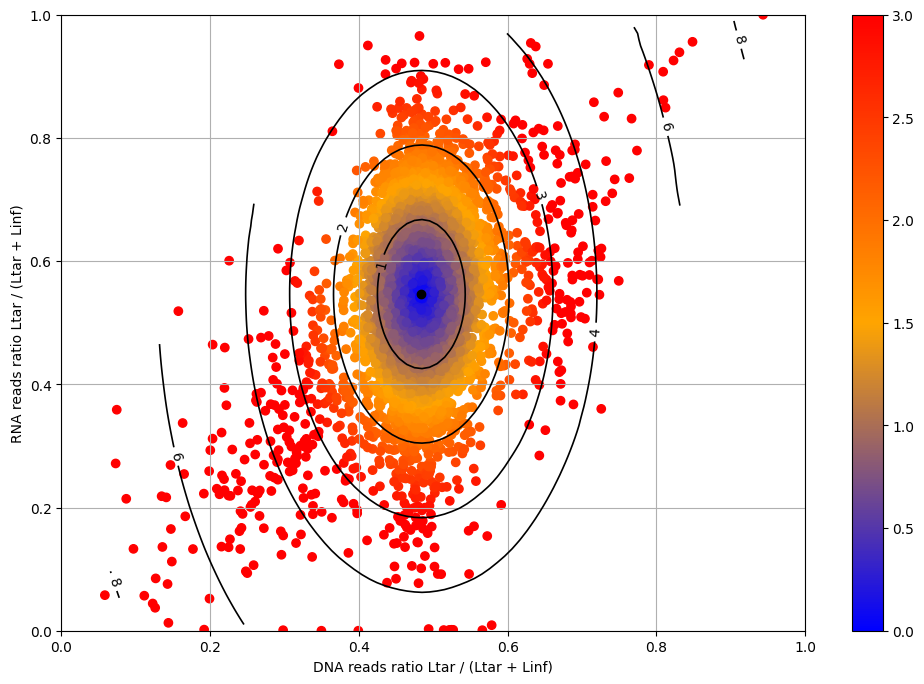

In [164]:
threshold = 2
plot_dna_rna_plot(newX, newY)
zone = ortho_groups.query("zscore_2d>@threshold")
#plot(zone.Xnormed, zone.Ynormed, "ok")
_=get_outliers_normed(zone, threshold)
savefig(f"figure_4D_zone_all_z2")

#genes = list(flatten([x.split(",") for x in go['Result gene list'].values]))
#plot_genes(set([x.strip() for x in genes if x.strip()]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ID                                               Name  Bgd count  \
0  GO:0055085                            transmembrane transport        192   
0  GO:0005215                               transporter activity        213   
1  GO:0005200             structural constituent of cytoskeleton         21   
2  GO:0022857                 transmembrane transporter activity        207   
3  GO:0005198                       structural molecule activity        223   
4  GO:0042626  ATPase-coupled transmembrane transporter activity         56   
5  GO:0004197               cysteine-type endopeptidase activity         42   
0  GO:0099513                       polymeric cytoskeletal fiber         27   
1  GO:0099081                             supramolecular polymer         27   
2  GO:0005874                                        microtubule         27   
3  GO:0099512                               supramolecular fiber         27   
4  GO:0016021                     integral component of membrane        252   
5  GO:0031224                    intrinsic component of membrane        254   

   Result count                                   Result gene list  \
0            50  LINF_020008000,LINF_110012200,LINF_110018150,L...   
0            50  LINF_020008000,LINF_100008900,LINF_110012200,L...   
1            12  LINF_130007700,LINF_130007800,LINF_130007900,L...   
2            48  LINF_020008000,LINF_100008900,LINF_110012200,L...   
3            47  LINF_010009200,LINF_010009300,LINF_100017100,L...   
4            18  LINF_020008000,LINF_110018150,LINF_110018200,L...   
5            15  LINF_080014800,LINF_080014900,LINF_080015100,L...   
0            13  LINF_130007700,LINF_130007800,LINF_130007900,L...   
1            13  LINF_130007700,LINF_130007800,LINF_130007900,L...   
2            13  LINF_130007700,LINF_130007800,LINF_130007900,L...   
3            13  LINF_130007700,LINF_130007800,LINF_130007900,L...   
4            49  LINF_020008000,LINF_030008500,LINF_030008650,L...   
5            49  LINF_020008000,LINF_030008500,LINF_030008650,L...   

   Pct of bgd  Fold enrichment  Odds ratio       P-value  Benjamini  \
0        26.0             2.26        2.88  9.313928e-09   0.000007   
0        23.5             2.04        2.50  3.393519e-07   0.000107   
1        57.1             4.97       10.47  5.262148e-07   0.000107   
2        23.2             2.02        2.45  8.687228e-07   0.000117   
3        21.1             1.83        2.15  1.830887e-05   0.001854   
4        32.1             2.80        3.73  2.969535e-05   0.002301   
5        35.7             3.11        4.37  3.409123e-05   0.002301   
0        48.1             4.19        7.29  2.326923e-06   0.000101   
1        48.1             4.19        7.29  2.326923e-06   0.000101   
2        48.1             4.19        7.29  2.326923e-06   0.000101   
3        48.1             4.19        7.29  2.326923e-06   0.000101   
4        19.4             1.69        1.94  1.099713e-04   0.003805   
5        19.3             1.68        1.92  1.349645e-04   0.003891   

   Bonferroni  
0    0.000007  
0    0.000137  
1    0.000213  
2    0.000352  
3    0.007415  
4    0.012027  
5    0.013807  
0    0.000403  
1    0.000403  
2    0.000403  
3    0.000403  
4    0.019025  
5    0.023349

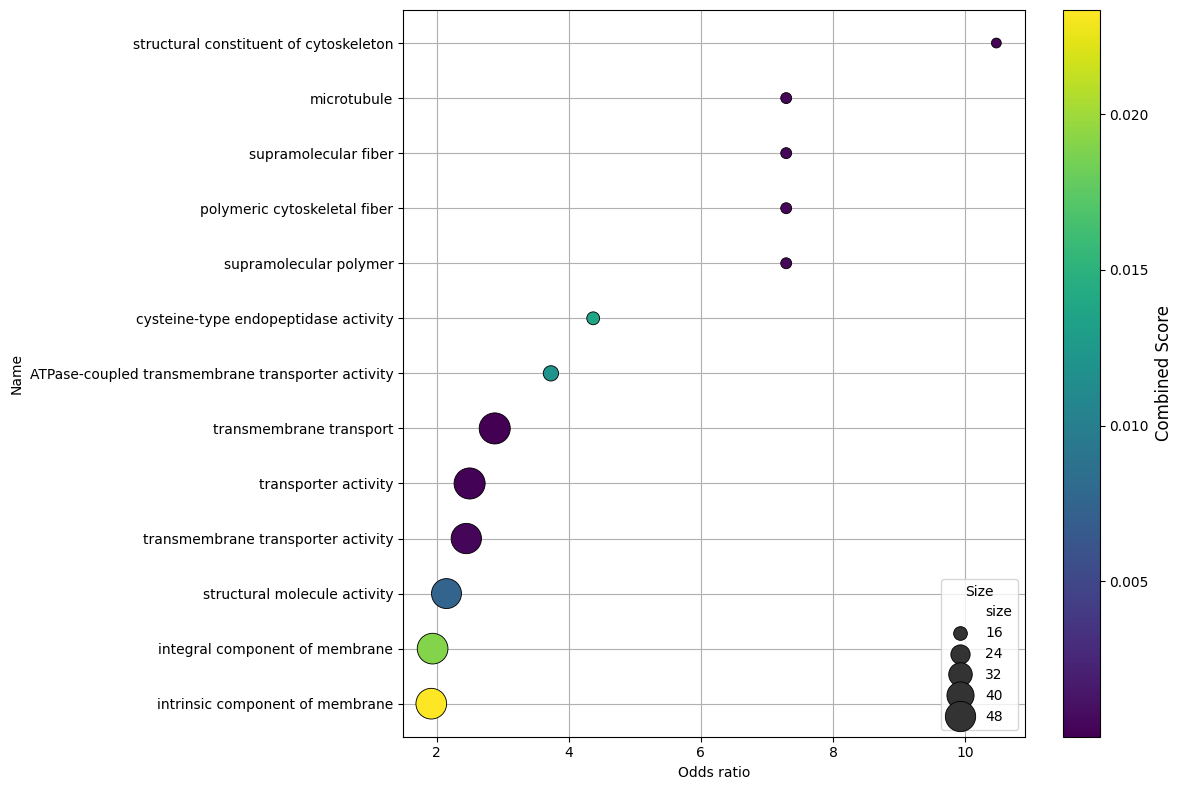

In [166]:
go = plot_go_terms("all_2")
go

all but z=3

Found 442 genes and  335 ortho groups
LINF_010005000,LINF_010010000,LINF_010010300,LINF_020006700,LINF_020006800,LINF_020006900,LINF_020007000,LINF_020007100,LINF_020008000,LINF_020008900,LINF_020010800,LINF_020012430,LINF_040006600,LINF_040006700,LINF_040006800,LINF_040007600,LINF_040008600,LINF_040009300,LINF_040014000,LINF_050013200,LINF_050015100,LINF_060006300,LINF_060008200,LINF_060008400,LINF_060012800,LINF_060019100,LINF_060019200,LINF_070006900,LINF_070007000,LINF_070007100,LINF_070012600,LINF_070013200,LINF_070013400,LINF_070013900,LINF_070016100,LINF_070016200,LINF_080011100,LINF_080011600,LINF_080013400,LINF_080014600,LINF_080014700,LINF_080014800,LINF_080014900,LINF_080015000,LINF_080015100,LINF_080015200,LINF_080015300,LINF_080015400,LINF_080015500,LINF_090005700,LINF_090006000,LINF_090006400,LINF_090008800,LINF_090011600,LINF_090011900,LINF_090012800,LINF_090014800,LINF_100007000,LINF_100008900,LINF_100015600,LINF_100016300,LINF_100017100,LINF_110007500,LINF_110007800,LI

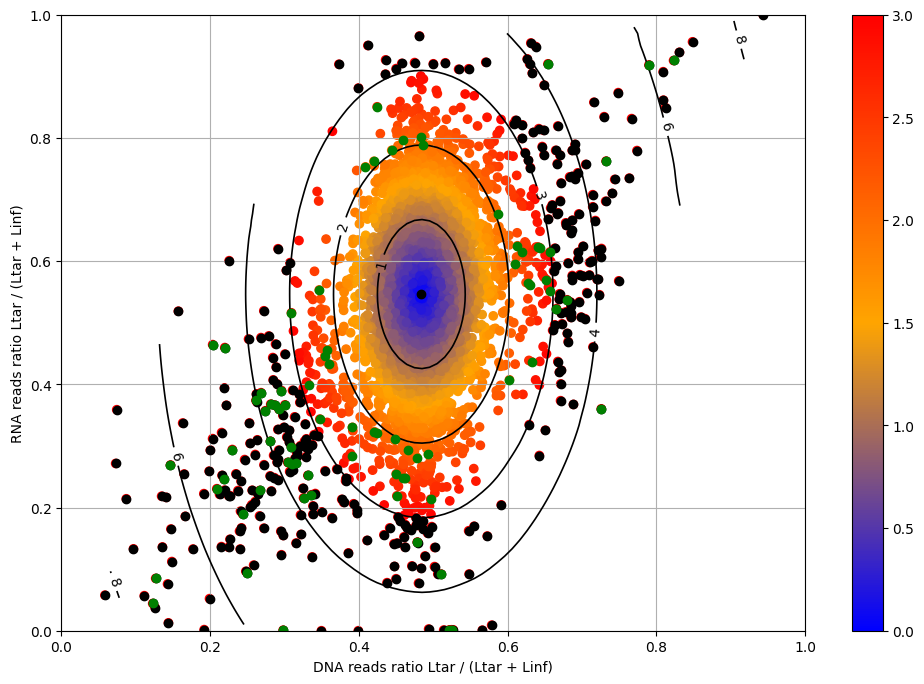

In [167]:
threshold = 3
plot_dna_rna_plot(newX, newY)
zone = ortho_groups.query("zscore_2d>@threshold")
plot(zone.Xnormed, zone.Ynormed, "ok")
_=get_outliers_normed(zone, threshold)
savefig("zone_all_z3")

#go = go.reset_index()
genes = list(flatten([x.split(",") for x in go['Result gene list'].values]))
plot_genes(set([x.strip() for x in genes if x.strip()]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ID                                               Name  Bgd count  \
0   GO:0055085                            transmembrane transport        192   
0   GO:0005200             structural constituent of cytoskeleton         21   
1   GO:0005215                               transporter activity        213   
2   GO:0022857                 transmembrane transporter activity        207   
3   GO:0005198                       structural molecule activity        223   
4   GO:0004197               cysteine-type endopeptidase activity         42   
5   GO:0008234                   cysteine-type peptidase activity         69   
6   GO:0015149          hexose transmembrane transporter activity          3   
7   GO:0051119           sugar transmembrane transporter activity          3   
8   GO:0015145  monosaccharide transmembrane transporter activity          3   
9   GO:0008097                                    5S rRNA binding          3   
10  GO:0005355         glucose transmembrane transporter activity          3   
11  GO:0005354       galactose transmembrane transporter activity          3   
12  GO:0005353        fructose transmembrane transporter activity          3   
13  GO:0015578         mannose transmembrane transporter activity          3   
0   GO:0005874                                        microtubule         27   
1   GO:0099081                             supramolecular polymer         27   
2   GO:0099512                               supramolecular fiber         27   
3   GO:0099513                       polymeric cytoskeletal fiber         27   
4   GO:0099080                             supramolecular complex         57   

    Result count                                   Result gene list  \
0             28  LINF_020008000,LINF_110018150,LINF_110018350,L...   
0             12  LINF_130007700,LINF_130007800,LINF_130007900,L...   
1             32  LINF_020008000,LINF_100008900,LINF_110018150,L...   
2             30  LINF_020008000,LINF_100008900,LINF_110018150,L...   
3             31  LINF_100017100,LINF_130007700,LINF_130007800,L...   
4             12  LINF_080014800,LINF_080014900,LINF_080015100,L...   
5             15  LINF_080014700,LINF_080014800,LINF_080014900,L...   
6              3      LINF_360072800,LINF_360073200,LINF_360073600,   
7              3      LINF_360072800,LINF_360073200,LINF_360073600,   
8              3      LINF_360072800,LINF_360073200,LINF_360073600,   
9              3      LINF_350023700,LINF_350023800,LINF_350023900,   
10             3      LINF_360072800,LINF_360073200,LINF_360073600,   
11             3      LINF_360072800,LINF_360073200,LINF_360073600,   
12             3      LINF_360072800,LINF_360073200,LINF_360073600,   
13             3      LINF_360072800,LINF_360073200,LINF_360073600,   
0             12  LINF_130007700,LINF_130007800,LINF_130007900,L...   
1             12  LINF_130007700,LINF_130007800,LINF_130007900,L...   
2             12  LINF_130007700,LINF_130007800,LINF_130007900,L...   
3             12  LINF_130007700,LINF_130007800,LINF_130007900,L...   
4             13  LINF_130007700,LINF_130007800,LINF_130007900,L...   

    Pct of bgd  Fold enrichment  Odds ratio       P-value     Benjamini  \
0         14.6             2.73        3.27  7.623748e-07  3.773755e-04   
0         57.1            10.71       24.75  7.957973e-11  2.180484e-08   
1         15.0             2.82        3.44  5.605979e-08  7.680192e-06   
2         14.5             2.72        3.27  3.414696e-07  3.118756e-05   
3         13.9             2.60        3.12  5.533571e-07  3.790496e-05   
4         28.6             5.35        7.39  1.089737e-06  5.971761e-05   
5         21.7             4.07        5.17  2.278077e-06  1.040322e-04   
6        100.0            18.74       25.75  1.503454e-04  2.942475e-03   
7        100.0            18.74       25.75  1.503454e-04  2.942475e-03   
8        100.0            18.74       25.75  1.503454e-04  2.942475e-03   
9        100.0

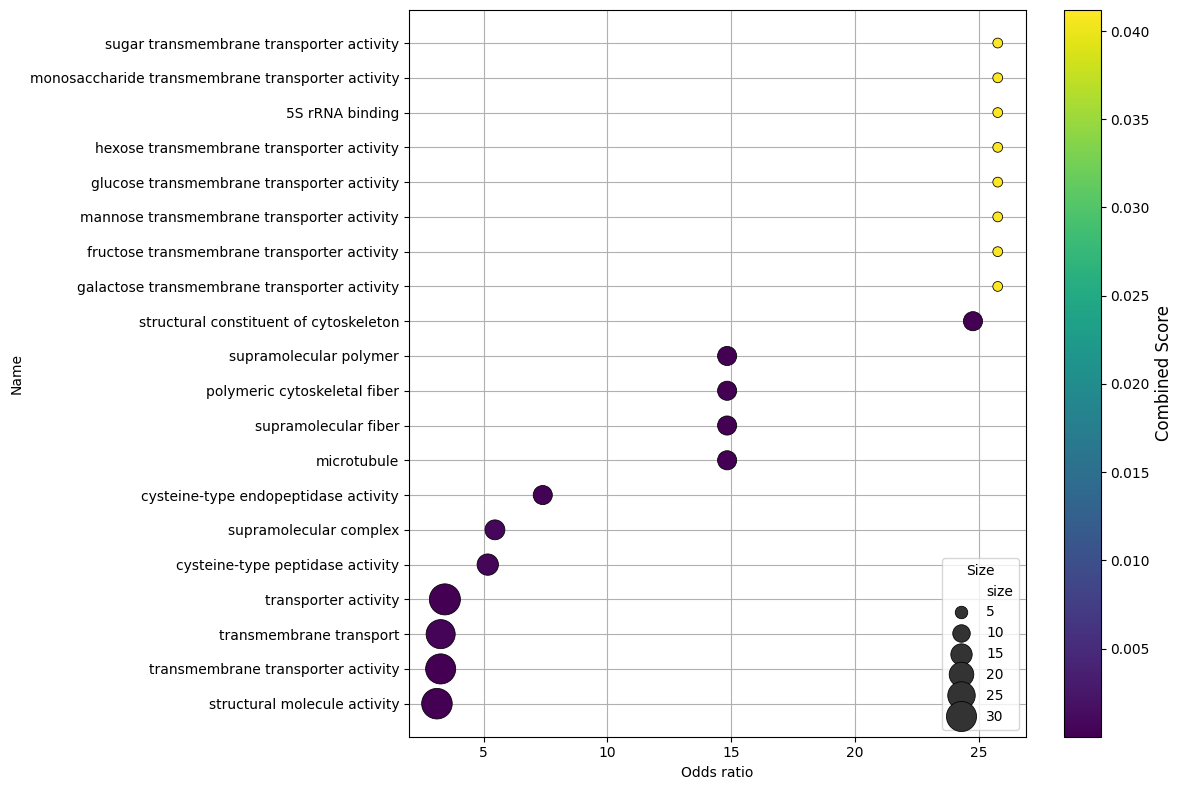

In [168]:
go = plot_go_terms("zone_all_3")
go

Found 198 genes and  129 ortho groups
LINF_020006700,LINF_020006800,LINF_020006900,LINF_020007000,LINF_020007100,LINF_020008000,LINF_020012430,LINF_040007600,LINF_040008600,LINF_040009300,LINF_040014000,LINF_060012800,LINF_070007000,LINF_070007100,LINF_070012600,LINF_070013400,LINF_070013900,LINF_080014600,LINF_080014700,LINF_080014800,LINF_080014900,LINF_080015000,LINF_080015100,LINF_080015200,LINF_080015300,LINF_080015400,LINF_080015500,LINF_090006400,LINF_090011900,LINF_100007000,LINF_100008900,LINF_100015600,LINF_100016300,LINF_110007800,LINF_110009400,LINF_110018150,LINF_110018350,LINF_110018700,LINF_130006900,LINF_130007700,LINF_130007800,LINF_130007900,LINF_130008000,LINF_130008100,LINF_130008200,LINF_130008300,LINF_130008400,LINF_130008500,LINF_130008600,LINF_130008700,LINF_130008800,LINF_140008900,LINF_140009000,LINF_140009100,LINF_140009200,LINF_140010100,LINF_140017150,LINF_160010000,LINF_160010800,LINF_160012500,LINF_160012800,LINF_160014700,LINF_160014800,LINF_160015600,LI

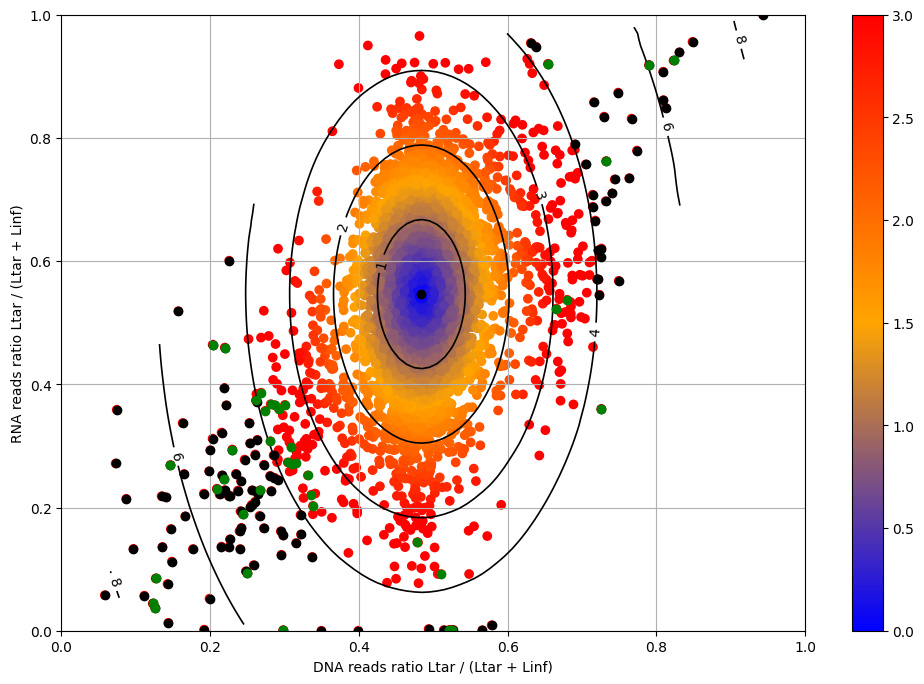

In [169]:
threshold = 4
plot_dna_rna_plot(newX, newY)
zone = ortho_groups.query("zscore_2d>@threshold")
plot(zone.Xnormed, zone.Ynormed, "ok")
_=get_outliers_normed(zone, threshold)
savefig("zone_all_z4.png")

#go = go.reset_index()
genes = list(flatten([x.split(",") for x in go['Result gene list'].values]))
plot_genes(set([x.strip() for x in genes if x.strip()]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ID                                               Name  Bgd count  \
0   GO:0055085                            transmembrane transport        192   
1   GO:0008150                                 biological process       2508   
2   GO:0007017                          microtubule-based process        163   
3   GO:1904659                    glucose transmembrane transport          3   
4   GO:0034219               carbohydrate transmembrane transport          3   
5   GO:0008645                     hexose transmembrane transport          3   
6   GO:0008284  positive regulation of cell population prolife...          3   
7   GO:0006952                                   defense response          3   
8   GO:0015749             monosaccharide transmembrane transport          3   
9   GO:0006508                                        proteolysis        165   
10  GO:0006810                                          transport        440   
11  GO:0051234                      establishment of localization        441   
12  GO:0042127        regulation of cell population proliferation          4   
13  GO:0008643                             carbohydrate transport          4   
14  GO:0009100                     glycoprotein metabolic process         32   
15  GO:0051179                                       localization        462   
0   GO:0005200             structural constituent of cytoskeleton         21   
1   GO:0005215                               transporter activity        213   
2   GO:0008234                   cysteine-type peptidase activity         69   
3   GO:0022857                 transmembrane transporter activity        207   
4   GO:0005198                       structural molecule activity        223   
5   GO:0004197               cysteine-type endopeptidase activity         42   
6   GO:0016787                                 hydrolase activity        633   
7   GO:0003924                                    GTPase activity         92   
8   GO:0017111                 nucleoside-triphosphatase activity        192   
9   GO:0008233                                 peptidase activity        154   
10  GO:0016462                           pyrophosphatase activity        200   
11  GO:0051119           sugar transmembrane transporter activity          3   
12  GO:0015578         mannose transmembrane transporter activity          3   
13  GO:0015149          hexose transmembrane transporter activity          3   
14  GO:0005355         glucose transmembrane transporter activity          3   
15  GO:0015145  monosaccharide transmembrane transporter activity          3   
16  GO:0005353        fructose transmembrane transporter activity          3   
17  GO:0005354       galactose transmembrane transporter activity          3   
18  GO:0016818  hydrolase activity, acting on acid anhydrides,...        206   
19  GO:0016817      hydrolase activity, acting on acid anhydrides        209   
20  GO:0032561                      guanyl ribonucleotide binding        130   
21  GO:0005525                                        GTP binding        130   
22  GO:0019001                          guanyl nucleotide binding        130   
23  GO:0015144    carbohydrate transmembrane transporter activity          4   
24  GO:0004175                             endopeptidase activity         94   
0   GO:0099513                       polymeric cytoskeletal fiber         27   
1   GO:0099081                             supramolecular polymer         27   
2   GO:0005874                                        microtubule         27   
3   GO:0099512                               supramolecular fiber         27   
4   GO:0099080                             supramolecular complex         57   
5   GO:0015630                           microtubule cytoskeleton        176   
6   GO:0051286                                           cell tip         36   
7   GO:0060187                                          cell pole         37   
8   GO:00160

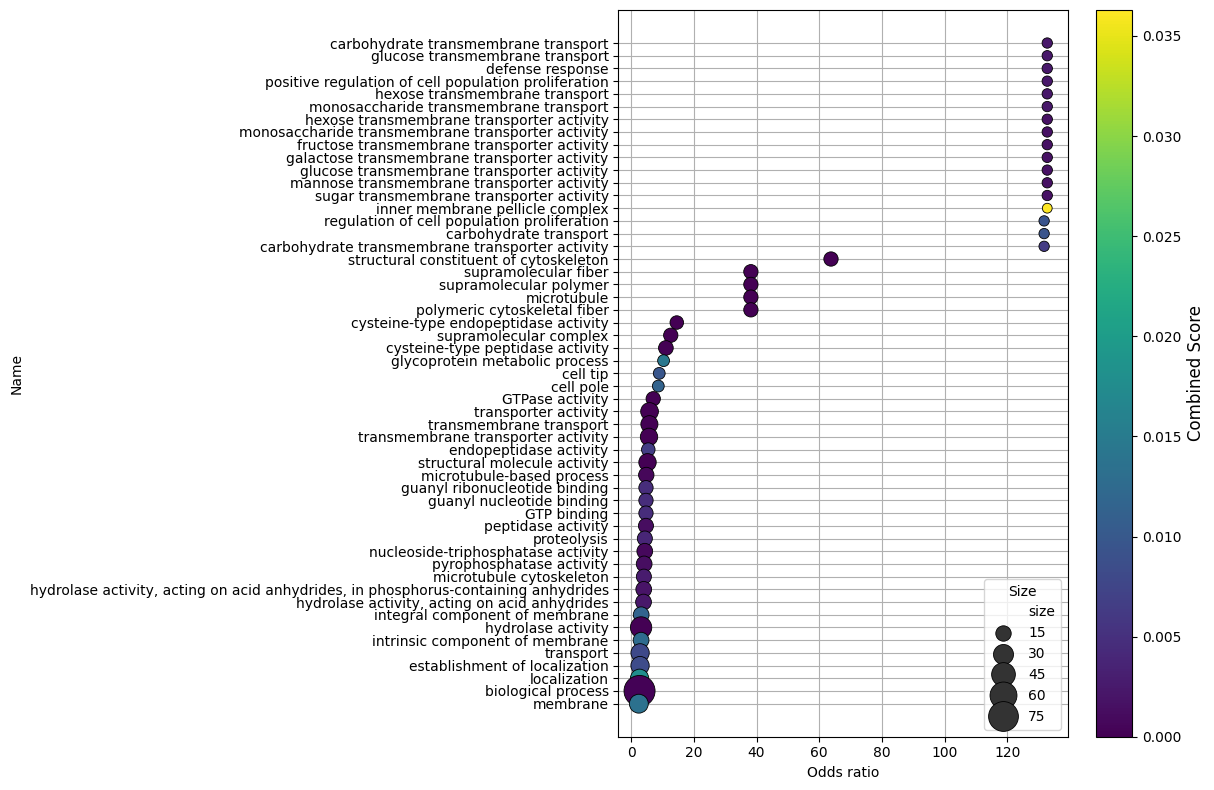

In [171]:
go = plot_go_terms("zone_all_4")
go

# all zscore 5

Found 80 genes and  59 ortho groups
LINF_020006700,LINF_020006800,LINF_020006900,LINF_020007000,LINF_020007100,LINF_040007600,LINF_040009300,LINF_060012800,LINF_070007000,LINF_070007100,LINF_070012600,LINF_070013900,LINF_090006400,LINF_100008900,LINF_100016300,LINF_110009400,LINF_110018150,LINF_110018350,LINF_110018700,LINF_130006900,LINF_140008900,LINF_140009000,LINF_140009100,LINF_140009200,LINF_140017150,LINF_160012800,LINF_160015600,LINF_160015700,LINF_160015800,LINF_160015850,LINF_160015900,LINF_180009900,LINF_190017200,LINF_200012300,LINF_200012400,LINF_200016200,LINF_210014200,LINF_210014300,LINF_220012300,LINF_220012500,LINF_220012700,LINF_220016700,LINF_220017000,LINF_230016500,LINF_230017200,LINF_240010600,LINF_250021300,LINF_260010300,LINF_270010000,LINF_280006400,LINF_280018100,LINF_290015000,LINF_300011800,LINF_300011900,LINF_300012000,LINF_300012300,LINF_300017500,LINF_300034800,LINF_310008500,LINF_310012300,LINF_310019200,LINF_310039500,LINF_310039600,LINF_320021000,LINF

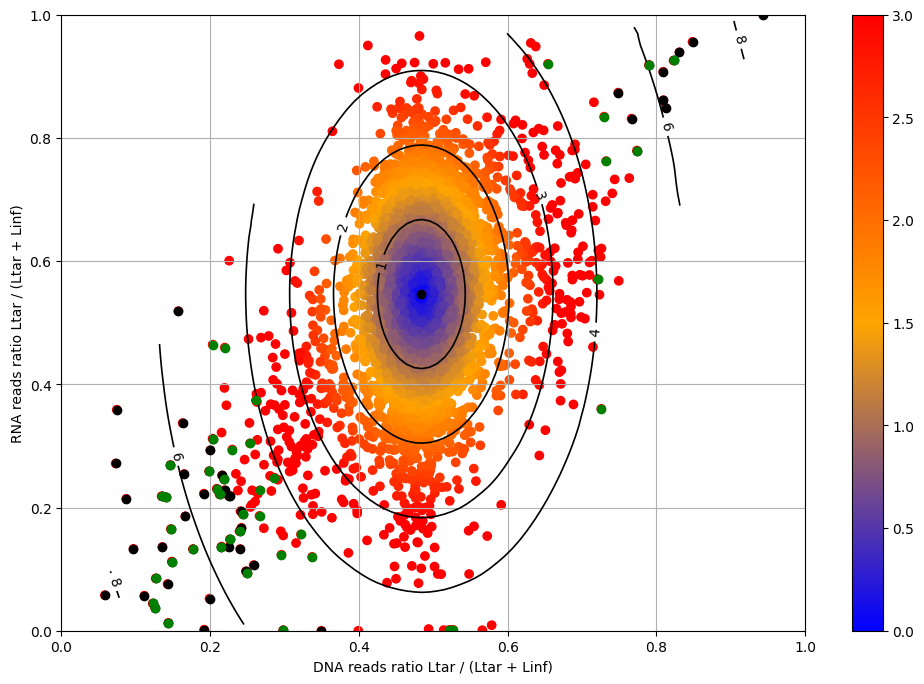

In [172]:
threshold = 5
plot_dna_rna_plot(newX, newY)
zone = ortho_groups.query("zscore_2d>@threshold")
plot(zone.Xnormed, zone.Ynormed, "ok")
_=get_outliers_normed(zone, threshold)
savefig("zone_all_z5.png")

#go = go.reset_index()
genes = list(flatten([x.split(",") for x in go['Result gene list'].values]))
plot_genes(set([x.strip() for x in genes if x.strip()]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ID                                               Name  Bgd count  \
0  GO:0006952                                   defense response          3   
1  GO:0008284  positive regulation of cell population prolife...          3   
2  GO:0042127        regulation of cell population proliferation          4   
3  GO:0006486                              protein glycosylation         31   
4  GO:0043413                        macromolecule glycosylation         31   
5  GO:0009101                  glycoprotein biosynthetic process         31   
6  GO:0070085                                      glycosylation         32   
7  GO:0009100                     glycoprotein metabolic process         32   
8  GO:0032053                    ciliary basal body organization          2   
9  GO:0008150                                 biological process       2508   
0  GO:0005215                               transporter activity        213   
1  GO:0022857                 transmembrane transporter activity        207   
0  GO:0016020                                           membrane        549   

   Result count                                   Result gene list  \
0             3      LINF_350027300,LINF_350027400,LINF_350027500,   
1             3      LINF_350027300,LINF_350027400,LINF_350027500,   
2             3      LINF_350027300,LINF_350027400,LINF_350027500,   
3             5  LINF_020006700,LINF_020006800,LINF_020006900,L...   
4             5  LINF_020006700,LINF_020006800,LINF_020006900,L...   
5             5  LINF_020006700,LINF_020006800,LINF_020006900,L...   
6             5  LINF_020006700,LINF_020006800,LINF_020006900,L...   
7             5  LINF_020006700,LINF_020006800,LINF_020006900,L...   
8             2                     LINF_350027400,LINF_350027500,   
9            34  LINF_020006700,LINF_020006800,LINF_020006900,L...   
0             9  LINF_100008900,LINF_110018150,LINF_110018350,L...   
1             8  LINF_100008900,LINF_110018150,LINF_110018350,L...   
0            13  LINF_020006700,LINF_020006800,LINF_020006900,L...   

   Pct of bgd  Fold enrichment  Odds ratio       P-value  Benjamini  \
0       100.0           115.55      371.00  6.030187e-07   0.000039   
1       100.0           115.55      371.00  6.030187e-07   0.000039   
2        75.0            86.66      370.00  2.397528e-06   0.000105   
3        16.1            18.64       24.87  5.469786e-06   0.000105   
4        16.1            18.64       24.87  5.469786e-06   0.000105   
5        16.1            18.64       24.87  5.469786e-06   0.000105   
6        15.6            18.05       23.94  6.441490e-06   0.000105   
7        15.6            18.05       23.94  6.441490e-06   0.000105   
8       100.0           115.55      371.00  7.313109e-05   0.001009   
9         1.4             1.57        4.01  7.704792e-05   0.001009   
0         4.2             4.88        6.16  6.423580e-05   0.006167   
1         3.9             4.47        5.45  3.225006e-04   0.015480   
0         2.4             2.74        3.58  4.909089e-04   0.020618   

   Bonferroni  
0    0.000079  
1    0.000079  
2    0.000314  
3    0.000717  
4    0.000717  
5    0.000717  
6    0.000844  
7    0.000844  
8    0.009580  
9    0.010093  
0    0.006167  
1    0.030960  
0    0.020618

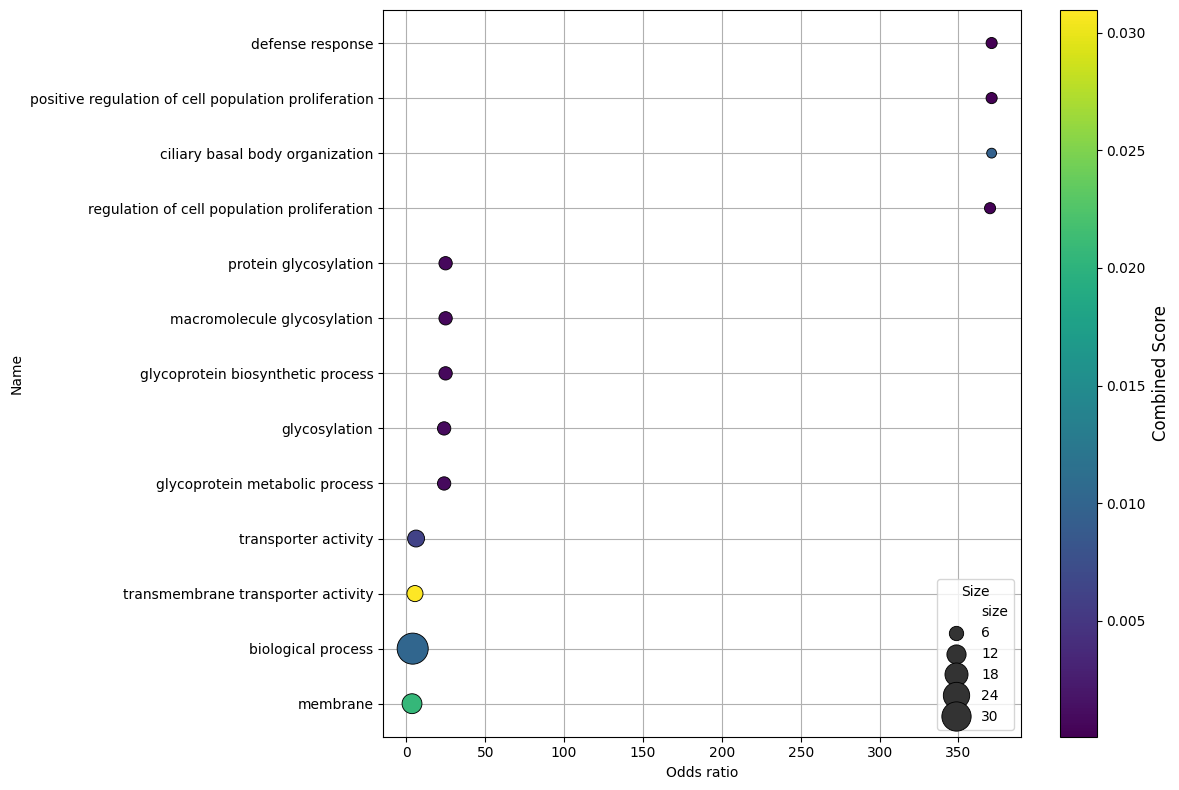

In [174]:
go = plot_go_terms("zone_all_5")
go

# add length of groups

In [175]:
lengths = []
for _, row in ortho_groups.iterrows():
    genes = row.infantum.split(",")
    dd = ginf.df.query("ID in @genes")
    S = (dd.stop-dd.start).sum()
    lengths.append(S)
ortho_groups['length_inf'] = lengths

In [176]:
lengths = []
for _, row in ortho_groups.iterrows():
    genes = row.tarentolae.split(",")
    dd = gtar.df.query("ID in @genes")
    S = (dd.stop-dd.start).sum()
    lengths.append(S)
ortho_groups['length_tar'] = lengths

Let us look at the ratio of tarentolae group versus infantum (log2)

0.4839203477867607 0.5465181018278599
Found 0 genes and  0 ortho groups



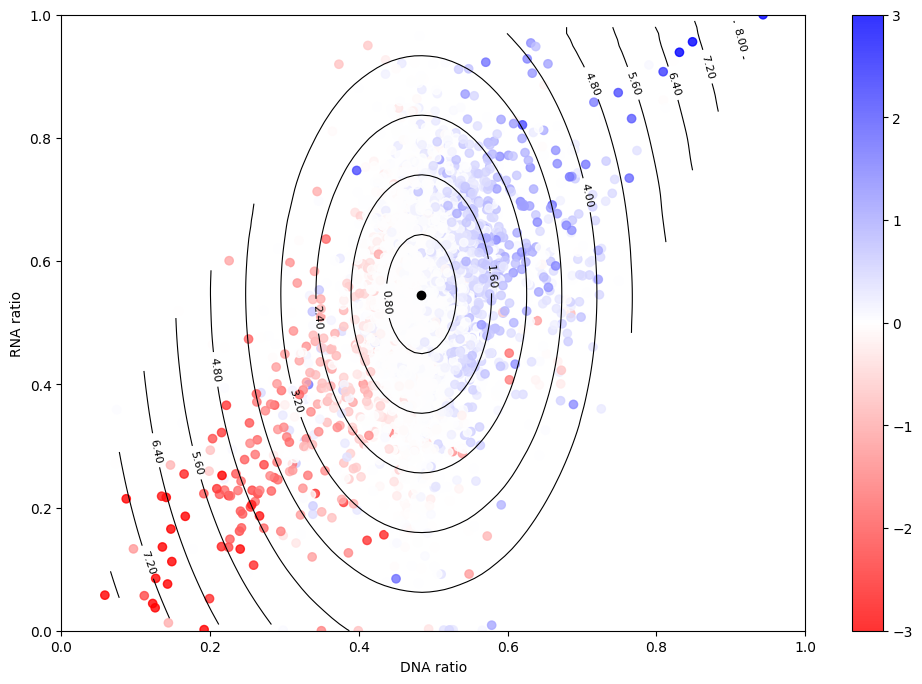

In [177]:
T = ortho_groups['length_tar']
I = ortho_groups['length_inf']
zscores = get_2D_zscore(newX, newY)
localcmap = Colormap().cmap_linear(color1="red", color2="white", color3="blue", reverse=False)

scatter(newX, newY, c=log2(T/I), cmap=localcmap, vmin=-3, vmax=3, alpha=0.8); colorbar()

xi = np.linspace(0, 1, 100)
yi = np.linspace(0,1, 100)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((newX, newY), zscores, (xi, yi), method='cubic')  # Interpolate Z values on the grid

# Contour plot
contour = plt.contour(xi, yi, zi, levels=10, colors='black', linewidths=0.8)
plt.clabel(contour, inline=True, fontsize=8, fmt="%.2f")
#plt.contourf(xi, yi, zi, levels=10, cmap='viridis', alpha=0.5)
plot([0.483],[0.545],'ko')
print(mean(newX), mean(newY))
xlabel("DNA ratio")
ylabel("RNA ratio")


zone = ortho_groups.query("Ltar_coverage_dna==0 and zscore_2d>2")
plot(zone.Xnormed, zone.Ynormed, "ok")
_=get_outliers_normed(zone)



what we see here are 2 groups of outliers. in red, log2 is negative so Tar length is much smaller than Infantum group length. 
This is also reflected in the DNA ratio that gives the coverage of tarentolae versus total (number of reads rather than coverage).
and indeed this is correlated. Let us now look closely at the dors on the left hand side.


In [661]:
When instrospecting the BAM file (genomic), there is no hole that would explain a coverage of zero from feature counts. Using pysam, we can also count the number of
reads and it is indeed, not zero in the region of interest. So why feature counts would report 0 reads ? It appears that for an instance 

orthogroups OG0000901, LINF_050013000 / gene-LtaPh_0508000, there is another tartentolae gene called LtaPh_0507951 that englobes the LtaPh_0508000 gene.
so looks like the latter capture all reads given no remaining reads for the one in the orthogroup . The LtaPh_0507951 is not in any of the orthogroups. 

Let us find all tarentolae genes in this situation. 

lloks like using -O in feature counts prevent this issue.


In [272]:
gtarinf = GFF3("../tarinf.gff")
pairs = []
for x in tqdm(gtarinf.df.seqid.unique()):
    dd = gtarinf.df.query("seqid==@x and genetic_type=='gene'")
    stop = dd['stop']
    start = dd['start']
    ids = dd['ID']
    df = pd.DataFrame({'id': ids, 'start': start, 'stop': stop})
    pairs = []
    for i, row_i in df.iterrows():
        for j, row_j in df.iterrows():
            if i != j:  # Skip comparing the gene with itself
                if row_j['start'] <= row_i['start'] and row_j['stop'] >= row_i['stop']:
                    pairs.append((row_i['id'], row_j['id']))
pairs_df = pd.DataFrame(pairs, columns=['included', 'includer'])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 215/215 [02:17<00:00,  1.57it/s]


# zone 2 and 4 together

not much except one hydrolase (MF) and soe carboxylic.

Found 424 genes and  393 ortho groups
LINF_010005000,LINF_010005300,LINF_010005600,LINF_010005700,LINF_010007500,LINF_010011200,LINF_020005600,LINF_020006000,LINF_020006200,LINF_020007600,LINF_020008000,LINF_020008100,LINF_020010300,LINF_030009300,LINF_040006200,LINF_040006300,LINF_040006600,LINF_040006700,LINF_040006800,LINF_040007400,LINF_040011100,LINF_050009600,LINF_050012800,LINF_050014200,LINF_050015100,LINF_060010000,LINF_060011200,LINF_060016300,LINF_060016600,LINF_060018500,LINF_060019100,LINF_070006300,LINF_070009800,LINF_070013900,LINF_070015200,LINF_070016100,LINF_070016200,LINF_070018400,LINF_080006600,LINF_080006700,LINF_080011100,LINF_080011300,LINF_080011600,LINF_080013100,LINF_080013800,LINF_090005700,LINF_090005900,LINF_090006000,LINF_090008800,LINF_090009500,LINF_090009600,LINF_090010100,LINF_090011700,LINF_090011800,LINF_090011900,LINF_090012000,LINF_090012800,LINF_090015000,LINF_090017000,LINF_090019000,LINF_100005800,LINF_100009900,LINF_100012200,LINF_100019000,LI

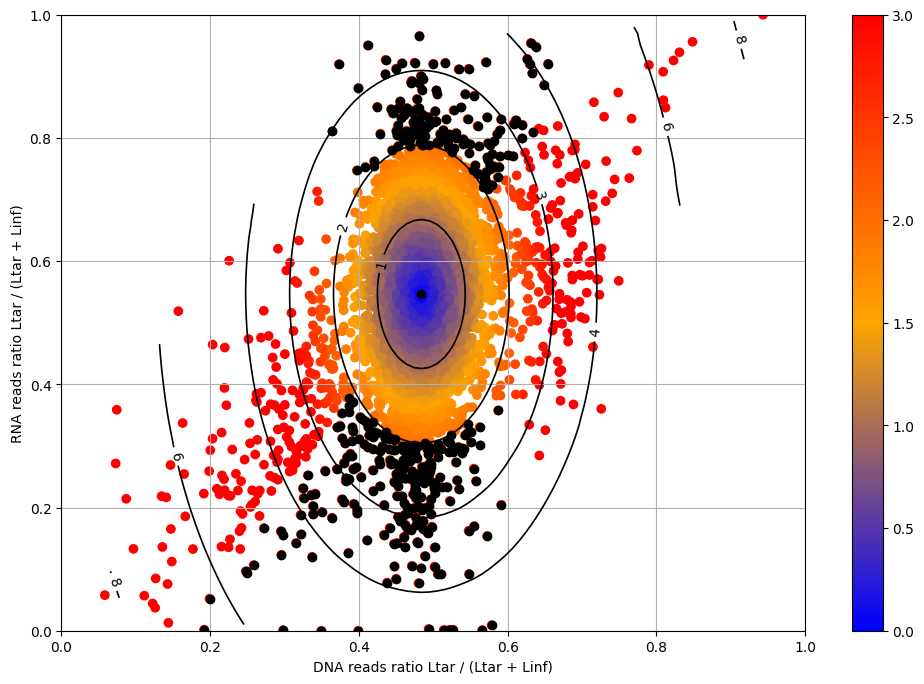

In [178]:
threshold = 2
plot_dna_rna_plot(newX, newY)
zone = ortho_groups.query("((angles>60 and angles<120) or (angles<-60 and angles>-120)) and zscore_2d>@threshold")
                        
plot(zone.Xnormed, zone.Ynormed, "ok")
_=get_outliers_normed(zone, threshold)
savefig("zone.png")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ID                                          Name  Bgd count  \
0  GO:0016310                               phosphorylation        231   
0  GO:0016790                 thiolester hydrolase activity          6   
1  GO:0008553  P-type proton-exporting transporter activity          3   

   Result count                                   Result gene list  \
0            26  LINF_020006200,LINF_070015200,LINF_080013800,L...   
0             4  LINF_290023600,LINF_320043700,LINF_320043800,L...   
1             3      LINF_180020600,LINF_180020700,LINF_180020800,   

   Pct of bgd  Fold enrichment  Odds ratio   P-value  Benjamini  Bonferroni  
0        11.3             2.32        2.68  0.000039   0.019480    0.020266  
0        66.7            13.77       39.97  0.000074   0.013292    0.017650  
1       100.0            20.65       40.97  0.000112   0.013292    0.026584

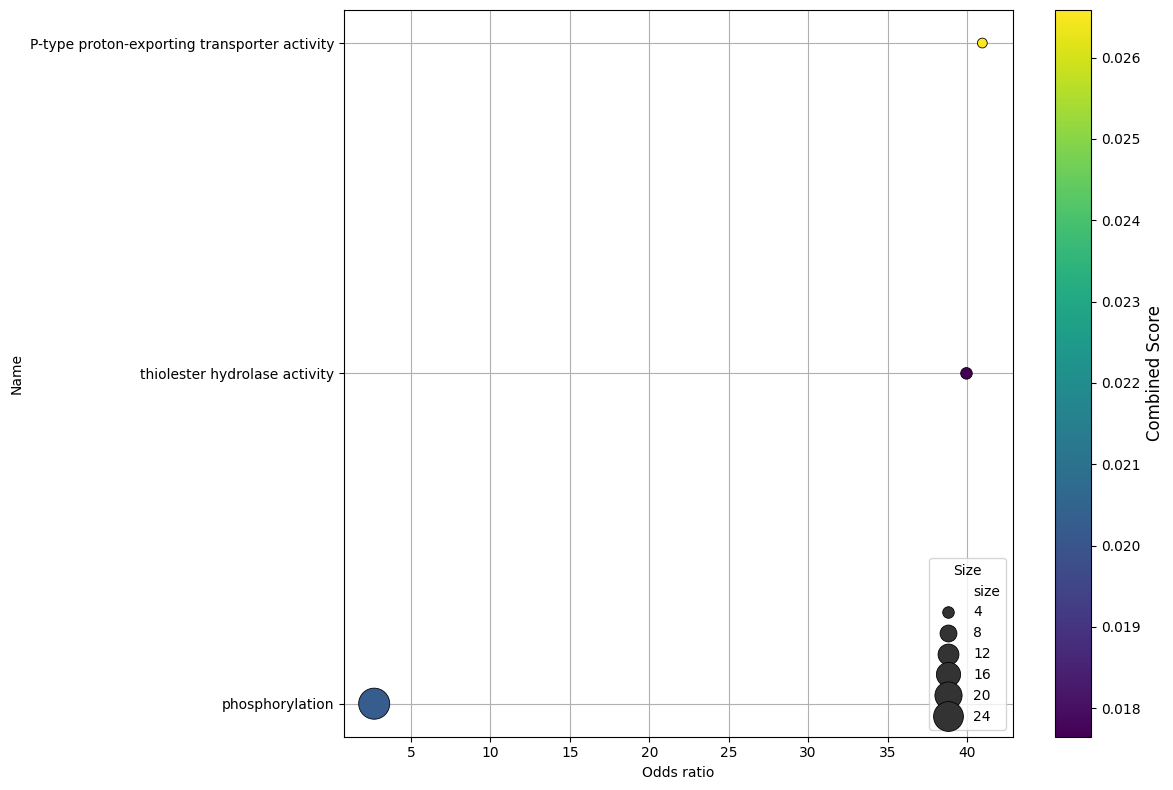

In [181]:
go = plot_go_terms("zone_top_down_2")
go

In [182]:
zscores = get_2D_zscore(newX, newY)

In [183]:
p_2d = 1 - np.exp(-zscores**2 / 2)


# we could adjust the zscore -> pvalue - bonferonni and keeponly those that are below 0.05. e have 62 candidates. a bit restrictive though

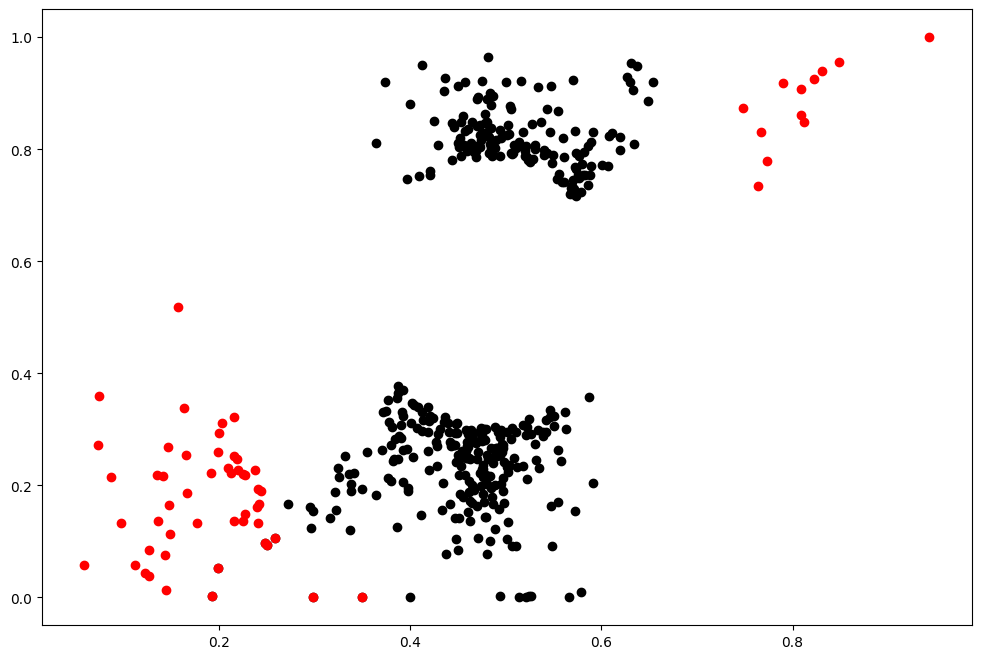

In [184]:
from statsmodels.sandbox.stats.multicomp import multipletests

dd = pd.DataFrame({"z":zscores, "pv":1-p_2d, 'newX':newX, 'newY': newY})
p_adjusted = multipletests(dd['pv'], method='bonferroni')

dd['bonferroni'] = p_adjusted[1]
dd = dd.query("bonferroni<0.05")
plot(zone.Xnormed, zone.Ynormed, "ok")

plot(dd['newX'], dd['newY'], 'or')

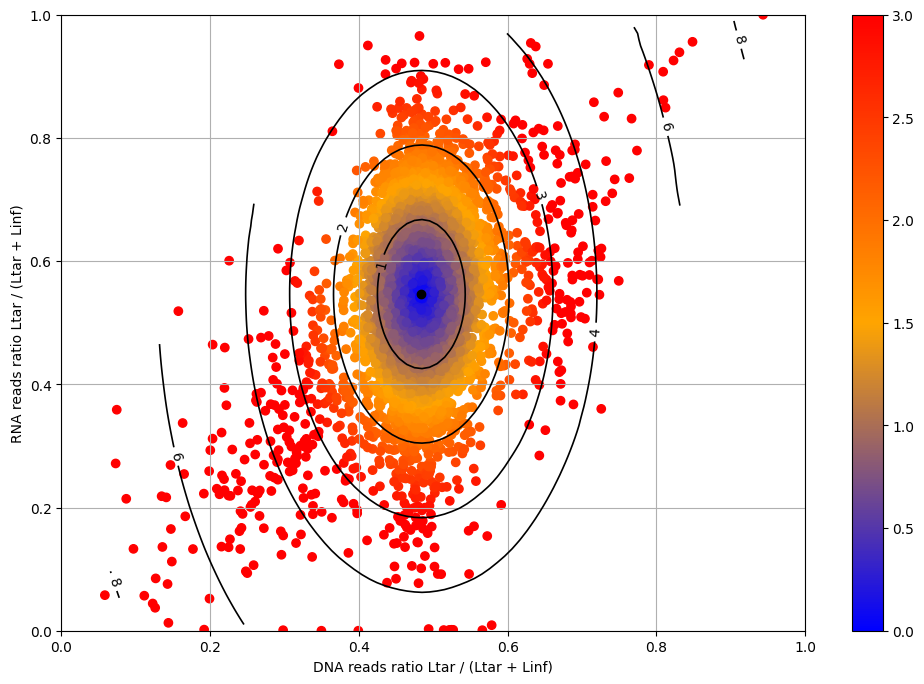

In [185]:

threshold = 2
plot_dna_rna_plot(newX, newY)
savefig("figure_4D_dna_rna_plot")

In [186]:
genes = "LINF_010005000,LINF_010005300,LINF_010005600,LINF_010005700,LINF_010007500,LINF_010009200,LINF_010009300,LINF_010010000,LINF_010010300,LINF_010011200,LINF_010012000,LINF_020005600,LINF_020005800,LINF_020006000,LINF_020006200,LINF_020006700,LINF_020006800,LINF_020006900,LINF_020007000,LINF_020007100,LINF_020007600,LINF_020007700,LINF_020008000,LINF_020008100,LINF_020008900,LINF_020010300,LINF_020010800,LINF_020012430,LINF_030008500,LINF_030008650,LINF_030008700,LINF_030009300,LINF_030012400,LINF_030014900,LINF_040006200,LINF_040006300,LINF_040006400,LINF_040006600,LINF_040006700,LINF_040006800,LINF_040007400,LINF_040007600,LINF_040008500,LINF_040008600,LINF_040009300,LINF_040010000,LINF_040011100,LINF_040014000,LINF_040017100,LINF_050009600,LINF_050012800,LINF_050013200,LINF_050014200,LINF_050015100,LINF_050017100,LINF_060006300,LINF_060008200,LINF_060008400,LINF_060010000,LINF_060011200,LINF_060012800,LINF_060016300,LINF_060016600,LINF_060018500,LINF_060019100,LINF_060019200,LINF_070006300,LINF_070006900,LINF_070007000,LINF_070007100,LINF_070009100,LINF_070009800,LINF_070012600,LINF_070013200,LINF_070013400,LINF_070013700,LINF_070013900,LINF_070014400,LINF_070015200,LINF_070015700,LINF_070016100,LINF_070016200,LINF_070018400,LINF_080006600,LINF_080006700,LINF_080007600,LINF_080009700,LINF_080010000,LINF_080011100,LINF_080011300,LINF_080011600,LINF_080013100,LINF_080013400,LINF_080013800,LINF_080014600,LINF_080014700,LINF_080014800,LINF_080014900,LINF_080015000,LINF_080015100,LINF_080015200,LINF_080015300,LINF_080015400,LINF_080015500,LINF_080017100,LINF_080017300,LINF_090005600,LINF_090005700,LINF_090005900,LINF_090006000,LINF_090006400,LINF_090006500,LINF_090008800,LINF_090009500,LINF_090009600,LINF_090009900,LINF_090010000,LINF_090010100,LINF_090011500,LINF_090011600,LINF_090011700,LINF_090011800,LINF_090011900,LINF_090012000,LINF_090012800,LINF_090014800,LINF_090015000,LINF_090017000,LINF_090019000,LINF_090019700,LINF_090019800,LINF_090020500,LINF_100005800,LINF_100007000,LINF_100007900,LINF_100008900,LINF_100009900,LINF_100012200,LINF_100013200,LINF_100013400,LINF_100015600,LINF_100016300,LINF_100017100,LINF_100018500,LINF_100019000,LINF_100019300,LINF_100021200,LINF_110007500,LINF_110007800,LINF_110008700,LINF_110009400,LINF_110009500,LINF_110010800,LINF_110011900,LINF_110012000,LINF_110012200,LINF_110012300,LINF_110012400,LINF_110012500,LINF_110012700,LINF_110012900,LINF_110016000,LINF_110018150,LINF_110018200,LINF_110018300,LINF_110018350,LINF_110018400,LINF_110018700,LINF_120008400,LINF_120009900,LINF_120010200,LINF_120010700,LINF_120011100,LINF_120015500,LINF_120016900,LINF_130006900,LINF_130007700,LINF_130007800,LINF_130007900,LINF_130008000,LINF_130008100,LINF_130008200,LINF_130008300,LINF_130008400,LINF_130008500,LINF_130008600,LINF_130008700,LINF_130008800,LINF_130012000,LINF_130017000,LINF_130017100,LINF_130017200,LINF_130017300,LINF_130018300,LINF_130019000,LINF_130020500,LINF_130021100,LINF_130021200,LINF_140005600,LINF_140008900,LINF_140009000,LINF_140009100,LINF_140009200,LINF_140009900,LINF_140010000,LINF_140010100,LINF_140010200,LINF_140010300,LINF_140012800,LINF_140012900,LINF_140013000,LINF_140015200,LINF_140015800,LINF_140017150,LINF_140017400,LINF_140017500,LINF_150008100,LINF_150008200,LINF_150008400,LINF_150008600,LINF_150009100,LINF_150009200,LINF_150009600,LINF_150012100,LINF_150012400,LINF_150015400,LINF_150015500,LINF_150016000,LINF_150016300,LINF_150017200,LINF_150017800,LINF_150019500,LINF_150019600,LINF_150021700,LINF_150022750,LINF_160006300,LINF_160006800,LINF_160008000,LINF_160008800,LINF_160009400,LINF_160010000,LINF_160010800,LINF_160011100,LINF_160012200,LINF_160012500,LINF_160012800,LINF_160014600,LINF_160014700,LINF_160014800,LINF_160015600,LINF_160015700,LINF_160015800,LINF_160015850,LINF_160015900,LINF_160016000,LINF_160016500,LINF_160016600,LINF_160016700,LINF_160016900,LINF_160017200,LINF_170007300,LINF_170009900,LINF_170010400,LINF_170011100,LINF_170011200,LINF_170015700,LINF_170016000,LINF_170016400,LINF_170018300,LINF_170020300,LINF_170020800,LINF_180006700,LINF_180006800,LINF_180007900,LINF_180008500,LINF_180009900,LINF_180010300,LINF_180010800,LINF_180011700,LINF_180012400,LINF_180012600,LINF_180015900,LINF_180017000,LINF_180017600,LINF_180017700,LINF_180018700,LINF_180018900,LINF_180019600,LINF_180019900,LINF_180020400,LINF_180020600,LINF_180020700,LINF_180020800,LINF_180021000,LINF_190005100,LINF_190007500,LINF_190008900,LINF_190009100,LINF_190010200,LINF_190010800,LINF_190016400,LINF_190017200,LINF_190017400,LINF_190017700,LINF_190017800,LINF_190018400,LINF_190018500,LINF_190019700,LINF_190019800,LINF_190019900,LINF_190021000,LINF_190021400,LINF_190021600,LINF_200008100,LINF_200008800,LINF_200010300,LINF_200011200,LINF_200012300,LINF_200012400,LINF_200016200,LINF_200017200,LINF_200018500,LINF_200018600,LINF_200022000,LINF_200022100,LINF_200022200,LINF_210005500,LINF_210005600,LINF_210006000,LINF_210006400,LINF_210008900,LINF_210014200,LINF_210014300,LINF_210014400,LINF_210014900,LINF_210015900,LINF_210016000,LINF_210018200,LINF_210018300,LINF_210019600,LINF_210023000,LINF_210025300,LINF_210025700,LINF_210027500,LINF_220005000,LINF_220005100,LINF_220005200,LINF_220005500,LINF_220006800,LINF_220007200,LINF_220007700,LINF_220008300,LINF_220008400,LINF_220009800,LINF_220010100,LINF_220010300,LINF_220010400,LINF_220011800,LINF_220012300,LINF_220012500,LINF_220012700,LINF_220012900,LINF_220013300,LINF_220013400,LINF_220014500,LINF_220016600,LINF_220016700,LINF_220017000,LINF_220017900,LINF_220018000,LINF_220018200,LINF_220019100,LINF_220019500,LINF_220020000,LINF_220021500,LINF_220021600,LINF_220021700,LINF_220021900,LINF_220022800,LINF_230007100,LINF_230007500,LINF_230007900,LINF_230008300,LINF_230008700,LINF_230009600,LINF_230012700,LINF_230012900,LINF_230013600,LINF_230013700,LINF_230014200,LINF_230014600,LINF_230014700,LINF_230016500,LINF_230017200,LINF_230018100,LINF_230018600,LINF_230018700,LINF_230018900,LINF_230019100,LINF_230019200,LINF_230019300,LINF_230019700,LINF_230019800,LINF_230019900,LINF_230020100,LINF_230020200,LINF_230020300,LINF_230020900,LINF_230021200,LINF_230023000,LINF_240006300,LINF_240007400,LINF_240007800,LINF_240009100,LINF_240009400,LINF_240010600,LINF_240011900,LINF_240013900,LINF_240014100,LINF_240017700,LINF_240017800,LINF_240017900,LINF_240018000,LINF_240018100,LINF_240018500,LINF_240019200,LINF_240019300,LINF_240019500,LINF_240020050,LINF_240021200,LINF_240021300,LINF_240023600,LINF_240023800,LINF_240026900,LINF_240027000,LINF_240027100,LINF_240027300,LINF_240027800,LINF_240028200,LINF_250005000,LINF_250008600,LINF_250011900,LINF_250012200,LINF_250013300,LINF_250014900,LINF_250016700,LINF_250017200,LINF_250018300,LINF_250019700,LINF_250020400,LINF_250021300,LINF_250021800,LINF_250023000,LINF_250023100,LINF_250024700,LINF_250026500,LINF_250027000,LINF_250028600,LINF_250031200,LINF_250031400,LINF_260005200,LINF_260005800,LINF_260005900,LINF_260006000,LINF_260006100,LINF_260006150,LINF_260006200,LINF_260006600,LINF_260006700,LINF_260007400,LINF_260008000,LINF_260010300,LINF_260011200,LINF_260011300,LINF_260011400,LINF_260011600,LINF_260013000,LINF_260013100,LINF_260013400,LINF_260014900,LINF_260016000,LINF_260020000,LINF_260020900,LINF_260021100,LINF_260021300,LINF_260021400,LINF_260021500,LINF_260023800,LINF_260025100,LINF_260027000,LINF_260028800,LINF_260028900,LINF_260029800,LINF_260032800,LINF_270005000,LINF_270005700,LINF_270006200,LINF_270007100,LINF_270007200,LINF_270007300,LINF_270007400,LINF_270008900,LINF_270010000,LINF_270010100,LINF_270010200,LINF_270011100,LINF_270011200,LINF_270012500,LINF_270012600,LINF_270013100,LINF_270017300,LINF_270017500,LINF_270018100,LINF_270018700,LINF_270020800,LINF_270020900,LINF_270021000,LINF_270021100,LINF_270021200,LINF_270021300,LINF_270022600,LINF_270022800,LINF_270023200,LINF_270023800,LINF_270023900,LINF_270024000,LINF_270026200,LINF_270027200,LINF_270027400,LINF_270030500,LINF_270030800,LINF_280005300,LINF_280005700,LINF_280006400,LINF_280006700,LINF_280007900,LINF_280008700,LINF_280009200,LINF_280011100,LINF_280012700,LINF_280013100,LINF_280016100,LINF_280017800,LINF_280018100,LINF_280019600,LINF_280019900,LINF_280020100,LINF_280020200,LINF_280025700,LINF_280025800,LINF_280028500,LINF_280031600,LINF_280034400,LINF_280034700,LINF_280034800,LINF_280035000,LINF_280035100,LINF_280035200,LINF_280035300,LINF_280035400,LINF_280035500,LINF_280035600,LINF_280035700,LINF_280035800,LINF_280035900,LINF_280036000,LINF_280037600,LINF_280039600,LINF_290005700,LINF_290007800,LINF_290008300,LINF_290010300,LINF_290011200,LINF_290011600,LINF_290012600,LINF_290013800,LINF_290013900,LINF_290014000,LINF_290014100,LINF_290014200,LINF_290014300,LINF_290014500,LINF_290014600,LINF_290014800,LINF_290014900,LINF_290015000,LINF_290015400,LINF_290016100,LINF_290016900,LINF_290017100,LINF_290019300,LINF_290019800,LINF_290020000,LINF_290020300,LINF_290020900,LINF_290021300,LINF_290021500,LINF_290021600,LINF_290021700,LINF_290021800,LINF_290023400,LINF_290023500,LINF_290023600,LINF_290028900,LINF_290029000,LINF_290030400,LINF_290030500,LINF_290031500,LINF_290032100,LINF_290032800,LINF_290035300,LINF_300007900,LINF_300009600,LINF_300011800,LINF_300011900,LINF_300012000,LINF_300012300,LINF_300012600,LINF_300014500,LINF_300016000,LINF_300017500,LINF_300019600,LINF_300020000,LINF_300020100,LINF_300020200,LINF_300021500,LINF_300022100,LINF_300023800,LINF_300024200,LINF_300025600,LINF_300026200,LINF_300026600,LINF_300027300,LINF_300027400,LINF_300029600,LINF_300034800,LINF_300035000,LINF_300035100,LINF_300035200,LINF_300035300,LINF_300035600,LINF_300036800,LINF_300039400,LINF_300040500,LINF_300041300,LINF_300042100,LINF_310005700,LINF_310006200,LINF_310008500,LINF_310008800,LINF_310009900,LINF_310010000,LINF_310010300,LINF_310011500,LINF_310012300,LINF_310012800,LINF_310012900,LINF_310013000,LINF_310013450,LINF_310014200,LINF_310014700,LINF_310015800,LINF_310016000,LINF_310016400,LINF_310016700,LINF_310017500,LINF_310017600,LINF_310017700,LINF_310018500,LINF_310018600,LINF_310019200,LINF_310019500,LINF_310019600,LINF_310019800,LINF_310019900,LINF_310020000,LINF_310020100,LINF_310020200,LINF_310020600,LINF_310023300,LINF_310023600,LINF_310023700,LINF_310023800,LINF_310024700,LINF_310026500,LINF_310026600,LINF_310027000,LINF_310027100,LINF_310027200,LINF_310028900,LINF_310029100,LINF_310029200,LINF_310029800,LINF_310030600,LINF_310031200,LINF_310031300,LINF_310032200,LINF_310032400,LINF_310032600,LINF_310032800,LINF_310033500,LINF_310033550,LINF_310038000,LINF_310039500,LINF_310039600,LINF_310040500,LINF_310040800,LINF_320007900,LINF_320013900,LINF_320014000,LINF_320017400,LINF_320018200,LINF_320018600,LINF_320020100,LINF_320021000,LINF_320021100,LINF_320021200,LINF_320021300,LINF_320021800,LINF_320022100,LINF_320023200,LINF_320023600,LINF_320025400,LINF_320025600,LINF_320026600,LINF_320028500,LINF_320028600,LINF_320028800,LINF_320030500,LINF_320030800,LINF_320034900,LINF_320035000,LINF_320039200,LINF_320040900,LINF_320041600,LINF_320041700,LINF_320042500,LINF_320043700,LINF_320043800,LINF_320043900,LINF_320046300,LINF_330005100,LINF_330005500,LINF_330008300,LINF_330010500,LINF_330011400,LINF_330011700,LINF_330012600,LINF_330013000,LINF_330013200,LINF_330013300,LINF_330013700,LINF_330014300,LINF_330014400,LINF_330014500,LINF_330016500,LINF_330017600,LINF_330018200,LINF_330018900,LINF_330019000,LINF_330019100,LINF_330019700,LINF_330019900,LINF_330020000,LINF_330022900,LINF_330024200,LINF_330025300,LINF_330027100,LINF_330027300,LINF_330028400,LINF_330028600,LINF_330029100,LINF_330030200,LINF_330031300,LINF_330031700,LINF_330032500,LINF_330032600,LINF_330037600,LINF_330038600,LINF_330038900,LINF_330039500,LINF_330039600,LINF_330039800,LINF_330041500,LINF_330042900,LINF_340005200,LINF_340007300,LINF_340011100,LINF_340011700,LINF_340012500,LINF_340013100,LINF_340013400,LINF_340016200,LINF_340016400,LINF_340018000,LINF_340019000,LINF_340019500,LINF_340021000,LINF_340021100,LINF_340021200,LINF_340021300,LINF_340022400,LINF_340022500,LINF_340025100,LINF_340025400,LINF_340025700,LINF_340026700,LINF_340027000,LINF_340028600,LINF_340029000,LINF_340031200,LINF_340032300,LINF_340033700,LINF_340033900,LINF_340035100,LINF_340035800,LINF_340037700,LINF_340037800,LINF_340039100,LINF_340040300,LINF_340043900,LINF_340045700,LINF_340047000,LINF_340047250,LINF_350008000,LINF_350008100,LINF_350009700,LINF_350012400,LINF_350013300,LINF_350014000,LINF_350014400,LINF_350014500,LINF_350014900,LINF_350015100,LINF_350016600,LINF_350016700,LINF_350018900,LINF_350020300,LINF_350020600,LINF_350020800,LINF_350021300,LINF_350023600,LINF_350023700,LINF_350023800,LINF_350023900,LINF_350024100,LINF_350024200,LINF_350024300,LINF_350024400,LINF_350024500,LINF_350025400,LINF_350026200,LINF_350026500,LINF_350026800,LINF_350027200,LINF_350027300,LINF_350027400,LINF_350027500,LINF_350028500,LINF_350029400,LINF_350030400,LINF_350030800,LINF_350032000,LINF_350032700,LINF_350033200,LINF_350040600,LINF_350041000,LINF_350041200,LINF_350042100,LINF_350042700,LINF_350045100,LINF_350045600,LINF_350047700,LINF_350049700,LINF_350049800,LINF_350050000,LINF_350050100,LINF_350050300,LINF_350050600,LINF_350053200,LINF_350054000,LINF_350055000,LINF_350055100,LINF_350055500,LINF_350055600,LINF_350055900,LINF_350056200,LINF_350057500,LINF_350057600,LINF_350057900,LINF_350058000,LINF_350059400,LINF_360009000,LINF_360010100,LINF_360010400,LINF_360011300,LINF_360012300,LINF_360012800,LINF_360013000,LINF_360015100,LINF_360015200,LINF_360015400,LINF_360017600,LINF_360018400,LINF_360021400,LINF_360021500,LINF_360022400,LINF_360022500,LINF_360027100,LINF_360027200,LINF_360030000,LINF_360030300,LINF_360030600,LINF_360031000,LINF_360031200,LINF_360031300,LINF_360033900,LINF_360036500,LINF_360037500,LINF_360037700,LINF_360038900,LINF_360039000,LINF_360041100,LINF_360042000,LINF_360043000,LINF_360043200,LINF_360046700,LINF_360046900,LINF_360047000,LINF_360047200,LINF_360048400,LINF_360050500,LINF_360054700,LINF_360054800,LINF_360057900,LINF_360058600,LINF_360063600,LINF_360064700,LINF_360064900,LINF_360065900,LINF_360067500,LINF_360068200,LINF_360070200,LINF_360071300,LINF_360072800,LINF_360072900,LINF_360073000,LINF_360073100,LINF_360073200,LINF_360073300,LINF_360073400,LINF_360073500,LINF_360073600,LINF_360077100,LINF_360077500,LINF_360080400".split(",")

In [187]:
len(genes)

956

In [189]:
# from rnaseq_infantum
fc = FeatureCount("data/RNA/tarinf/all_features.out")
# this version uses the -O -M options . this version has no infantum but we only use the hybrid columns anyway
fc = FeatureCount("data/RNA/tarinf/corrected_all_features.out")


temp = fc.df.reset_index().copy()
conv = annotate_features_with_seqid_and_chromosome(temp)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17386/17386 [02:41<00:00, 107.55it/s]


In [191]:
conv

Geneid  hyb2  tar3  hyb1  tar2  hyb3  tar1  \
0       gene-LtaPh_0100100   392   235   701   181    60   420   
1       gene-LtaPh_0100200  2914  2262  4451  1089   603  2978   
2       gene-LtaPh_0100400   129   266   233   170    39   378   
3       gene-LtaPh_0100451     0     0     6     0     1     0   
4       gene-LtaPh_0100500   672   627  1116   417    99  1158   
...                    ...   ...   ...   ...   ...   ...   ...   
17381  gene-LINF_360082000   131     0   229     0    40     0   
17382  gene-LINF_360082100    91     0   201     0    23     0   
17383  gene-LINF_360082200   537     0   950     0   186     0   
17384  gene-LINF_360082300   705     0  1324     0   312     0   
17385  gene-LINF_360082400  1055     0  1318     0   282     0   

                seqid chromosome  
0      BLBS01000001.1          1  
1      BLBS01000001.1          1  
2      BLBS01000001.1          1  
3      BLBS01000001.1          1  
4      BLBS01000001.1          1  
...               ...        ...  
17381      LR812969.1         36  
17382      LR812969.1         36  
17383      LR812969.1         36  
17384      LR812969.1         36  
17385      LR812969.1         36  

[17386 rows x 9 columns]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [01:22<00:00,  2.30s/it]


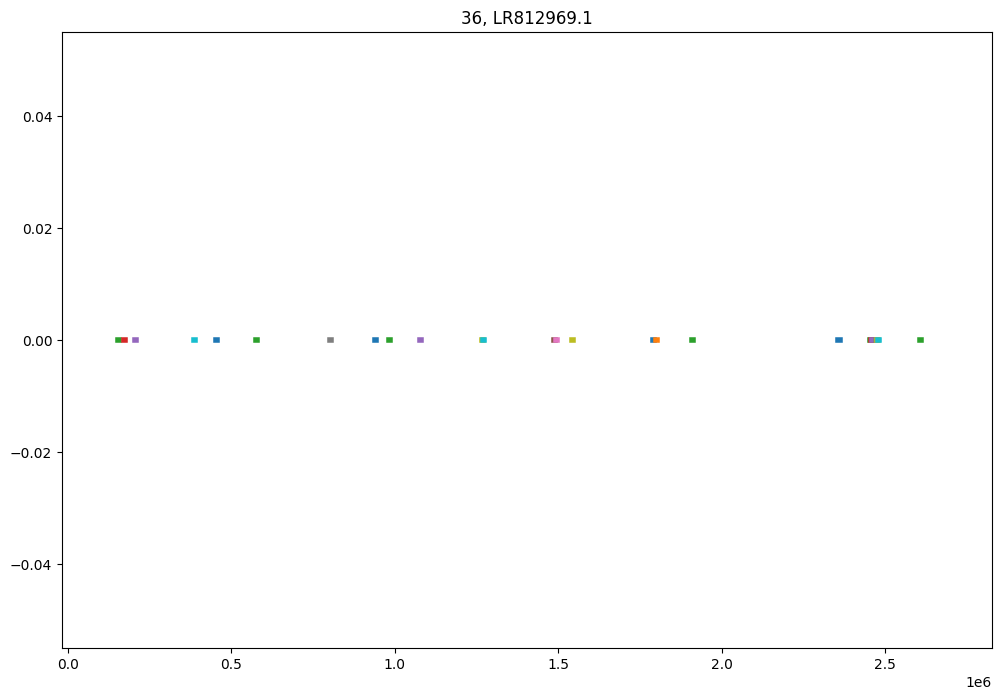

In [193]:
count = 0
for chrom in tqdm(range(1, 37)):
    clf()
    for gene in genes:
        gene = "gene-" +gene
        seqid = conv.query("Geneid==@gene").seqid.values[0]
        
        if seqid == f"LR8129{chrom+33}.1":
            ID = conv.query("Geneid==@gene").Geneid.values[0]
            #ginf.df.query("ID == @ID")
            start, stop = ginf.df.query("ID==@ID").start.values[0], ginf.df.query("ID==@ID").stop.values[0] 
            plot([start, stop], [count, count], lw=4)
            #count += 1
    title(f"{chrom}, LR8129{chrom+33}.1")
    savefig(f"distribution_deregulated_genes_{chrom}.png")

Orthogroup             infantum  \
5     OG0000021  gene-LINF_100008900   
141   OG0000270  gene-LINF_100007000   
142   OG0000271  gene-LINF_100007900   
143   OG0000273  gene-LINF_100013200   
144   OG0000274  gene-LINF_100015600   
1202  OG0001423  gene-LINF_100005800   
1228  OG0001449  gene-LINF_100009900   
1233  OG0001457  gene-LINF_100012200   
1243  OG0001467  gene-LINF_100013400   
1262  OG0001486  gene-LINF_100016300   
1265  OG0001489  gene-LINF_100017100   
1278  OG0001502  gene-LINF_100018500   
1283  OG0001507  gene-LINF_100019000   
1286  OG0001510  gene-LINF_100019300   
1299  OG0001524  gene-LINF_100021200   

                                             tarentolae  chr_name_inf  \
5     gene-LtaPh_1003381, gene-LtaPh_1003461, gene-L...            10   
141              gene-LtaPh_1001651, gene-LtaPh_1001700            10   
142              gene-LtaPh_1002400, gene-LtaPh_1002451            10   
143              gene-LtaPh_1010551, gene-LtaPh_1010600            10   
144              gene-LtaPh_1012751, gene-LtaPh_1012800            10   
1202                                 gene-LtaPh_1000600            10   
1228                                 gene-LtaPh_1004400            10   
1233                                 gene-LtaPh_1009600            10   
1243                                 gene-LtaPh_1010800            10   
1262                                 gene-LtaPh_1013200            10   
1265                                 gene-LtaPh_1013700            10   
1278                                 gene-LtaPh_1015100            10   
1283                                 gene-LtaPh_1015600            10   
1286                                 gene-LtaPh_1015900            10   
1299                                 gene-LtaPh_1017191            10   

      chr_name_tar  all_ratios  Linf_expression  Ltar_expression  \
5               10    0.925690              781             9729   
141             10    0.620487              841             1375   
142             10    0.590408              743             1071   
143             10    0.594790              840             1233   
144             10    0.697253             1488             3427   
1202            10    0.230255             3801             1137   
1228            10    0.848756              827             4641   
1233            10    0.229390             3739             1113   
1243            10    0.456518             2956             2483   
1262            10    0.907472              291             2854   
1265            10    0.366216              469              271   
1278            10    0.626316              426              714   
1283            10    0.324586             1184              569   
1286            10    0.716998              313              793   
1299            10    0.674972              574             1192   

      all_ratios_dna  Linf_coverage_dna  Ltar_coverage_dna  zscore_2d  \
5           0.822958                310               1441   6.545167   
141         0.726027                120                318   4.148686   
142         0.643312                168                303   2.725726   
143         0.646259                156                285   2.780193   
144         0.731707                 99                270   4.380535   
1202        0.534483                162                186   2.750649   
1228        0.480519                120                111   2.498506   
1233        0.475155                507                459   2.625105   
1243        0.362022                934                530   2.195835   
1262        0.809000                191                809   6.265414   
1265        0.286765                194                 78   3.658720   
1278        0.601990                 80                121   2.106997   
1283        0.391892                135                 87   2.407688   
1286        0.603053                104                158   2.462123   
1299       

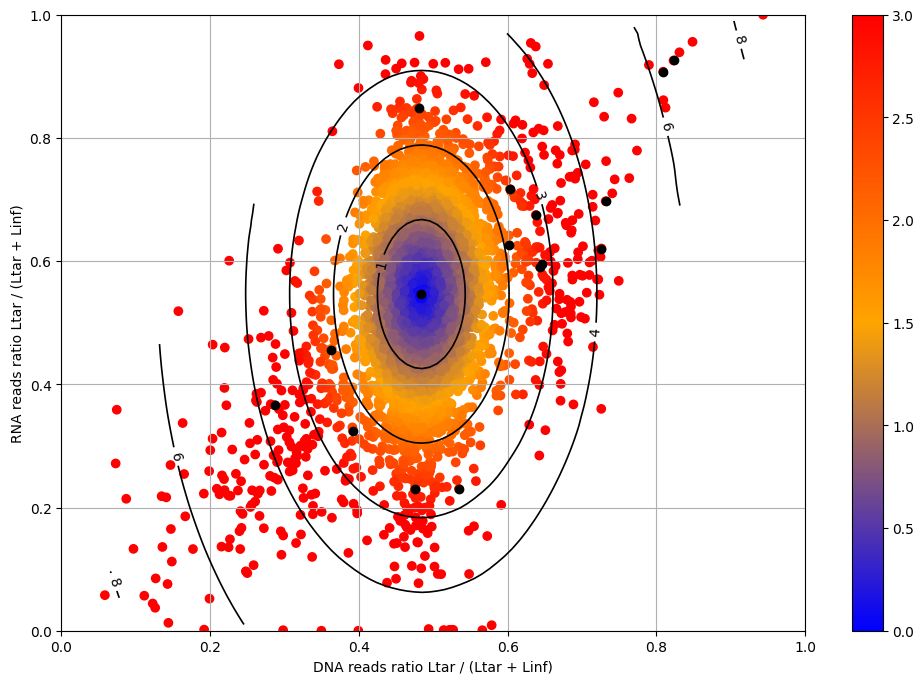

In [194]:
plot_dna_rna_plot(newX, newY)
zone = ortho_groups.query("zscore_2d>2")
#plot(zone.query("chr_name_inf==1").Xnormed, zone.query("chr_name_inf==1").Ynormed, 'oy') 
#plot(zone.query("chr_name_inf==2").Xnormed, zone.query("chr_name_inf==2").Ynormed, 'og') 
plot(zone.query("chr_name_inf==10").Xnormed, zone.query("chr_name_inf==10").Ynormed, 'ok') 
zone.query("chr_name_inf==10")